# Import Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import MaxAbsScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.decomposition import PCA
from prince import FAMD
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, recall_score, plot_precision_recall_curve
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

# Import Dataset - Credit Card Fraud Data (Transactional)

In [2]:
df_cc_trans = pd.read_csv('data/card_transdata.csv', header = 0)

In [3]:
df_cc_trans

distance_from_home  distance_from_last_transaction  \
0               57.877857                        0.311140   
1               10.829943                        0.175592   
2                5.091079                        0.805153   
3                2.247564                        5.600044   
4               44.190936                        0.566486   
...                   ...                             ...   
74420            2.285838                        0.272118   
74421           52.329549                        0.568009   
74422            1.929614                        1.633899   
74423           28.179360                        0.017210   
74424            3.310549                        0.016156   

       ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                            1.945940              1.0        1.0   
1                            1.294219              1.0        0.0   
2                            0.427715              1.0        0.0   
3                            0.362663              1.0        1.0   
4                            2.222767              1.0        1.0   
...                               ...              ...        ...   
74420                        1.776956              1.0        0.0   
74421                        1.389649              1.0        1.0   
74422                        1.260404              1.0        1.0   
74423                        1.578442              1.0        0.0   
74424                        1.874082              1.0        1.0   

       used_pin_number  online_order  fraud  
0                  0.0           0.0    0.0  
1                  0.0           0.0    0.0  
2                  0.0           1.0    0.0  
3                  0.0           1.0    0.0  
4                  0.0           1.0    0.0  
...                ...           ...    ...  
74420              0.0           1.0    0.0  
74421              0.0           1.0    0.0  
74422              0.0           1.0    0.0  
74423              0.0           1.0    0.0  
74424              0.0           1.0    0.0  

[74425 rows x 8 columns]

In [4]:
# separate predictor variable
series_cc_trans_pred = df_cc_trans['fraud']

In [5]:
series_cc_trans_pred

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
74420    0.0
74421    0.0
74422    0.0
74423    0.0
74424    0.0
Name: fraud, Length: 74425, dtype: float64

In [6]:
# create df without 'fraud' column
df_cc_trans_expl = df_cc_trans.drop('fraud', axis = 1)

In [7]:
df_cc_trans_expl

distance_from_home  distance_from_last_transaction  \
0               57.877857                        0.311140   
1               10.829943                        0.175592   
2                5.091079                        0.805153   
3                2.247564                        5.600044   
4               44.190936                        0.566486   
...                   ...                             ...   
74420            2.285838                        0.272118   
74421           52.329549                        0.568009   
74422            1.929614                        1.633899   
74423           28.179360                        0.017210   
74424            3.310549                        0.016156   

       ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                            1.945940              1.0        1.0   
1                            1.294219              1.0        0.0   
2                            0.427715              1.0        0.0   
3                            0.362663              1.0        1.0   
4                            2.222767              1.0        1.0   
...                               ...              ...        ...   
74420                        1.776956              1.0        0.0   
74421                        1.389649              1.0        1.0   
74422                        1.260404              1.0        1.0   
74423                        1.578442              1.0        0.0   
74424                        1.874082              1.0        1.0   

       used_pin_number  online_order  
0                  0.0           0.0  
1                  0.0           0.0  
2                  0.0           1.0  
3                  0.0           1.0  
4                  0.0           1.0  
...                ...           ...  
74420              0.0           1.0  
74421              0.0           1.0  
74422              0.0           1.0  
74423              0.0           1.0  
74424              0.0           1.0  

[74425 rows x 7 columns]

In [8]:
# convert categorical variable columns to 'bool' dtype
for col in df_cc_trans_expl[df_cc_trans_expl.columns.values[3:]]:
    df_cc_trans_expl[col] = df_cc_trans_expl[col].astype('bool')

# also...for predictor variable
series_cc_trans_pred = series_cc_trans_pred.astype('bool')

In [9]:
df_cc_trans_expl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74425 entries, 0 to 74424
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   distance_from_home              74425 non-null  float64
 1   distance_from_last_transaction  74425 non-null  float64
 2   ratio_to_median_purchase_price  74425 non-null  float64
 3   repeat_retailer                 74425 non-null  bool   
 4   used_chip                       74425 non-null  bool   
 5   used_pin_number                 74425 non-null  bool   
 6   online_order                    74425 non-null  bool   
dtypes: bool(4), float64(3)
memory usage: 2.0 MB


In [10]:
series_cc_trans_pred.dtypes

dtype('bool')

# EDA

In [11]:
df_cc_trans_expl.describe()

distance_from_home  distance_from_last_transaction  \
count        74425.000000                    74425.000000   
mean            26.702669                        5.097545   
std             65.720490                       25.796076   
min              0.021322                        0.000488   
25%              3.881030                        0.295595   
50%              9.990709                        0.989597   
75%             25.802185                        3.328718   
max           4601.011222                     2160.499922   

       ratio_to_median_purchase_price  
count                    74425.000000  
mean                         1.807926  
std                          2.806127  
min                          0.011373  
25%                          0.475143  
50%                          0.995081  
75%                          2.078513  
max                        126.294930

In [12]:
series_cc_trans_pred.describe()

count     74425
unique        2
top       False
freq      68007
Name: fraud, dtype: object

## Correlation Analysis

In [13]:
corr_mat = df_cc_trans.corr()

In [14]:
corr_mat['fraud']

distance_from_home                0.186338
distance_from_last_transaction    0.095101
ratio_to_median_purchase_price    0.451454
repeat_retailer                  -0.002134
used_chip                        -0.063509
used_pin_number                  -0.100455
online_order                      0.191150
fraud                             1.000000
Name: fraud, dtype: float64

In [15]:
# POSTULATE RATIOS/COMPARISONS OF FEATURES...TO BOOST MODEL'S PREDICTIVE ACCURACY 
# (IF INITIAL MODELS PERFORM POORLY)

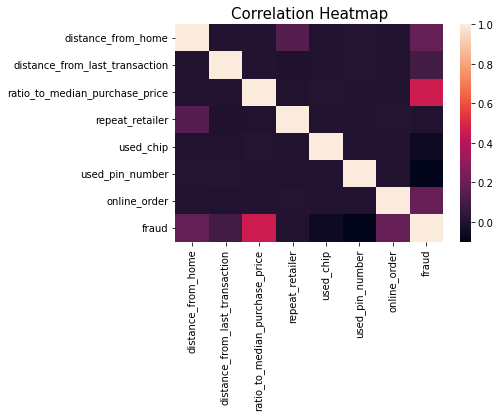

In [16]:
# correlation heatmap
ax = plt.axes()
sns.heatmap(corr_mat)
ax.set_title('Correlation Heatmap', fontsize = 15)
plt.show()

In [17]:
# normalize data to equally & visually compare potential explanatory variables
df_cc_trans_expl_norm = df_cc_trans_expl

min_max_scaler = MaxAbsScaler()

df_cc_trans_expl_norm[df_cc_trans_expl_norm.columns.values[:3]] = min_max_scaler.fit_transform(df_cc_trans_expl_norm[df_cc_trans_expl_norm.columns.values[:3]])

In [18]:
df_cc_trans_expl_norm.describe()

distance_from_home  distance_from_last_transaction  \
count        74425.000000                    7.442500e+04   
mean             0.005804                    2.359429e-03   
std              0.014284                    1.193986e-02   
min              0.000005                    2.257036e-07   
25%              0.000844                    1.368177e-04   
50%              0.002171                    4.580409e-04   
75%              0.005608                    1.540717e-03   
max              1.000000                    1.000000e+00   

       ratio_to_median_purchase_price  
count                    74425.000000  
mean                         0.014315  
std                          0.022219  
min                          0.000090  
25%                          0.003762  
50%                          0.007879  
75%                          0.016458  
max                          1.000000

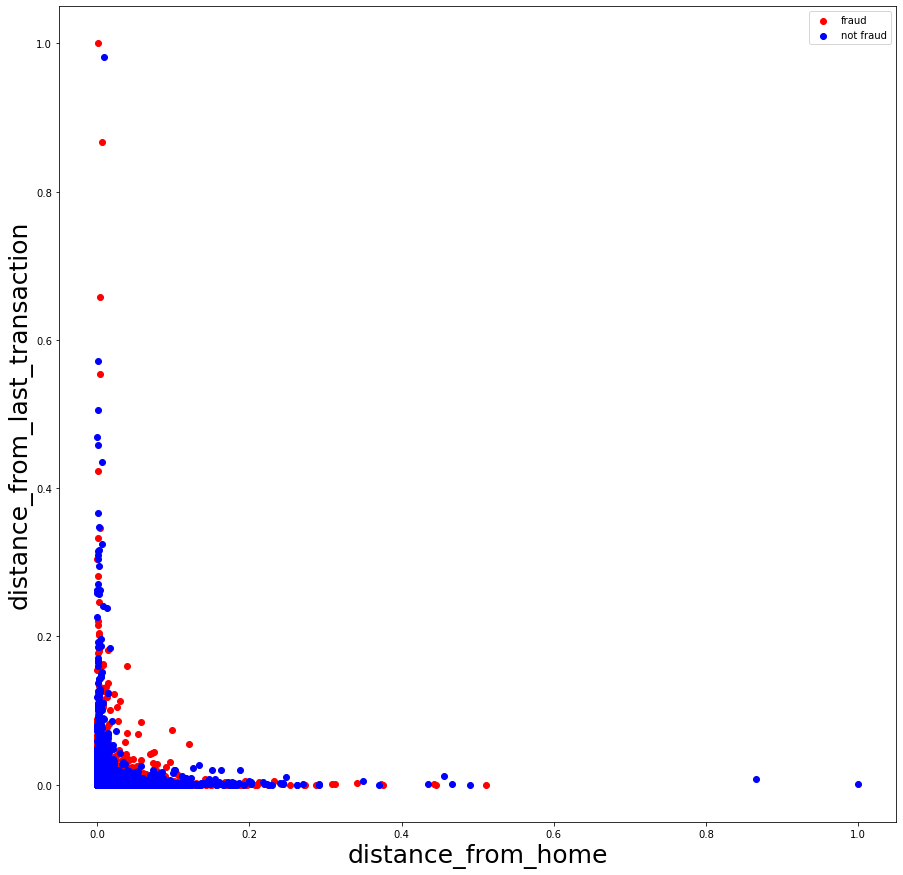

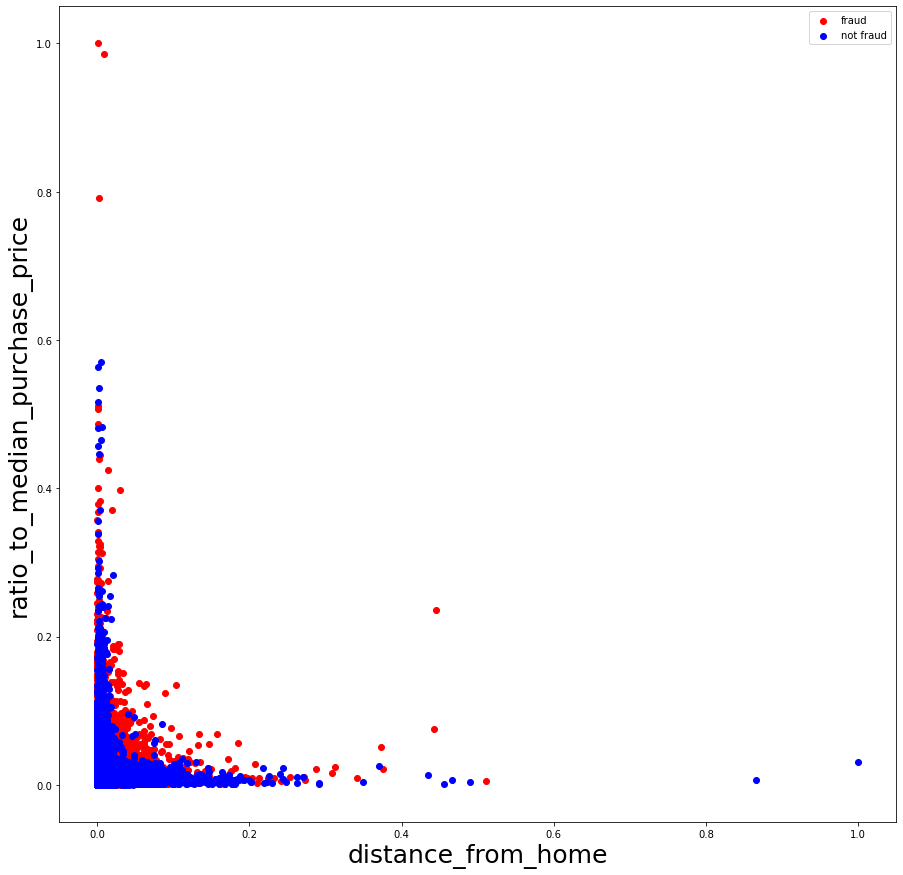

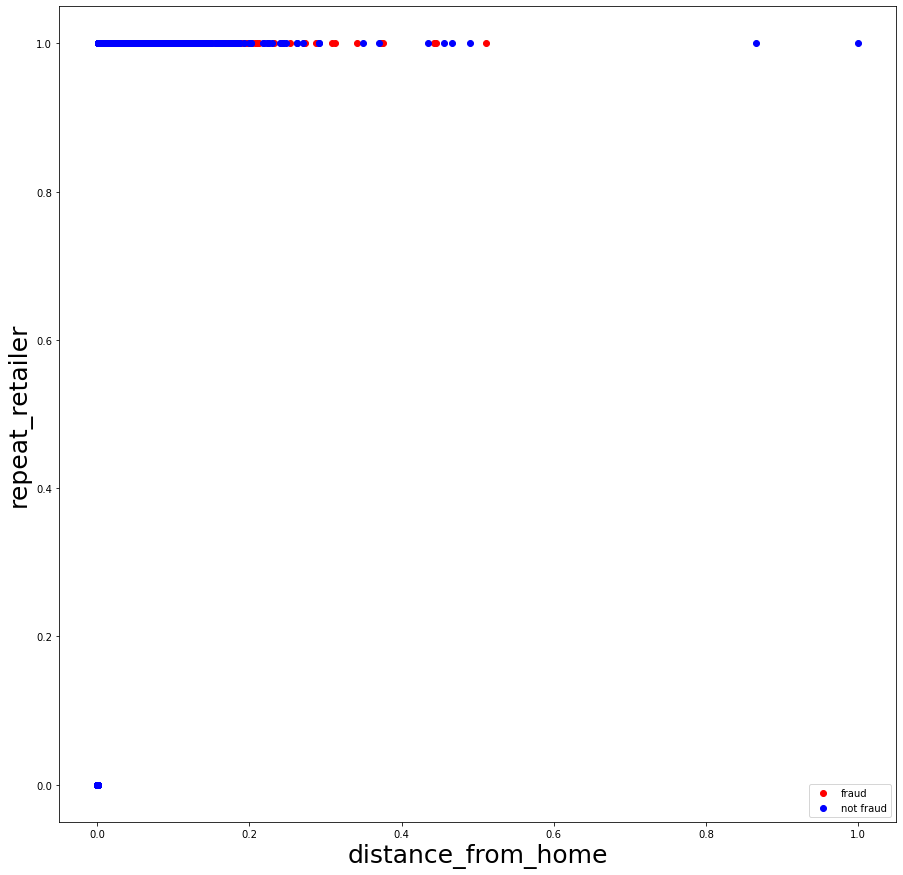

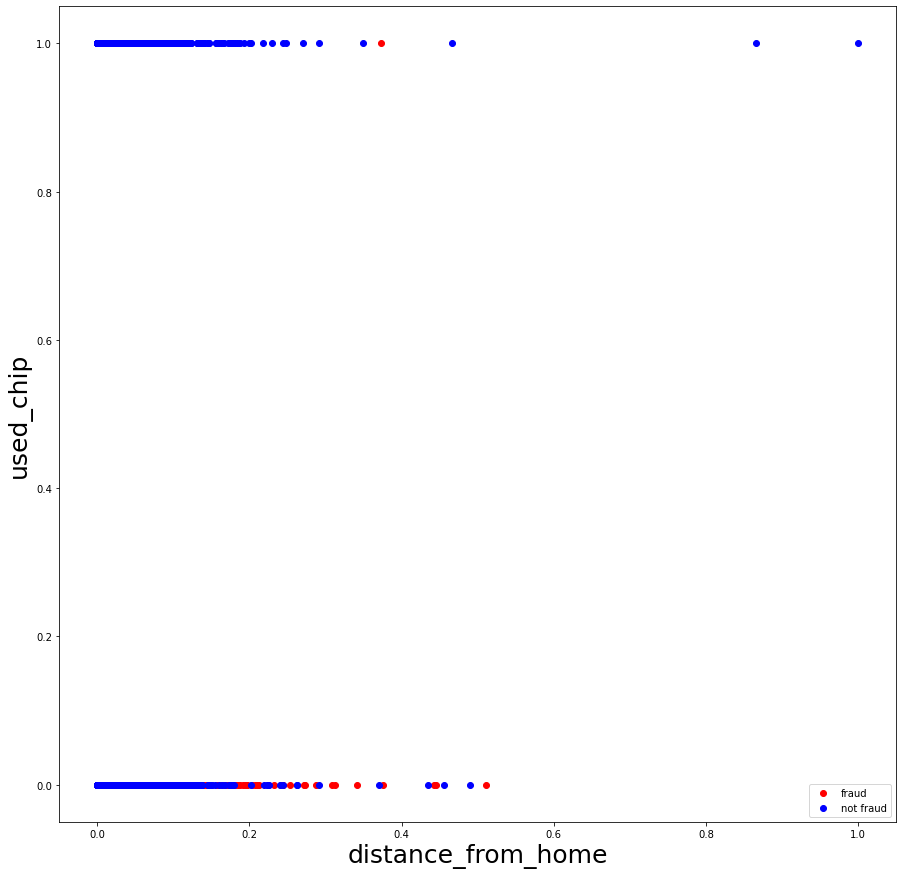

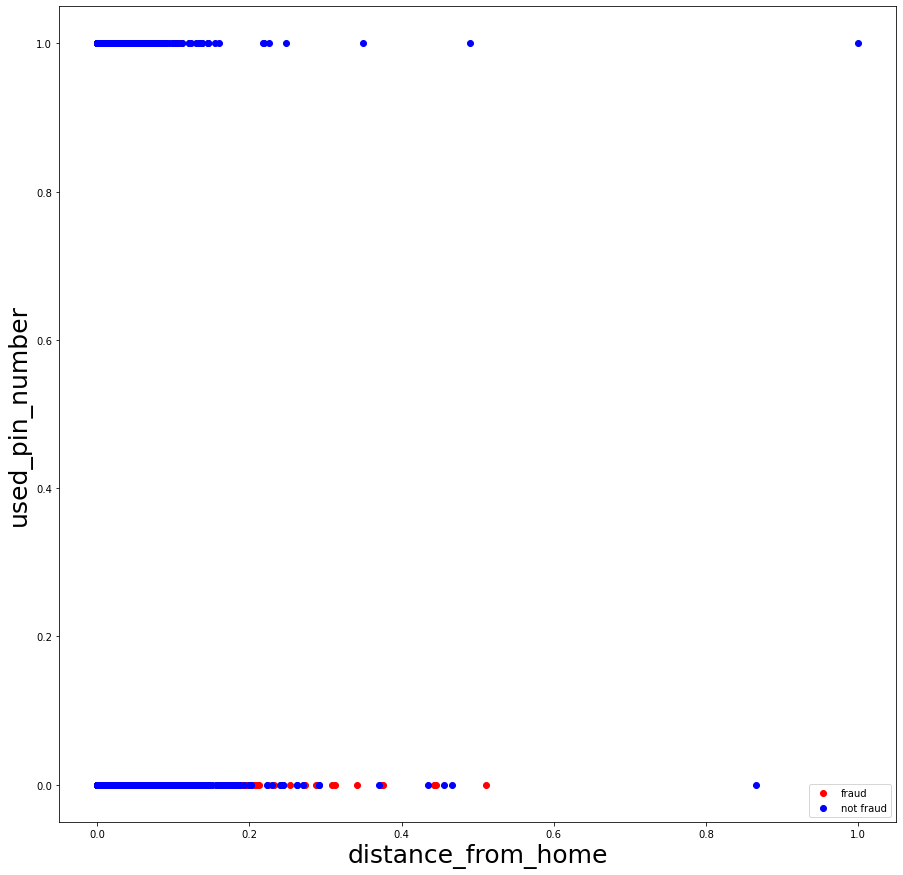

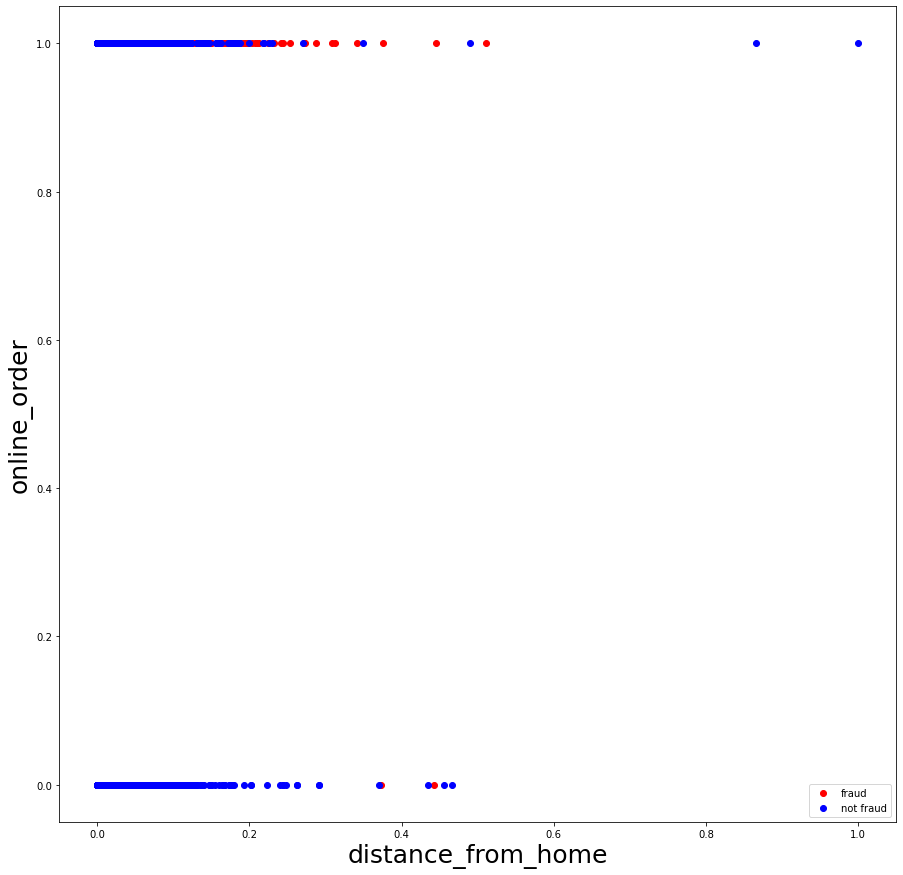

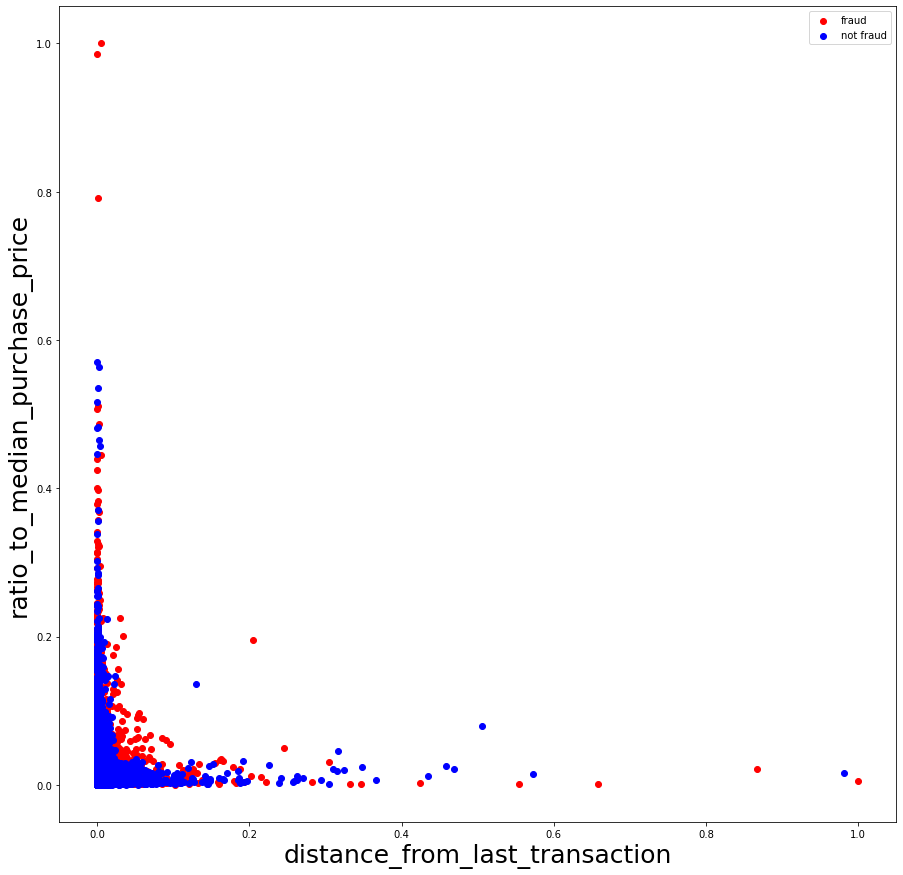

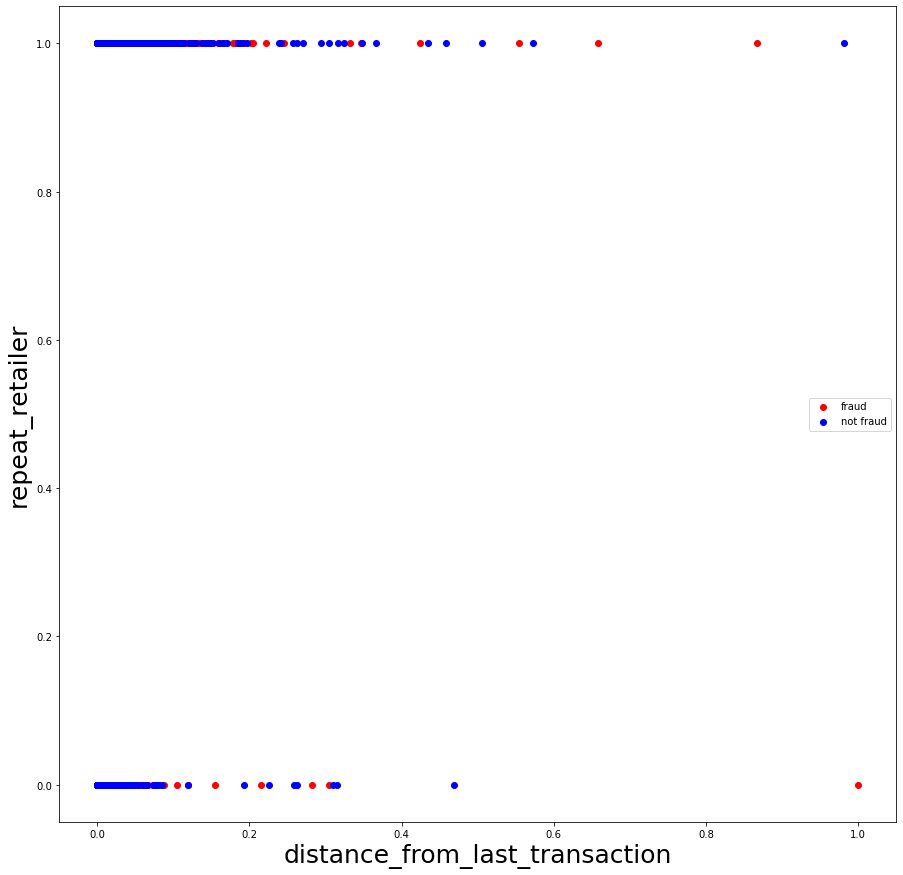

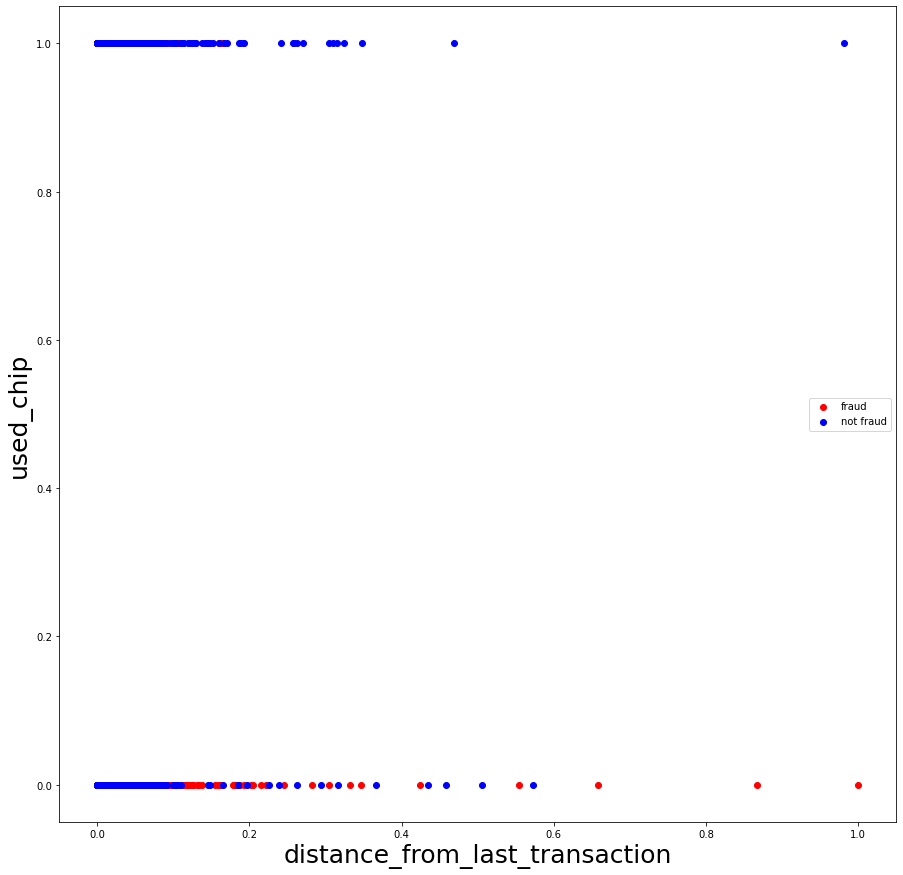

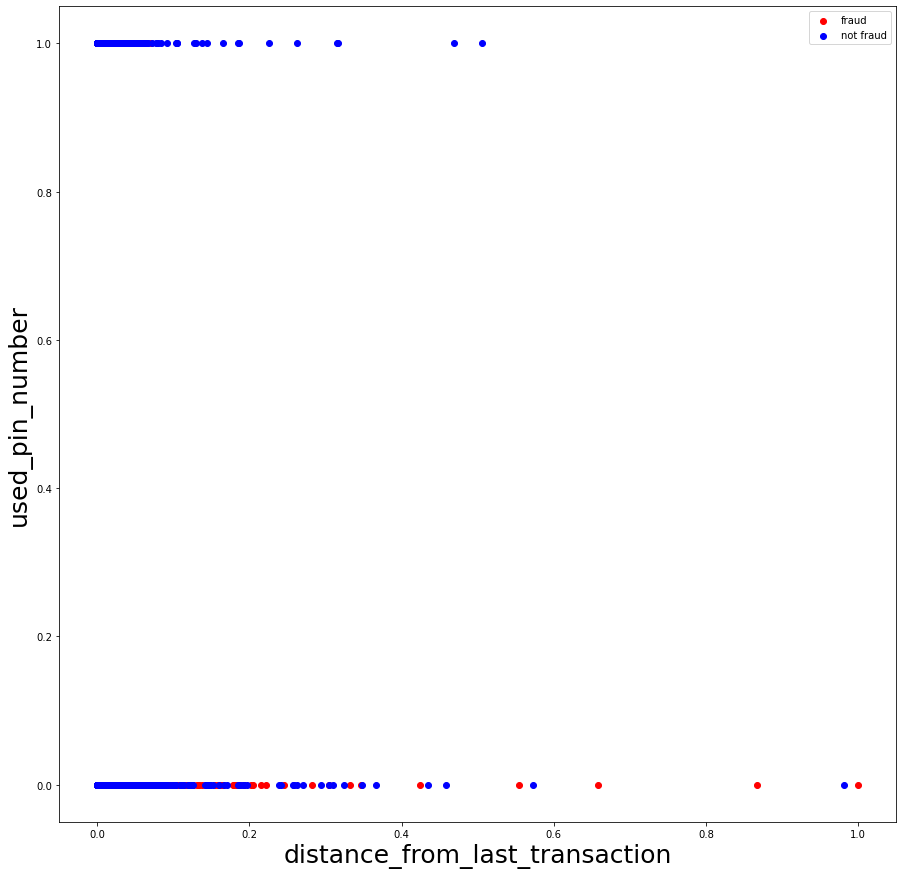

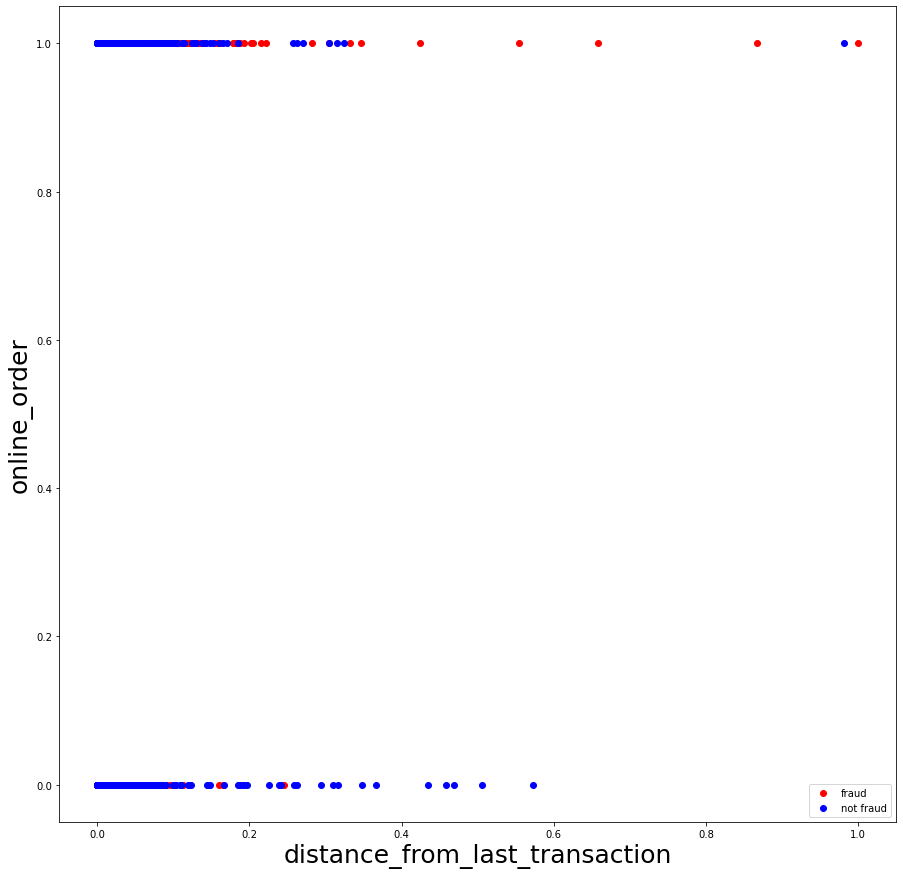

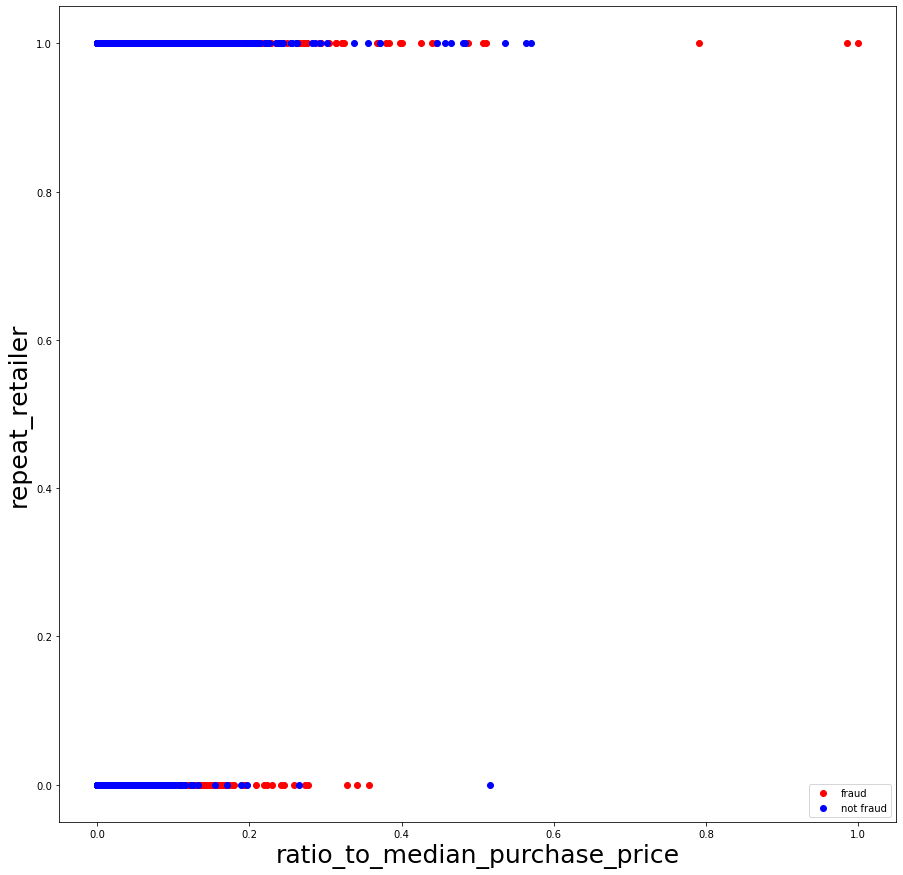

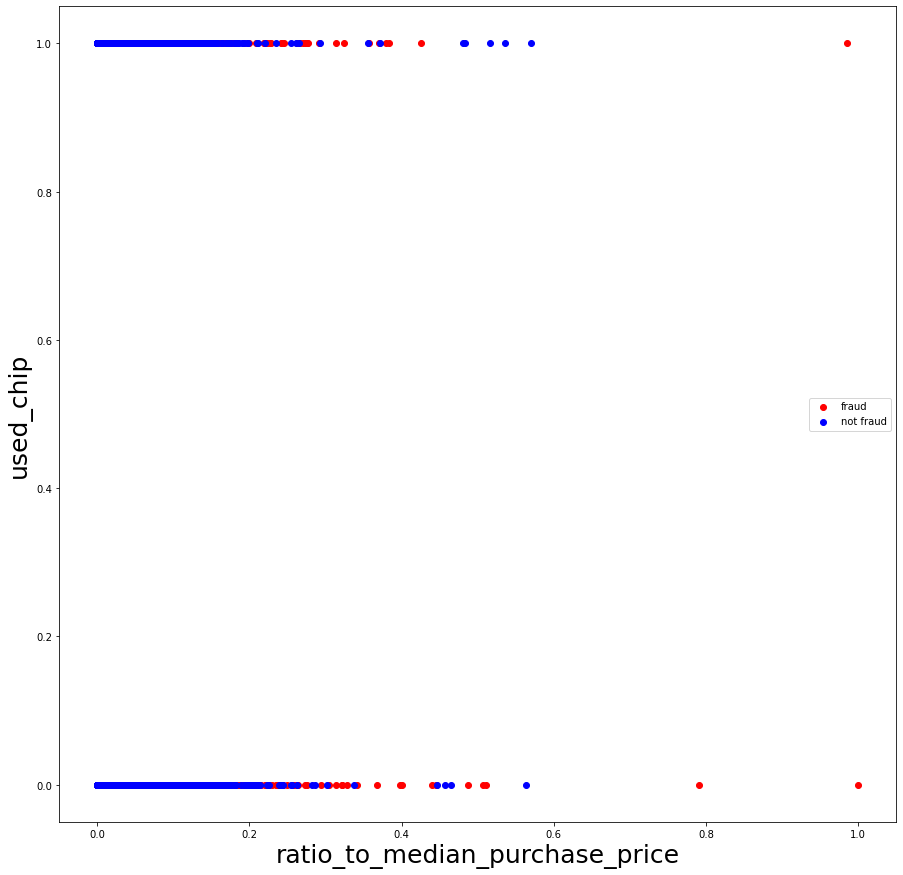

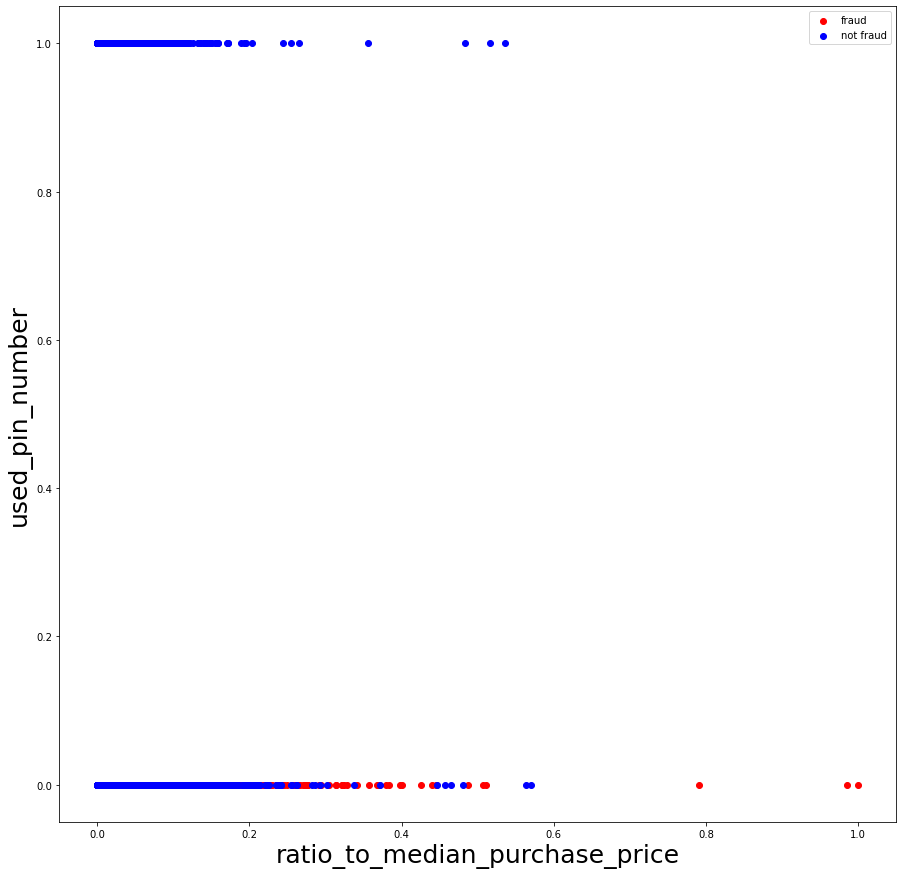

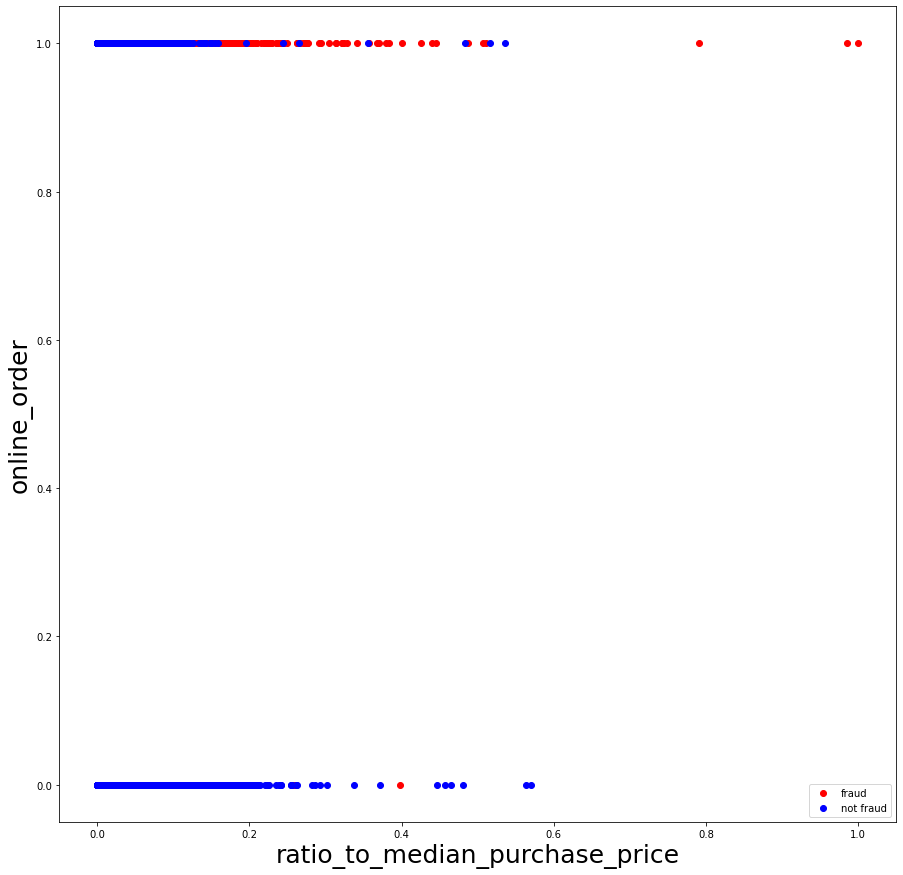

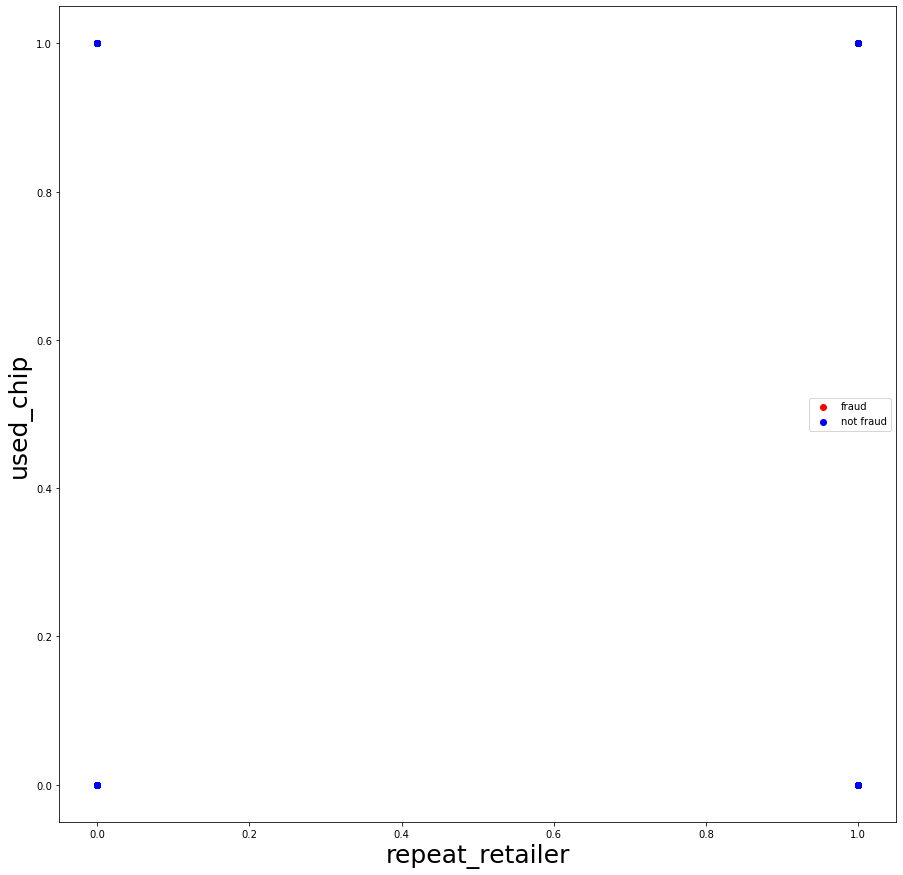

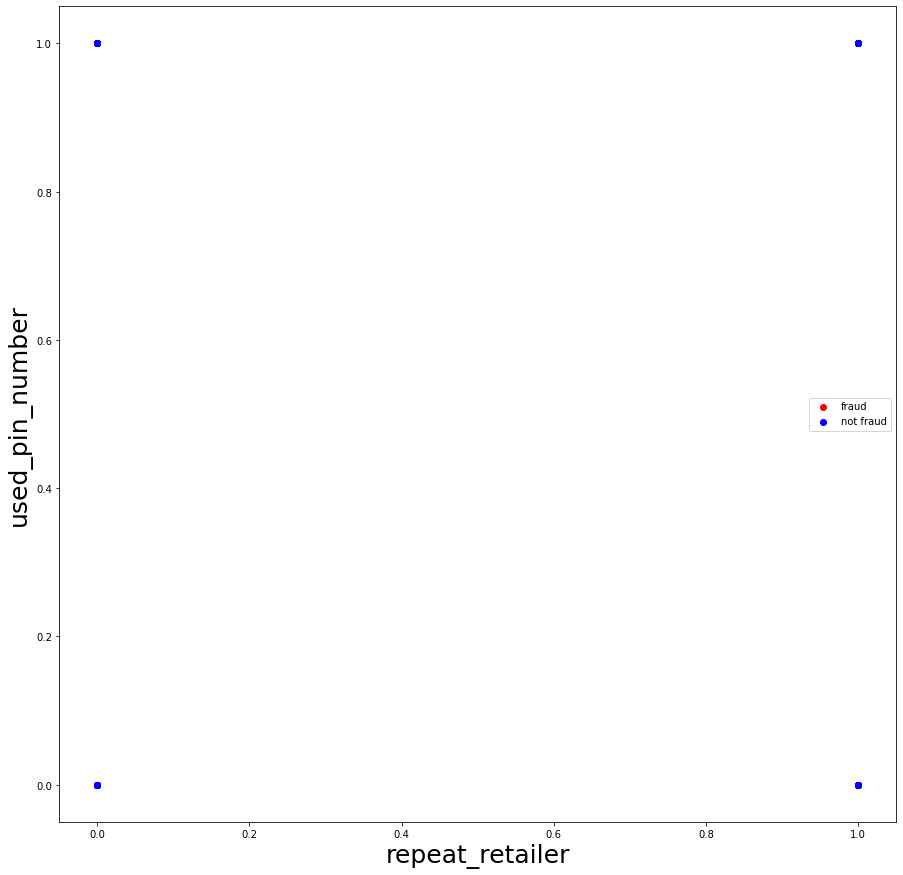

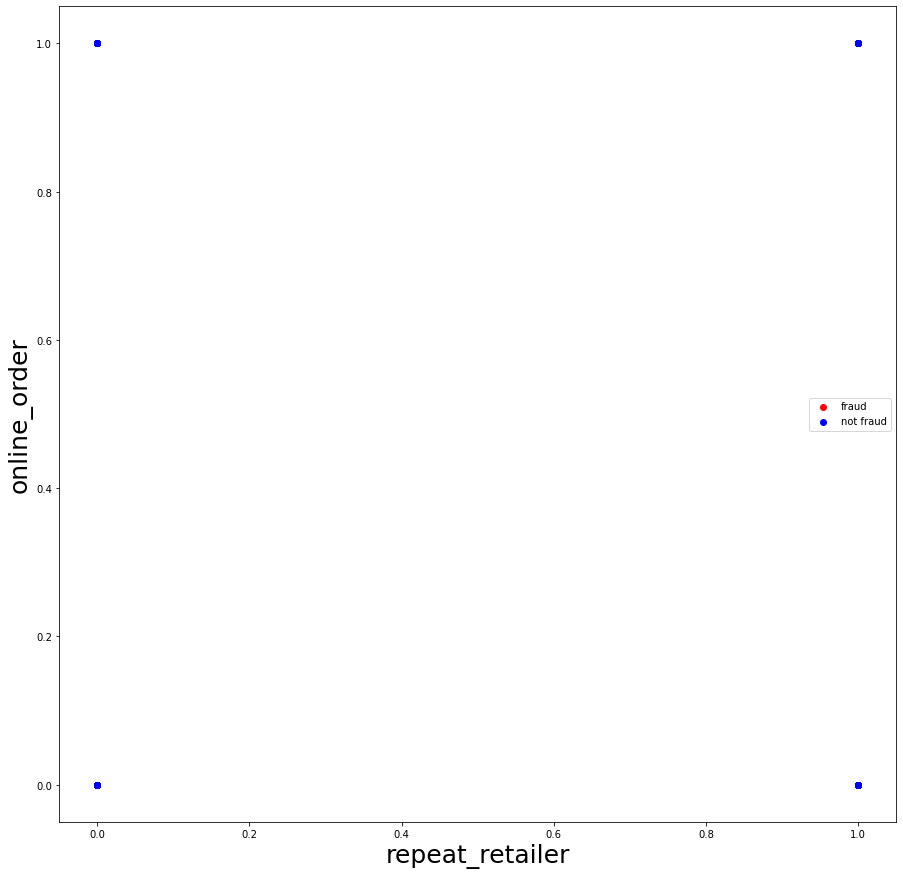

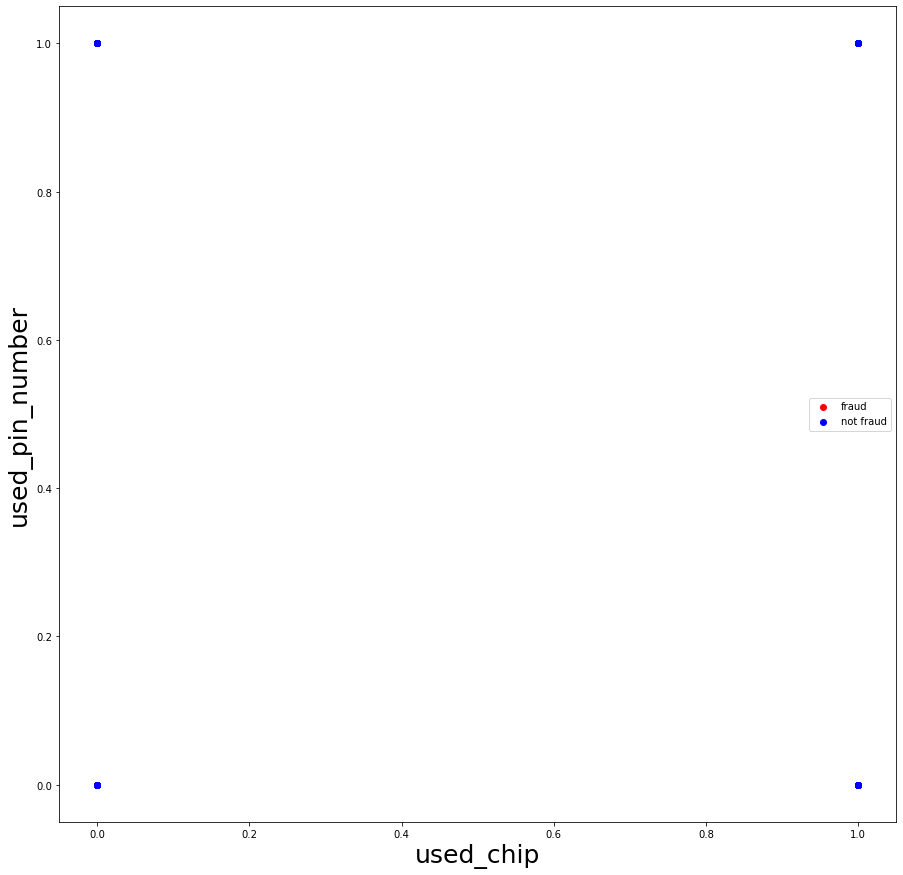

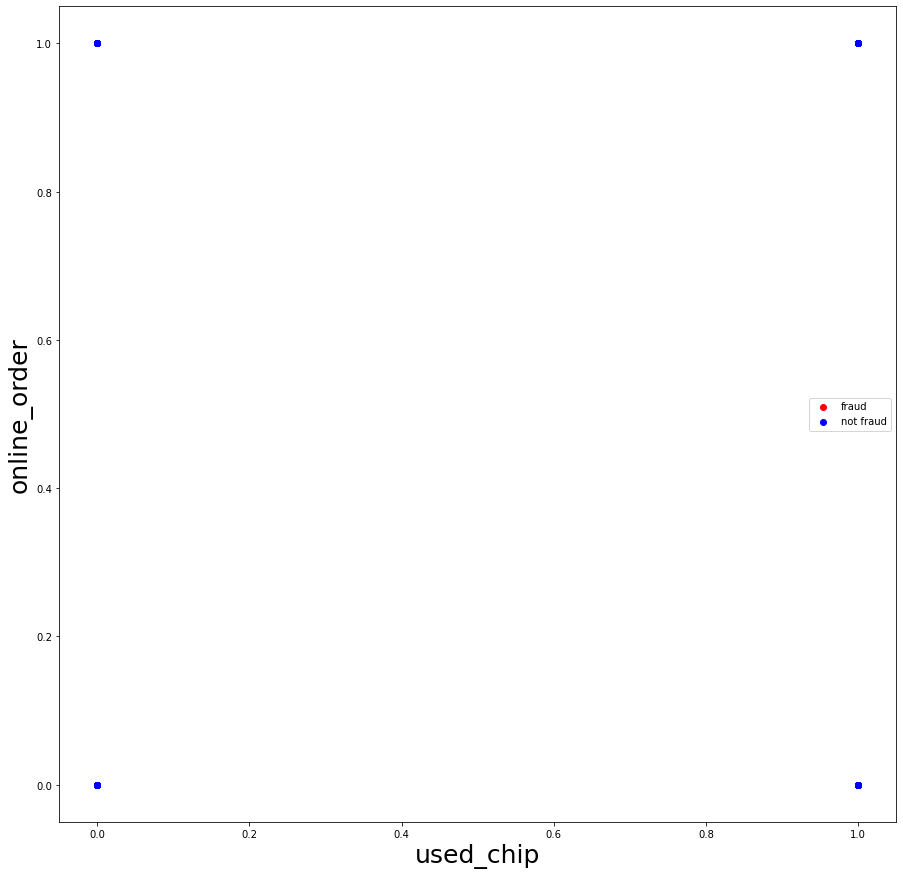

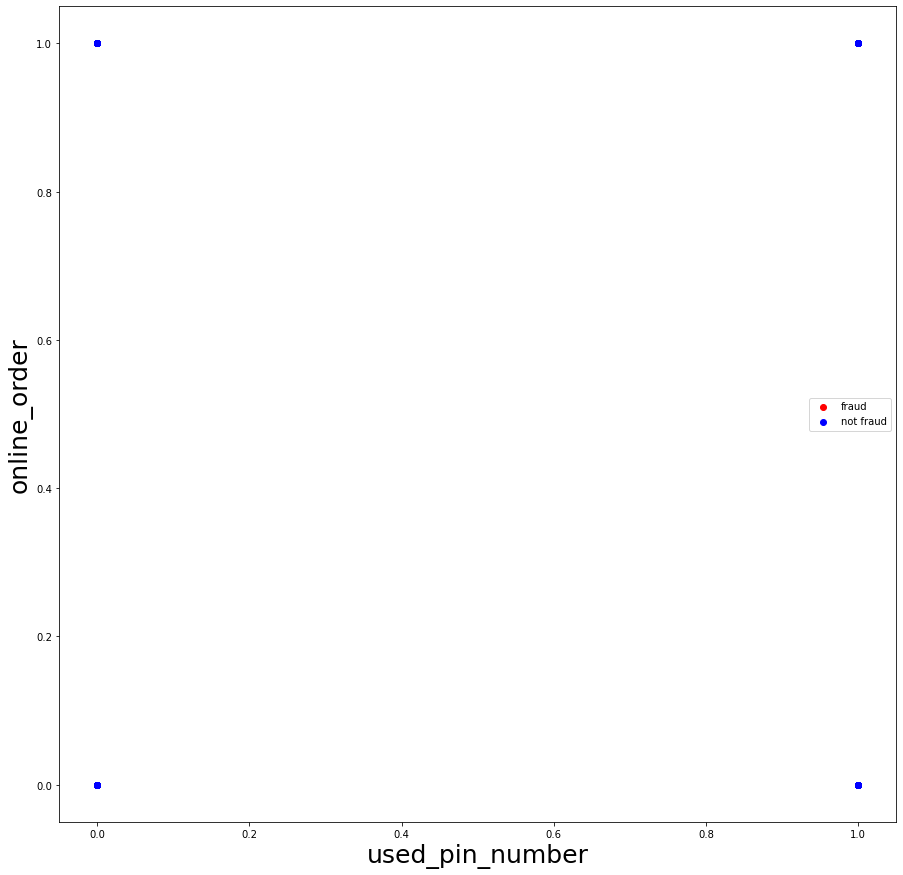

In [19]:
# compare potential explanatory variables against each other
columns = df_cc_trans_expl_norm.columns
index_fraud = df_cc_trans[df_cc_trans['fraud'] == 1.0].index.values
index_notfraud = df_cc_trans[df_cc_trans['fraud'] == 0.0].index.values

df_cc_trans_expl_norm_fraud = df_cc_trans_expl_norm.iloc[index_fraud]
df_cc_trans_expl_norm_notfraud = df_cc_trans_expl_norm.iloc[index_notfraud]

for i in range(len(columns)):
    for j in range(i+1, len(columns)):
            # plot variables against one another (2-d scatterplots)
            column_1 = columns[i]
            column_2 = columns[j]
            
            fig, ax = plt.subplots(figsize = (15,15))
            plt.scatter(x = df_cc_trans_expl_norm_fraud[column_1], y = df_cc_trans_expl_norm_fraud[column_2], 
                        c = 'red')
            plt.scatter(x = df_cc_trans_expl_norm_notfraud[column_1], 
                        y = df_cc_trans_expl_norm_notfraud[column_2], 
                        c = 'blue')
            plt.legend(['fraud', 'not fraud'])
            ax.set_ylabel(f'{column_2}', fontsize = 25)
            ax.set_xlabel(f'{column_1}', fontsize = 25)
            plt.show()

# Model Pre-processing

## Check Imbalance of Classes

In [20]:
# first...check for imbalance of classes
dict_cc_fraud = {}

for i in range(len(df_cc_trans)):
    fraud = df_cc_trans['fraud'][i]
    if fraud not in dict_cc_fraud.keys():
        dict_cc_fraud[fraud] = 1
    else:
        dict_cc_fraud[fraud] += 1

In [21]:
dict_cc_fraud
# many more non-fraud cases than fraud cases

{0.0: 68007, 1.0: 6418}

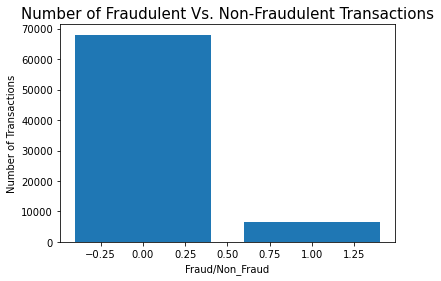

In [22]:
plt.bar(dict_cc_fraud.keys(), dict_cc_fraud.values())
plt.title('Number of Fraudulent Vs. Non-Fraudulent Transactions', fontsize = 15)
plt.xlabel('Fraud/Non_Fraud')
plt.ylabel('Number of Transactions')
plt.show()

In [23]:
# since we are developing fraud-detection model, 
# will use Recall as determinant of most viable model (with oversampling)

## Oversampling Method

In [24]:
# synthesize data via oversampling to minimize spread of data (in terms of each class of 'fraud' & 'non-fraud') 
# & capture all 'non-fraud'-related data
oversample = RandomOverSampler()

In [25]:
X, y = df_cc_trans_expl[df_cc_trans_expl.columns], series_cc_trans_pred

In [26]:
X_res, y_res = oversample.fit_resample(X, y)

## Train-Test Split (80/20)

In [27]:
# now...train/test split (80/20)
# utilizing stratify option on y (predictor variable) to maintain same distribution between train/test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size = 0.8, 
                                                    test_size = 0.2, stratify = y_res)

In [28]:
# reset indices
X_train.reset_index(inplace = True, drop = False)
X_test.reset_index(inplace = True, drop = False)

df_y_train = y_train.reset_index(drop = False)
df_y_test = y_test.reset_index(drop = False)

y_train.reset_index(inplace = True, drop = True)
y_test.reset_index(inplace = True, drop = True)

In [29]:
X_train

index  distance_from_home  distance_from_last_transaction  \
0       102935            0.000703                        0.000743   
1        26223            0.001318                        0.000189   
2        54477            0.000392                        0.000095   
3        60776            0.006912                        0.007530   
4        96364            0.018361                        0.002116   
...        ...                 ...                             ...   
108806   94683            0.000125                        0.000120   
108807   67328            0.009183                        0.000526   
108808   80782            0.030013                        0.112829   
108809   79226            0.014621                        0.000123   
108810   10642            0.001443                        0.000177   

        ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                             0.032181             True       True   
1                             0.006523             True      False   
2                             0.008068            False      False   
3                             0.001325             True      False   
4                             0.070812             True      False   
...                                ...              ...        ...   
108806                        0.033670            False      False   
108807                        0.147533             True      False   
108808                        0.006476             True      False   
108809                        0.038051             True       True   
108810                        0.004272             True      False   

        used_pin_number  online_order  
0                 False          True  
1                 False          True  
2                 False          True  
3                 False          True  
4                 False          True  
...                 ...           ...  
108806            False          True  
108807            False         False  
108808            False         False  
108809            False          True  
108810            False          True  

[108811 rows x 8 columns]

In [30]:
# normalize ONLY train data to avoid bias in testing models
X_train_norm = X_train

min_max_scaler = MaxAbsScaler()

X_train_norm[X_train_norm.columns.values[1:4]] = min_max_scaler.fit_transform(X_train_norm[X_train_norm.columns.values[1:4]])

In [32]:
X_test

index  distance_from_home  distance_from_last_transaction  \
0      30992            0.000976                        0.000822   
1      55212            0.001265                        0.000152   
2      92773            0.014157                        0.000292   
3      30613            0.060773                        0.002205   
4      95471            0.009696                        0.000372   
...      ...                 ...                             ...   
27198  31715            0.002331                        0.000356   
27199  29039            0.007404                        0.000487   
27200  83775            0.007932                        0.022107   
27201  82381            0.000647                        0.000157   
27202   8355            0.003825                        0.001881   

       ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                            0.005311             True      False   
1                            0.010775             True       True   
2                            0.059657             True       True   
3                            0.040521             True      False   
4                            0.055657             True      False   
...                               ...              ...        ...   
27198                        0.014295             True       True   
27199                        0.007157             True      False   
27200                        0.039830             True       True   
27201                        0.048513            False       True   
27202                        0.009124             True      False   

       used_pin_number  online_order  
0                False          True  
1                False         False  
2                False          True  
3                False         False  
4                False          True  
...                ...           ...  
27198            False         False  
27199             True         False  
27200            False          True  
27201            False          True  
27202            False          True  

[27203 rows x 8 columns]

In [31]:
# fit test data to normalized train data to avoid bias when testing models
X_test_norm = X_test

min_max_scaler = MaxAbsScaler()

X_test_norm[X_test_norm.columns.values[1:4]] = min_max_scaler.fit_transform(X_test_norm[X_test_norm.columns.values[1:4]])

In [33]:
# do not include 'index'
X_train_model, X_test_model = X_train_norm[X_train_norm.columns.values[1:]], X_test_norm[X_test_norm.columns.values[1:]]

In [34]:
y_res.count()

136014

In [35]:
y_train.count()

108811

In [36]:
y_test.count()

27203

## Compare Distributions of y, y_train, y_test

In [37]:
# counts of fraudulent/non-fraudulent transactions in y, y_train, & y_test
y_dict = {False: 0, True: 0}
y_train_dict = {False: 0, True: 0}
y_test_dict = {False: 0, True: 0}

for actual in y:
    if actual == False:
        y_dict[False] += 1
    elif actual == True:
        y_dict[True] += 1
        
for actual in y_train:
    if actual == False:
        y_train_dict[False] += 1
    elif actual == True:
        y_train_dict[True] += 1
        
for actual in y_test:
    if actual == False:
        y_test_dict[False] += 1
    elif actual == True:
        y_test_dict[True] += 1

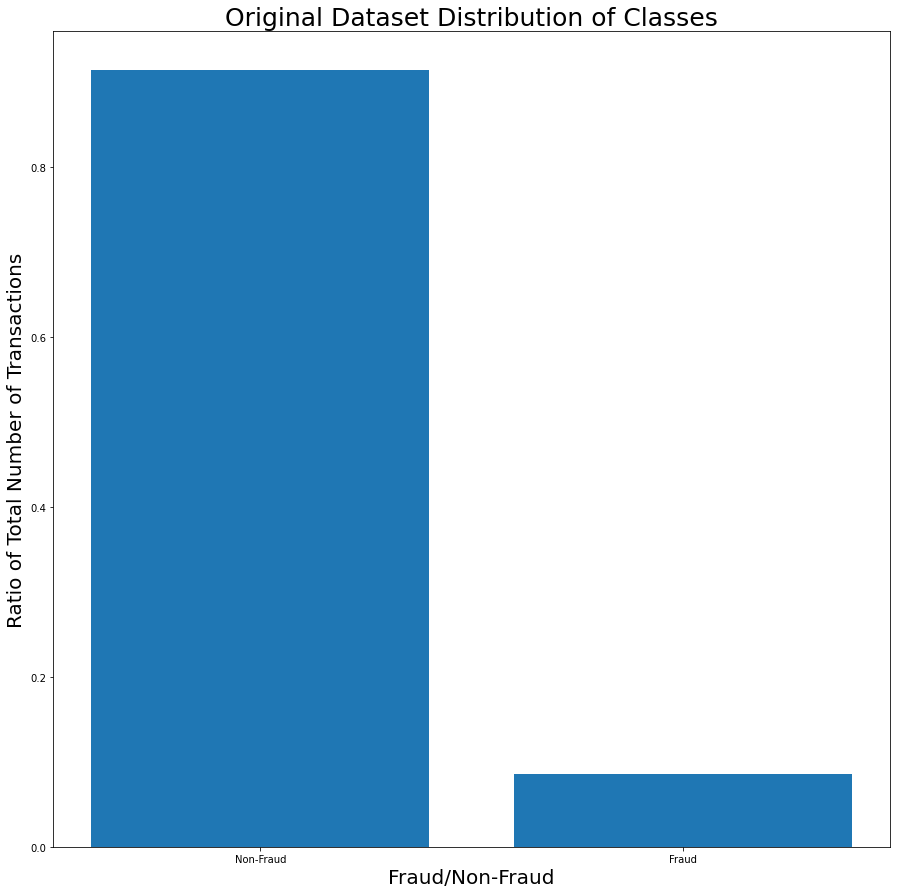

In [38]:
# bar graph comparisons of original dataset to train/test datasets (just y)

# original dataset
total_ct = sum(list(y_dict.values()))
y_ct = np.array(list(y_dict.values()))
fig, ax = plt.subplots(figsize = (15,15))
plt.bar(['Non-Fraud', 'Fraud'], height = y_ct/total_ct)
ax.set_ylabel('Ratio of Total Number of Transactions', fontsize = 20)
ax.set_xlabel('Fraud/Non-Fraud', fontsize = 20)
ax.set_title('Original Dataset Distribution of Classes', fontsize = 25)
plt.show()

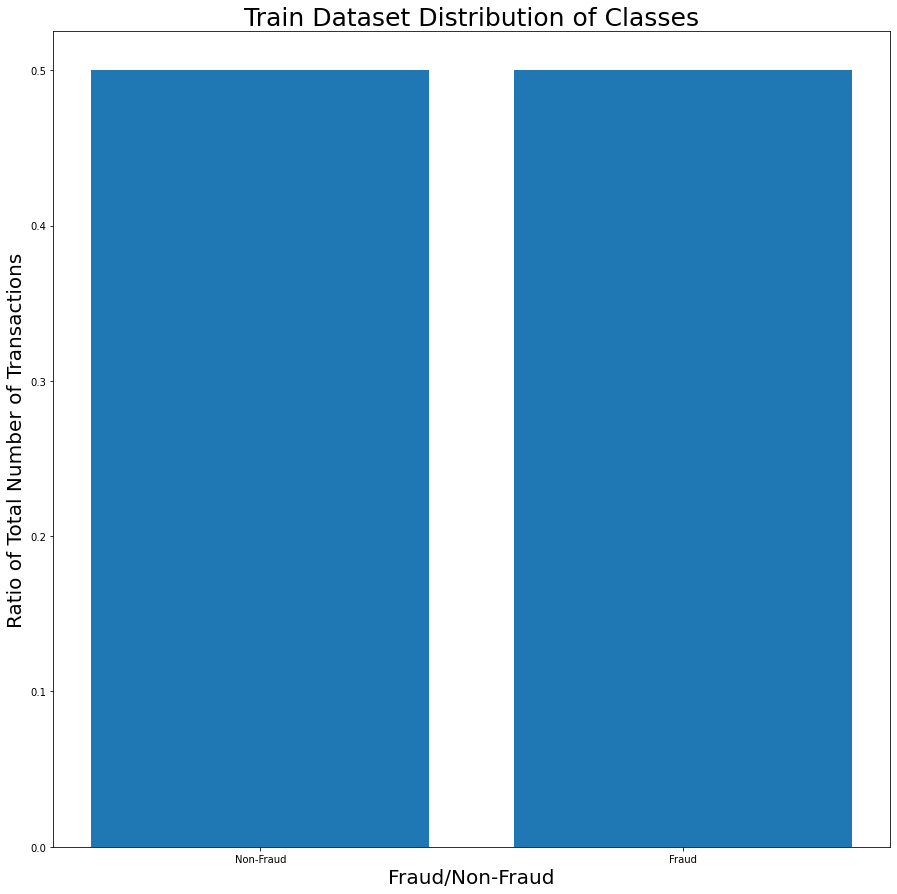

In [39]:
# y_train dataset
total_ct = sum(list(y_train_dict.values()))
y_ct = np.array(list(y_train_dict.values()))
fig, ax = plt.subplots(figsize = (15,15))
plt.bar(['Non-Fraud', 'Fraud'], height = y_ct/total_ct)
ax.set_ylabel('Ratio of Total Number of Transactions', fontsize = 20)
ax.set_xlabel('Fraud/Non-Fraud', fontsize = 20)
ax.set_title('Train Dataset Distribution of Classes', fontsize = 25)
plt.show()

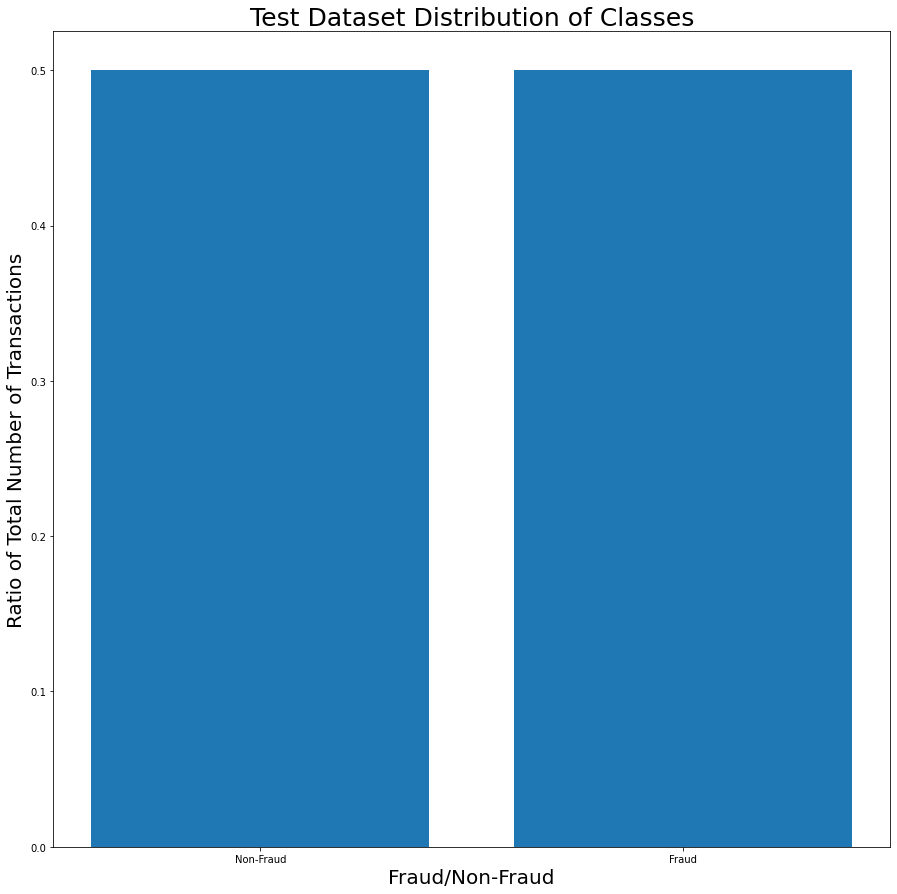

In [40]:
# y_test dataset
total_ct = sum(list(y_test_dict.values()))
y_ct = np.array(list(y_test_dict.values()))
fig, ax = plt.subplots(figsize = (15,15))
plt.bar(['Non-Fraud', 'Fraud'], height = y_ct/total_ct)
ax.set_ylabel('Ratio of Total Number of Transactions', fontsize = 20)
ax.set_xlabel('Fraud/Non-Fraud', fontsize = 20)
ax.set_title('Test Dataset Distribution of Classes', fontsize = 25)
plt.show()

## Compare Distributions of X, X_train, X_test

In [41]:
# store original, train, and test datasets in dictionary

dict_data = {'X': X, 'X_train': X_train, 'X_test': X_test}

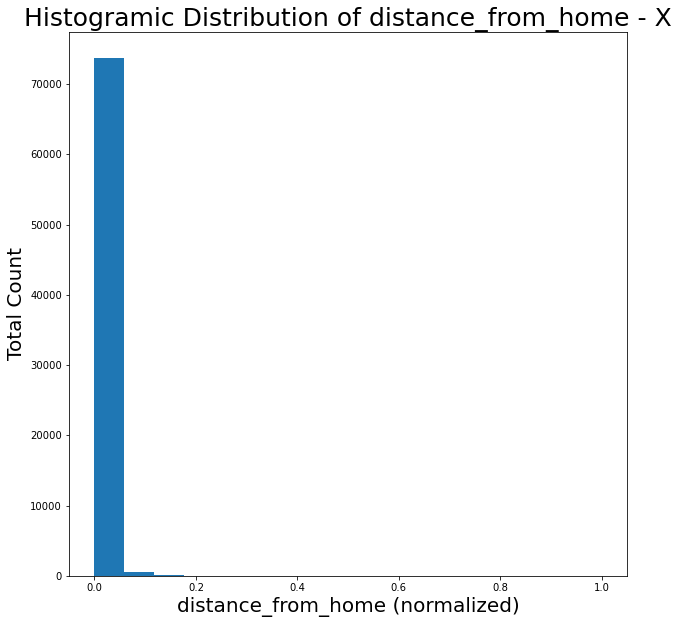

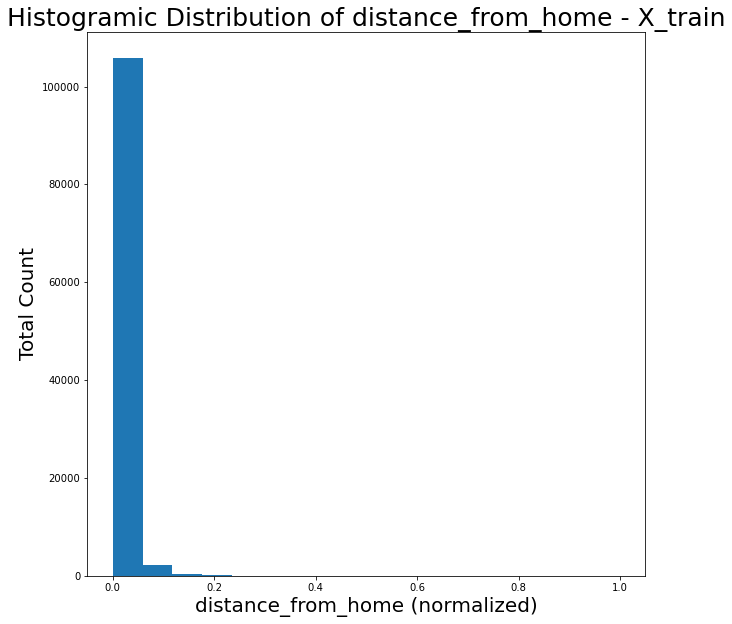

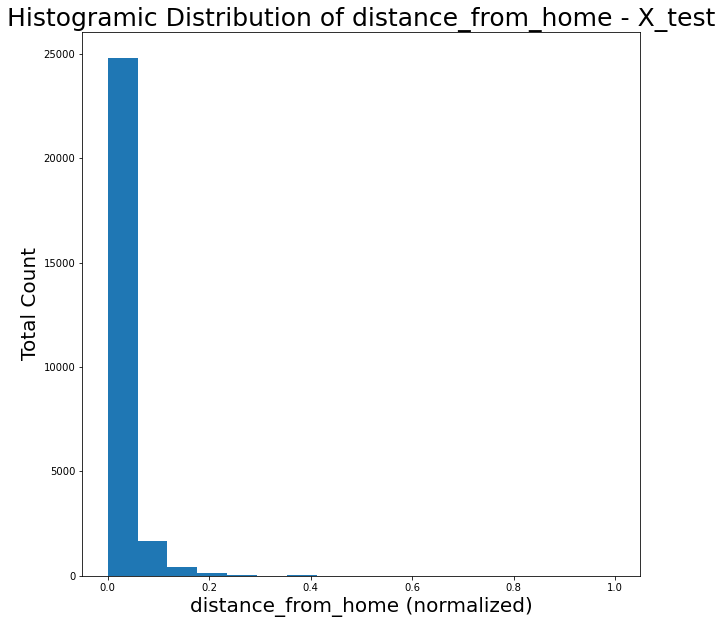

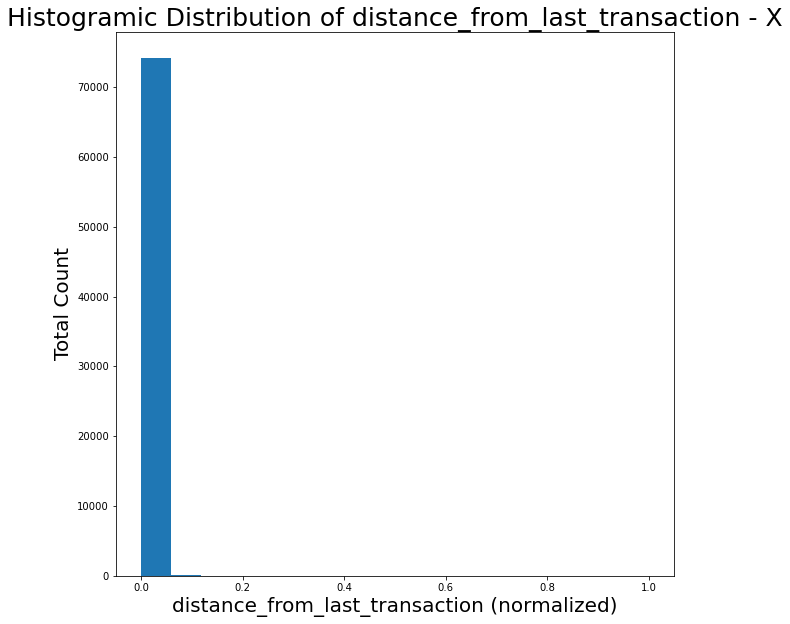

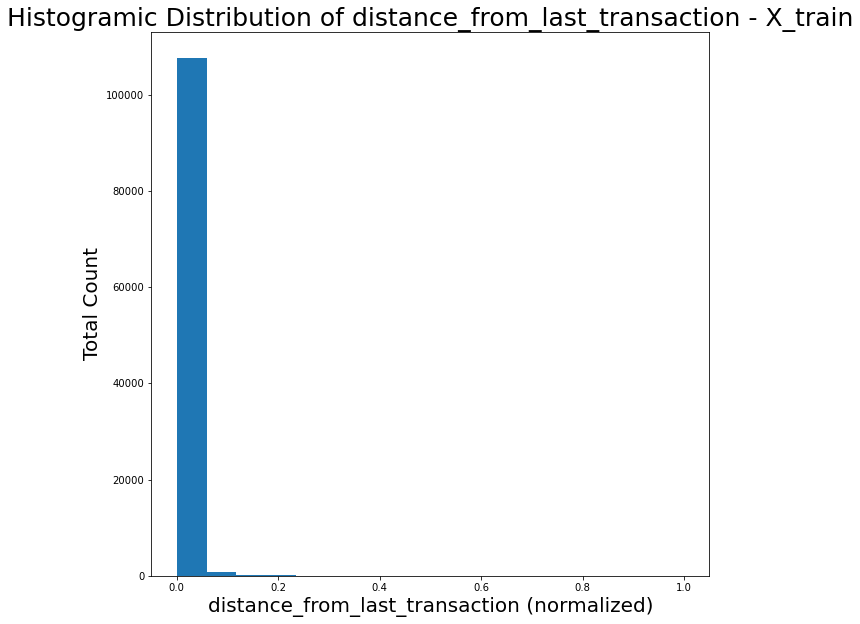

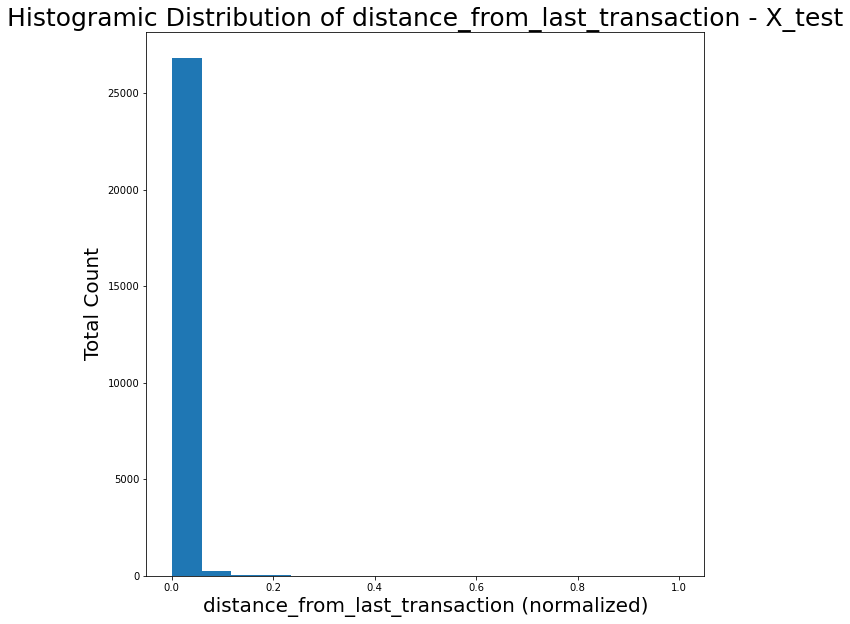

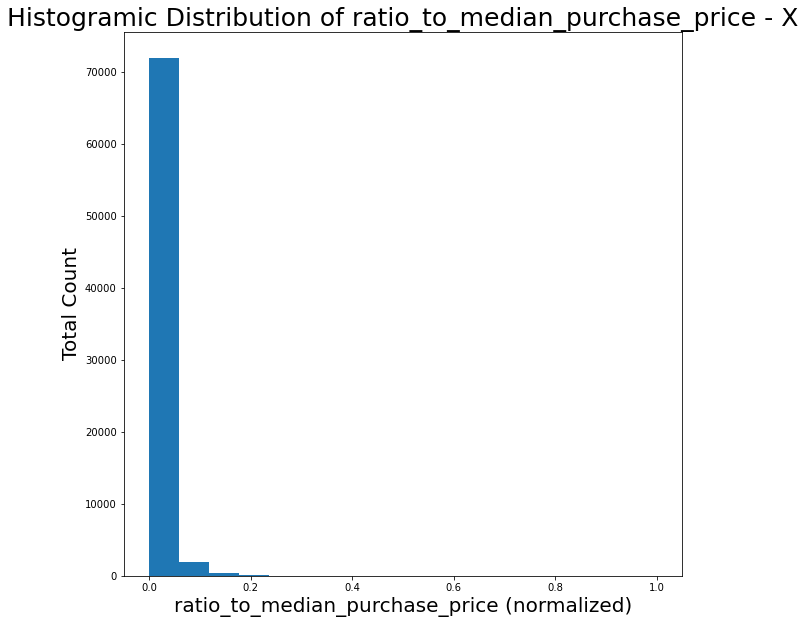

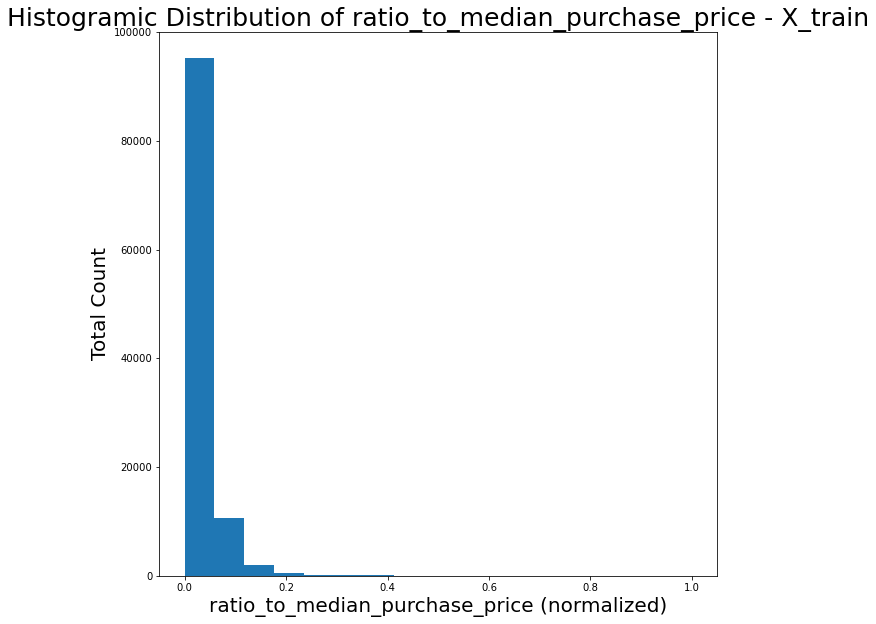

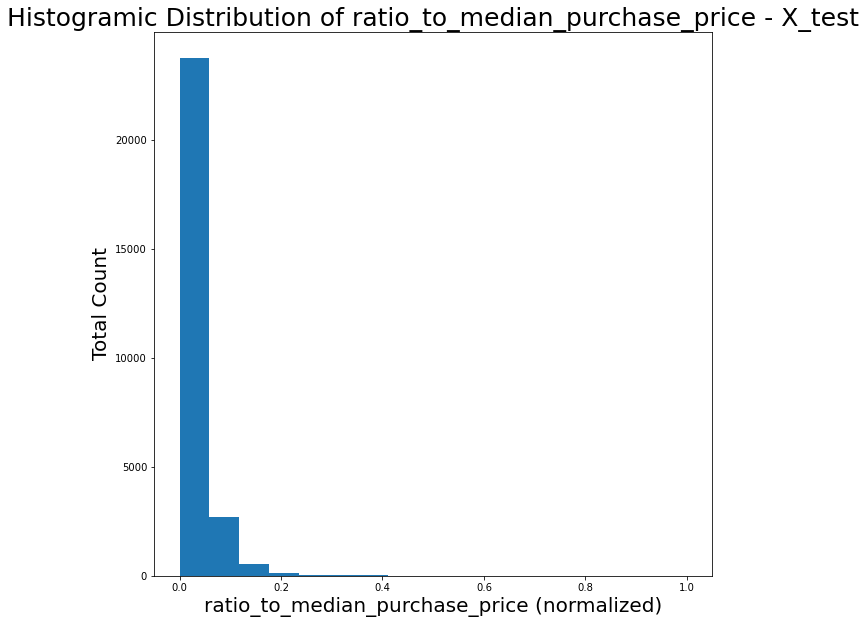

In [42]:
# now plot histogramic distributions of potential explanatory variables

# original dataset 
# continuous explanatory variables
cols_continuous = X.columns.values[:3]
cols_categorical = X.columns.values[3:]
num_bins = int(round(1 + 3.3 * np.log10(len(X)), 0))

for col in cols_continuous:
    for name, data in dict_data.items():
        fig, ax = plt.subplots(figsize = (10,10))
        plt.hist(data[col], bins = num_bins)
        ax.set_ylabel('Total Count', fontsize = 20)
        ax.set_xlabel(f'{col} (normalized)', fontsize = 20)
        ax.set_title(f'Histogramic Distribution of {col} - {name}', fontsize = 25)
        plt.show()

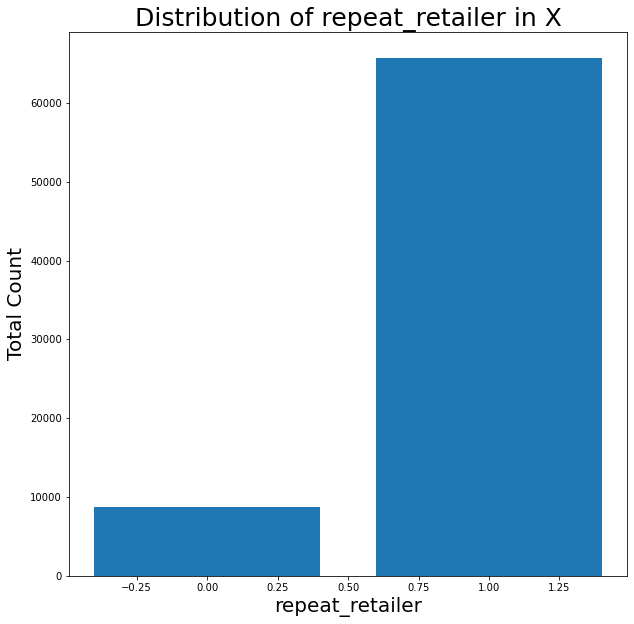

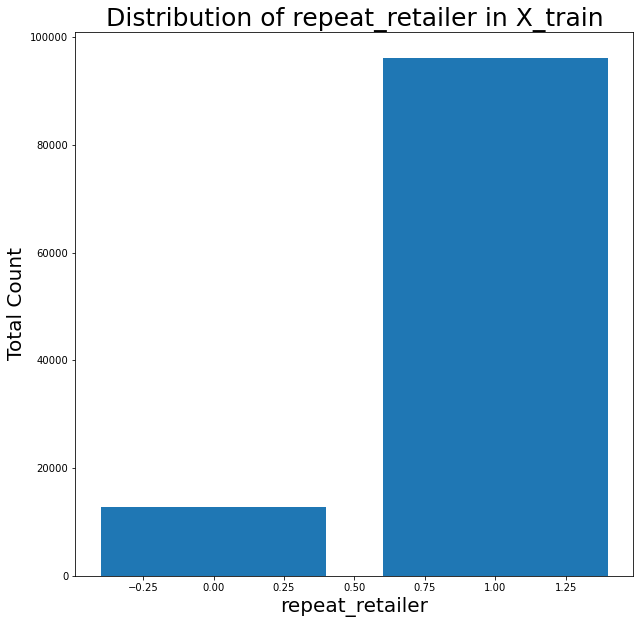

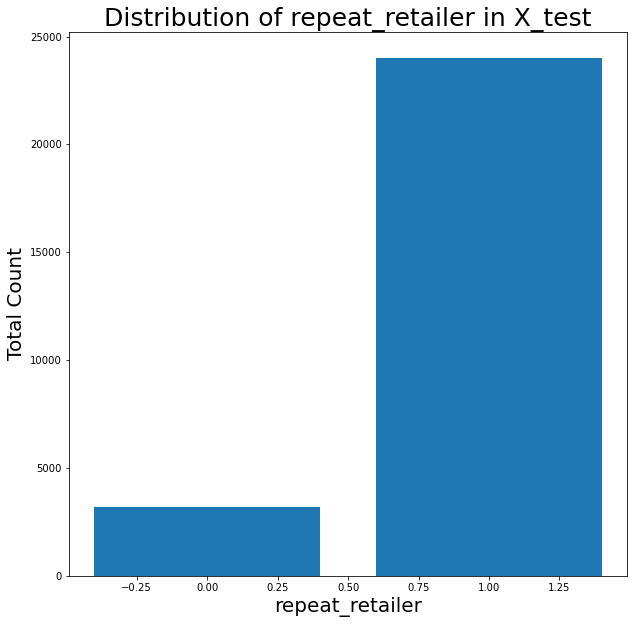

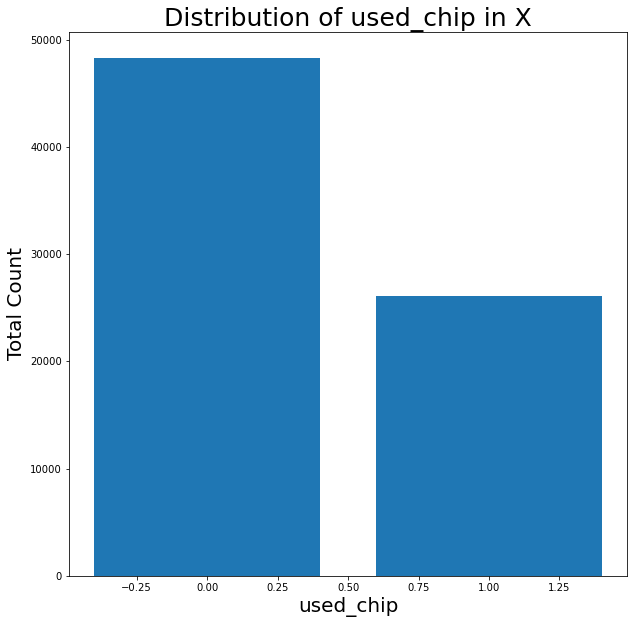

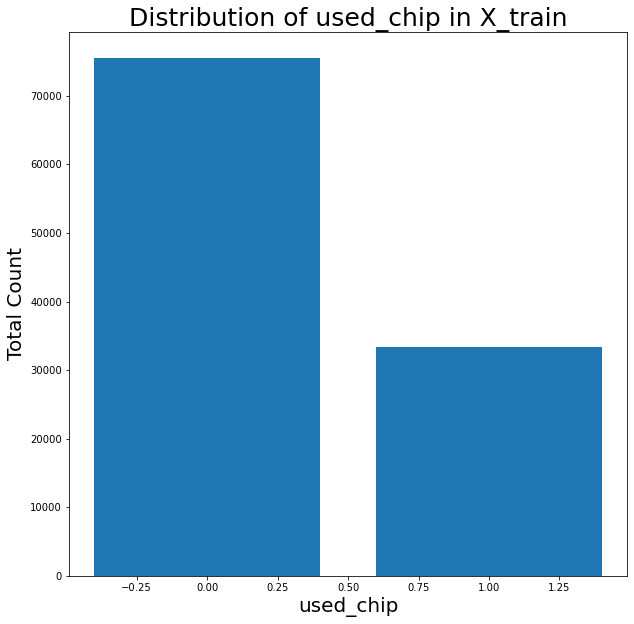

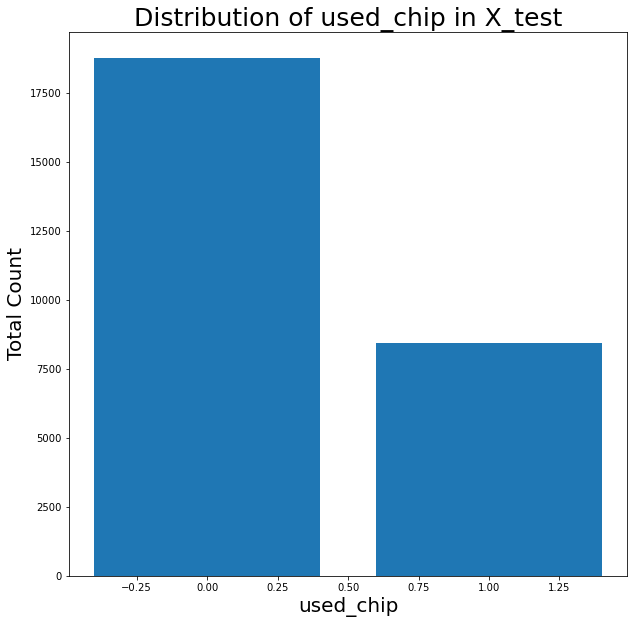

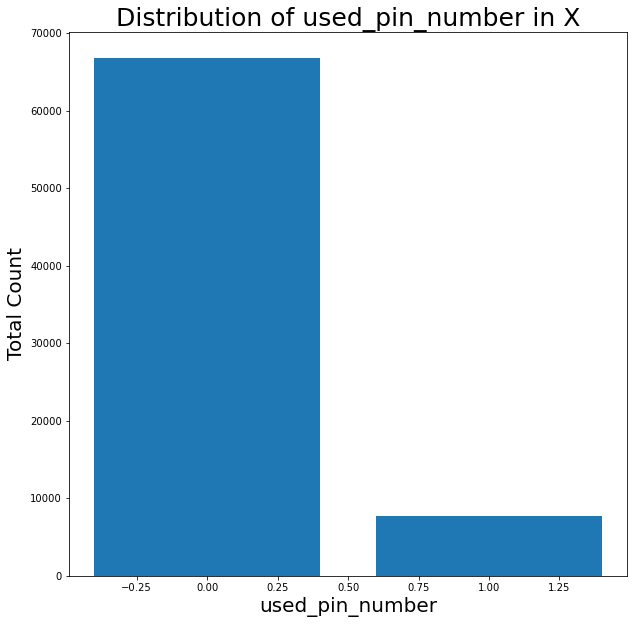

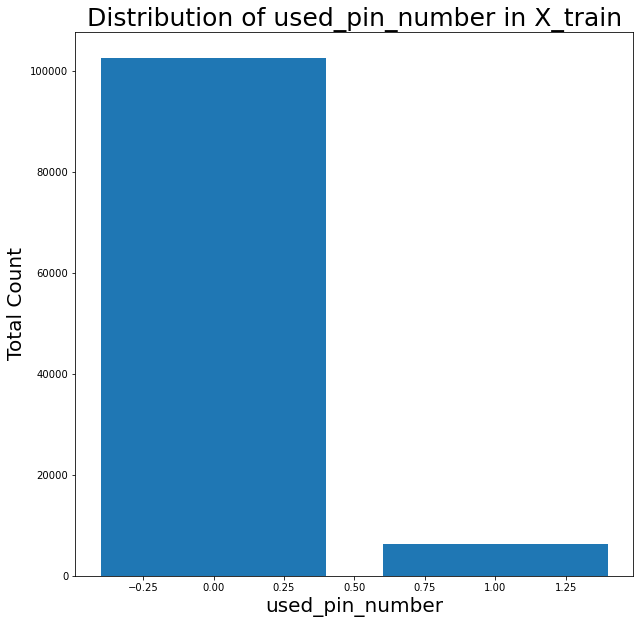

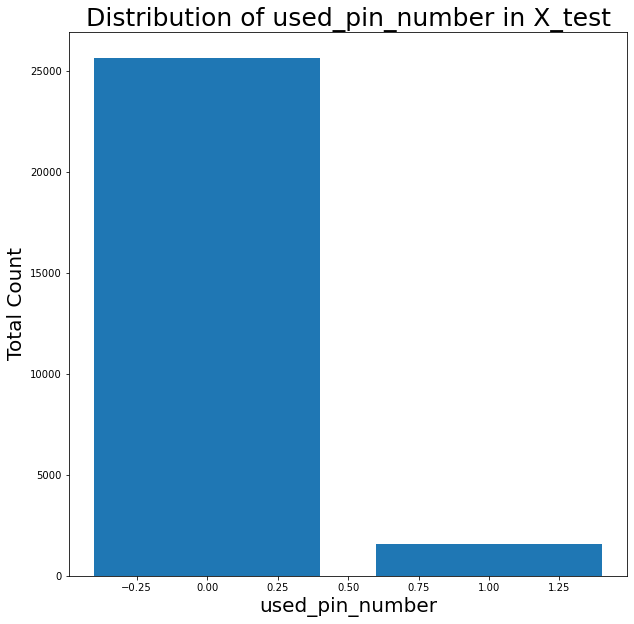

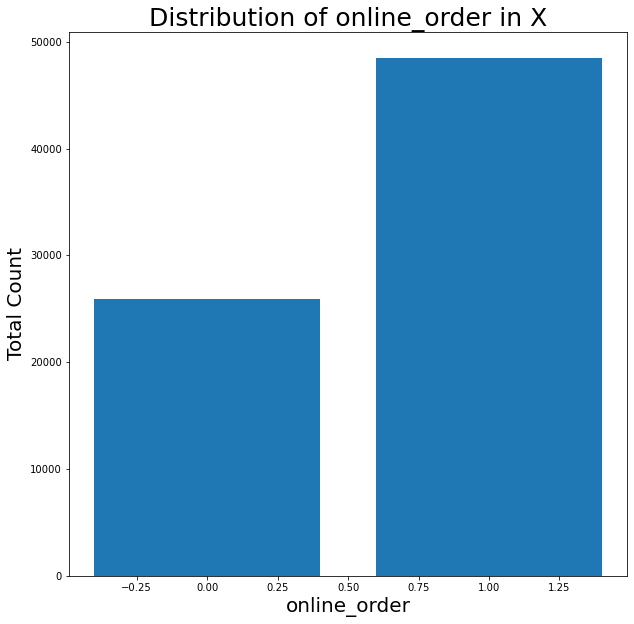

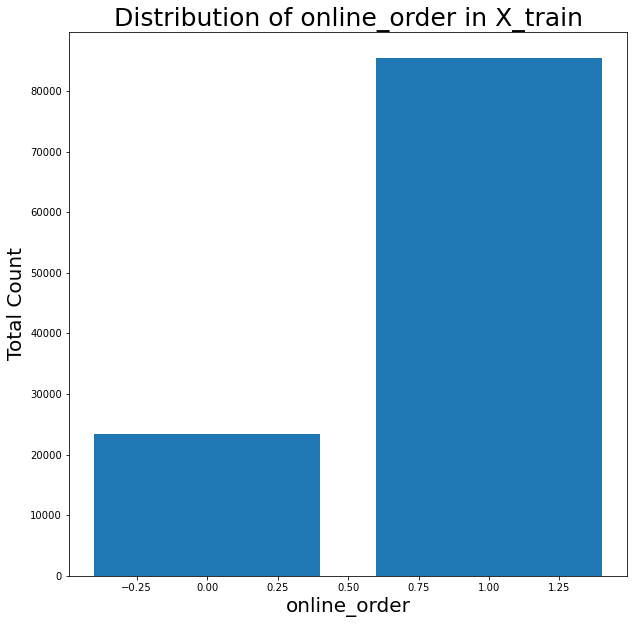

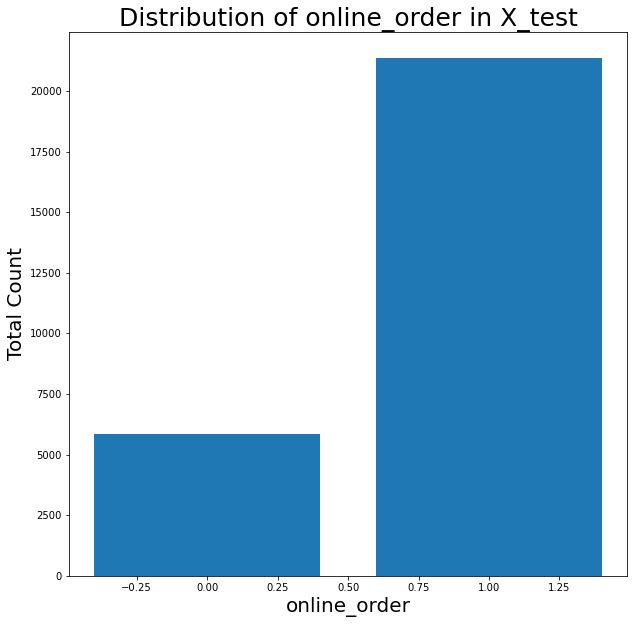

In [43]:
# categorical explanatory variables
for col in cols_categorical:
    for name, data in dict_data.items():
        fig, ax = plt.subplots(figsize = (10,10))
        true_ct = list(data[col]).count(True)
        false_ct = list(data[col]).count(False)
        plt.bar([True, False], height = [true_ct, false_ct])
        ax.set_ylabel('Total Count', fontsize = 20)
        ax.set_xlabel(f'{col}', fontsize = 20)
        ax.set_title(f'Distribution of {col} in {name}', fontsize = 25)
        plt.show()

## PCA Fit/Transformation of Continuous Data (all potential explanatory variables)

In [44]:
pca_train_data = X_train_model[cols_continuous]

In [45]:
# for baseline logistic regression model ONLY
pca_cc_trans_expl_norm = PCA(n_components = 3)

In [46]:
pca_vars = pca_cc_trans_expl_norm.fit_transform(pca_train_data)

In [47]:
# 2 components does not capture 95+% of the variation, 
# therefore keep all 3 continuous explanatory variables (no PCA fit/transformation req'd)
pca_cc_trans_expl_norm.explained_variance_ratio_

array([0.6266203 , 0.19649538, 0.17688432])

In [48]:
# check for multicollinearity of continuous explanatory variables (since non-PCA will be utilized for modeling)
corr_mat[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']]
# no multicollinearity!

distance_from_home  \
distance_from_home                        1.000000   
distance_from_last_transaction           -0.003268   
ratio_to_median_purchase_price           -0.002571   
repeat_retailer                           0.141725   
used_chip                                -0.004805   
used_pin_number                           0.004309   
online_order                             -0.000338   
fraud                                     0.186338   

                                distance_from_last_transaction  \
distance_from_home                                   -0.003268   
distance_from_last_transaction                        1.000000   
ratio_to_median_purchase_price                       -0.000245   
repeat_retailer                                      -0.006252   
used_chip                                            -0.001789   
used_pin_number                                       0.004330   
online_order                                         -0.001822   
fraud                                                 0.095101   

                                ratio_to_median_purchase_price  
distance_from_home                                   -0.002571  
distance_from_last_transaction                       -0.000245  
ratio_to_median_purchase_price                        1.000000  
repeat_retailer                                      -0.002201  
used_chip                                             0.002879  
used_pin_number                                       0.000756  
online_order                                          0.000882  
fraud                                                 0.451454

# Logistic Regression Modeling (Baseline)

## Non-PCA continuous explanatory variables (no regularization)

In [49]:
lrm_expl_vars_train = X_train_model[cols_continuous]

In [50]:
lrm = LogisticRegression(random_state = 0).fit(lrm_expl_vars_train, y_train)

In [51]:
lrm_expl_vars_test = X_test_model[cols_continuous]

In [52]:
y_pred_test = lrm.predict(lrm_expl_vars_test)

In [53]:
y_pred_train = lrm.predict(lrm_expl_vars_train)

In [54]:
# scores for train dataset
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

       False       0.89      0.91      0.90     54406
        True       0.91      0.89      0.90     54405

    accuracy                           0.90    108811
   macro avg       0.90      0.90      0.90    108811
weighted avg       0.90      0.90      0.90    108811



In [55]:
print(recall_score(y_train, y_pred_train))

0.8919952210274791


In [56]:
# scores for test dataset
print(classification_report(y_test, y_pred_test))
# recall for 'True' class is ~98%, i.e., 98% of TPs are predicted correctly with respect to TPs & FNs (aggregate)
# this recall score is acceptable for a fraud detection model
# further modeling is needed to ensure most viable model is implemented

              precision    recall  f1-score   support

       False       0.97      0.86      0.91     13601
        True       0.88      0.98      0.92     13602

    accuracy                           0.92     27203
   macro avg       0.92      0.92      0.92     27203
weighted avg       0.92      0.92      0.92     27203



In [57]:
print(recall_score(y_test, y_pred_test))

0.9763270107337156


## PCA continuous explanatory variables (no regularization)

In [58]:
pca_test_data = X_test_model[cols_continuous]

In [59]:
# transform test dataset to PCA space of train dataset
pca_vars_test = pca_cc_trans_expl_norm.transform(pca_test_data)

In [60]:
lrm_pca = LogisticRegression(random_state = 0).fit(pca_vars, y_train)

In [61]:
y_pred_pca_train = lrm_pca.predict(pca_vars)

In [62]:
y_pred_pca_test = lrm_pca.predict(pca_vars_test)

In [63]:
# scores for train dataset
print(classification_report(y_train, y_pred_pca_train))

              precision    recall  f1-score   support

       False       0.89      0.91      0.90     54406
        True       0.91      0.89      0.90     54405

    accuracy                           0.90    108811
   macro avg       0.90      0.90      0.90    108811
weighted avg       0.90      0.90      0.90    108811



In [64]:
print(recall_score(y_train, y_pred_pca_train))

0.8919952210274791


In [65]:
# scores for test dataset
print(classification_report(y_test, y_pred_pca_test))
# recall for 'True' class is still ~98% (with PCA applied), i.e., 98% of TPs are predicted correctly 
# with respect to TPs & FNs (aggregate), this recall score is acceptable for a fraud detection model, however
# further modeling is needed to ensure most viable model is implemented

              precision    recall  f1-score   support

       False       0.97      0.86      0.91     13601
        True       0.88      0.98      0.92     13602

    accuracy                           0.92     27203
   macro avg       0.92      0.92      0.92     27203
weighted avg       0.92      0.92      0.92     27203



In [66]:
print(recall_score(y_test, y_pred_pca_test))

0.9763270107337156


## Non-PCA continuous explanatory variables (with L2 regularization)

In [67]:
lrm_l2 = LogisticRegression(random_state = 0, penalty = 'l2').fit(lrm_expl_vars_train, y_train)

In [68]:
y_pred_test_l2 = lrm_l2.predict(lrm_expl_vars_test)

In [69]:
y_pred_train_l2 = lrm.predict(lrm_expl_vars_train)

In [70]:
# scores for train dataset
print(classification_report(y_train, y_pred_train_l2))

              precision    recall  f1-score   support

       False       0.89      0.91      0.90     54406
        True       0.91      0.89      0.90     54405

    accuracy                           0.90    108811
   macro avg       0.90      0.90      0.90    108811
weighted avg       0.90      0.90      0.90    108811



In [71]:
print(recall_score(y_train, y_pred_train_l2))

0.8919952210274791


In [72]:
# scores for test dataset
print(classification_report(y_test, y_pred_test_l2))
# recall for 'True' class is ~98%, i.e., 98% of TPs are predicted correctly with respect to TPs & FNs (aggregate)
# this recall score is acceptable for a fraud detection model
# further modeling is needed to ensure most viable model is implemented

              precision    recall  f1-score   support

       False       0.97      0.86      0.91     13601
        True       0.88      0.98      0.92     13602

    accuracy                           0.92     27203
   macro avg       0.92      0.92      0.92     27203
weighted avg       0.92      0.92      0.92     27203



In [73]:
print(recall_score(y_test, y_pred_test_l2))

0.9763270107337156


## PCA continuous explanatory variables (with L2 regularization)

In [74]:
lrm_pca_l2 = LogisticRegression(random_state = 0, penalty = 'l2').fit(pca_vars, y_train)

In [75]:
y_pred_pca_train_l2 = lrm_pca_l2.predict(pca_vars)

In [76]:
y_pred_pca_test_l2 = lrm_pca_l2.predict(pca_vars_test)

In [77]:
# scores for train dataset
print(classification_report(y_train, y_pred_pca_train_l2))

              precision    recall  f1-score   support

       False       0.89      0.91      0.90     54406
        True       0.91      0.89      0.90     54405

    accuracy                           0.90    108811
   macro avg       0.90      0.90      0.90    108811
weighted avg       0.90      0.90      0.90    108811



In [78]:
print(recall_score(y_train, y_pred_pca_train_l2))

0.8919952210274791


In [79]:
# scores for test dataset
print(classification_report(y_test, y_pred_pca_test_l2))
# recall for 'True' class is still ~98% (with PCA/L2 regularization applied), 
# i.e., 98% of TPs are predicted correctly with respect to TPs & FNs (aggregate), 
# this recall score is acceptable for a fraud detection model, however 
# further modeling is needed to ensure most viable model is implemented

              precision    recall  f1-score   support

       False       0.97      0.86      0.91     13601
        True       0.88      0.98      0.92     13602

    accuracy                           0.92     27203
   macro avg       0.92      0.92      0.92     27203
weighted avg       0.92      0.92      0.92     27203



In [80]:
print(recall_score(y_test, y_pred_pca_test_l2))

0.9763270107337156


## Plot Precision-Recall Curves - calculate/compare AUC-PR

/home/jonathon/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/jonathon/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/home/jonathon/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecate

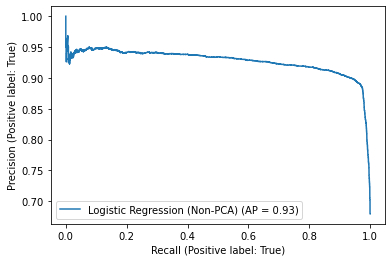

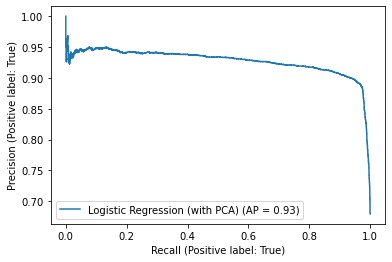

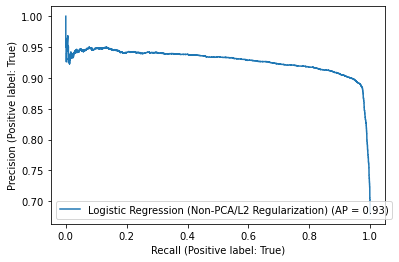

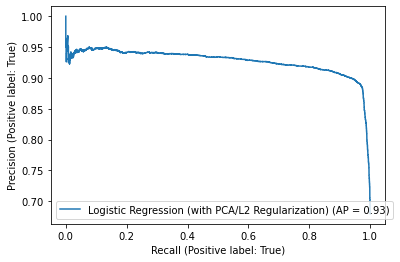

In [81]:
# logistic regression model (non-PCA)
plot_precision_recall_curve(lrm, lrm_expl_vars_test, y_test, name = 'Logistic Regression (Non-PCA)')
# logistic regression model (with PCA)
plot_precision_recall_curve(lrm_pca, pca_vars_test, y_test, name = 'Logistic Regression (with PCA)')
# logistic regression model (non-PCA/L2 Regularization)
plot_precision_recall_curve(lrm_l2, lrm_expl_vars_test, y_test, name = 'Logistic Regression (Non-PCA/L2 Regularization)')
# logistic regression model (with PCA/L2 Regularization)
plot_precision_recall_curve(lrm_pca_l2, pca_vars_test, y_test, name = 'Logistic Regression (with PCA/L2 Regularization)')
plt.show()

In [82]:
# save simplest Logistic Regression model, i.e., no regularization and non-PCA (all perform similarly)
pickle.dump(lrm, open('models/logisticregression_cc_trans.pkl', 'wb'))

## FAMD Fit/Transformation of Data (all potential explanatory variables) - in preparation for additional classification modeling

In [83]:
# perform FAMD on given explanatory data
famd_cc_trans = FAMD(n_components = 7, n_iter = 10, random_state = 101)

In [84]:
X_train_famd = X_train_model

In [85]:
# fit train dataset
famd_cc_trans.fit(X_train_famd)

FAMD(n_components=7, n_iter=10, random_state=101)

In [86]:
# transform train dataset
X_train_famd_transformed = famd_cc_trans.transform(X_train_famd)
X_train_famd_transformed

0         1         2         3         4         5         6
0       1.008296 -0.692298  0.271160 -0.506823  0.423653 -0.108133 -0.056808
1       0.891138 -0.121830  0.258739 -0.851184 -0.320161 -0.018982 -0.053433
2       0.358460 -0.047302  0.153346 -0.743986 -0.257258 -0.560593  0.010849
3       0.969125  0.187326  0.491631 -0.655803 -0.298827 -0.026442 -0.052020
4       1.068883 -0.849688 -0.101916  0.710073 -0.267631  0.039554 -0.020948
...          ...       ...       ...       ...       ...       ...       ...
108806  0.312639 -0.524331  0.090733 -0.329947 -0.255825 -0.531793  0.020656
108807  0.326144 -2.353196 -0.339880  1.762984 -0.060329  0.675354 -0.018936
108808  0.525003  1.855070  4.415616  1.950853  0.088462  0.545661 -0.048931
108809  1.235952 -0.450997  0.008367 -0.036308  0.460639 -0.113243 -0.048650
108810  0.896910 -0.077411  0.262202 -0.884965 -0.320027 -0.021601 -0.054253

[108811 rows x 7 columns]

<AxesSubplot:title={'center':'Row principal coordinates'}, xlabel='Component 0 (25.25% inertia)', ylabel='Component 1 (25.05% inertia)'>

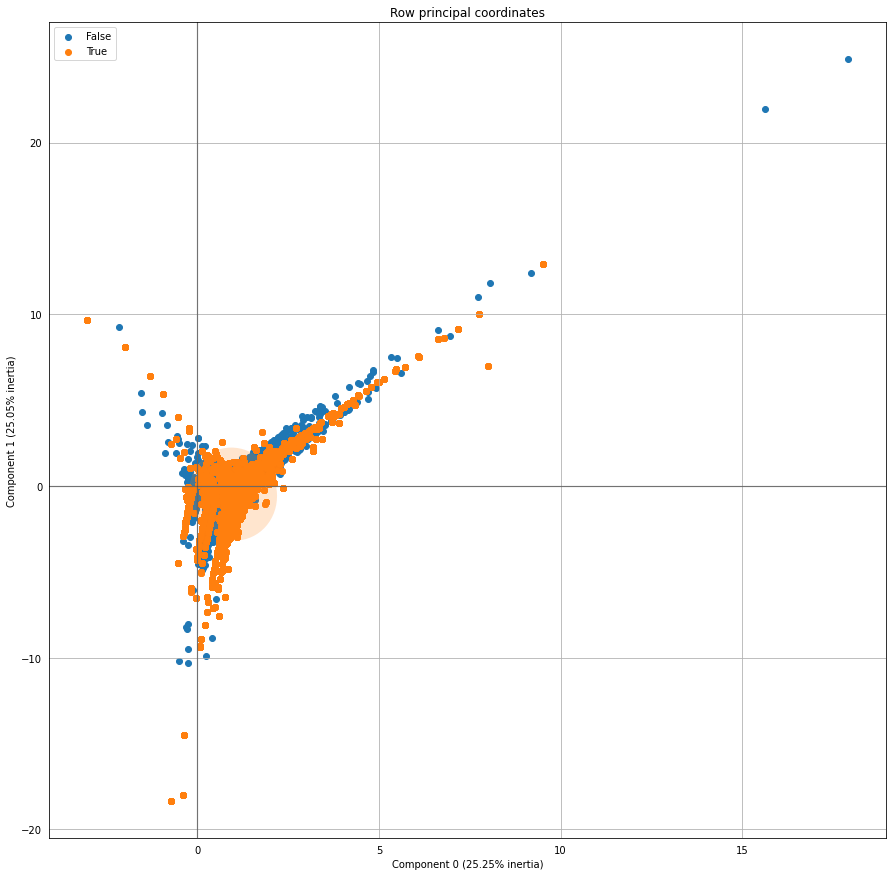

In [87]:
# 50.30% of variation explained...use more components to describe 90%+ of total variation
famd_cc_trans.plot_row_coordinates(X_train_famd, figsize = (15, 15), color_labels = y_train)

In [88]:
# 4 FAMD components explain 90+% of the variation 
famd_cc_trans.explained_inertia_

array([0.25251608, 0.25052757, 0.23308983, 0.20525272, 0.03143912,
       0.01893557, 0.00823911])

In [89]:
# perform FAMD on given explanatory data (4 components only)
famd_cc_trans = FAMD(n_components = 4, n_iter = 10, random_state = 101)

In [90]:
# fit train dataset
famd_cc_trans.fit(X_train_famd)

FAMD(n_components=4, n_iter=10, random_state=101)

In [91]:
# transform train dataset
X_train_famd_transformed = famd_cc_trans.transform(X_train_famd)
X_train_famd_transformed

0         1         2         3
0       1.008296 -0.692298  0.271160 -0.506823
1       0.891138 -0.121830  0.258739 -0.851184
2       0.358460 -0.047302  0.153346 -0.743986
3       0.969125  0.187326  0.491631 -0.655803
4       1.068883 -0.849688 -0.101916  0.710073
...          ...       ...       ...       ...
108806  0.312639 -0.524331  0.090733 -0.329947
108807  0.326144 -2.353196 -0.339880  1.762984
108808  0.525003  1.855070  4.415616  1.950853
108809  1.235952 -0.450997  0.008367 -0.036308
108810  0.896910 -0.077411  0.262202 -0.884965

[108811 rows x 4 columns]

In [92]:
X_test_famd = X_test_model

In [93]:
# transform test dataset
X_test_famd_transformed = famd_cc_trans.transform(X_test_famd)
X_test_famd_transformed

0         1         2         3
0      0.388329  0.046783  0.184631 -0.808888
1      0.234072 -0.026220  0.110442 -0.719568
2      0.496487 -0.874605 -0.067075  0.266119
3      0.601490  0.232628 -0.401943  0.688608
4      0.379488 -0.810491 -0.041011  0.171204
...         ...       ...       ...       ...
27198  0.236685 -0.078342  0.099316 -0.641246
27199  0.220891  0.168011  0.063411 -0.666765
27200  0.414376 -0.396843  0.809776  0.154888
27201  0.142687 -0.772618  0.011724 -0.061740
27202  0.403249  0.019021  0.188585 -0.688195

[27203 rows x 4 columns]

# Classification Modeling (Other)

## KNN

In [94]:
n = round(len(X_train_famd_transformed)**(1/2))
n

330

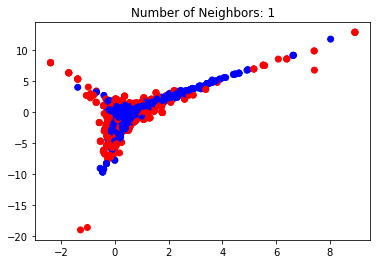

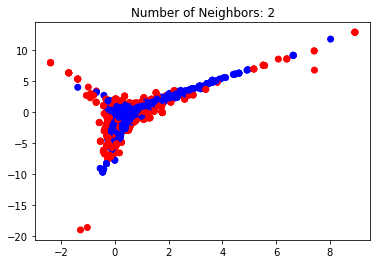

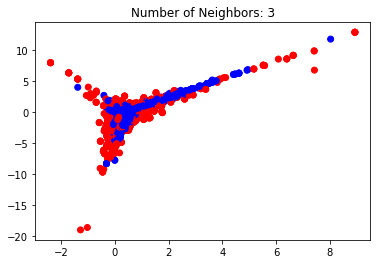

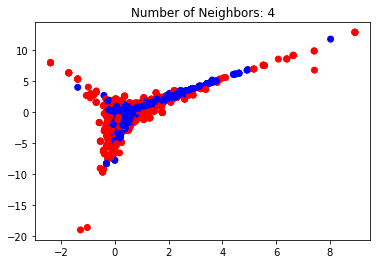

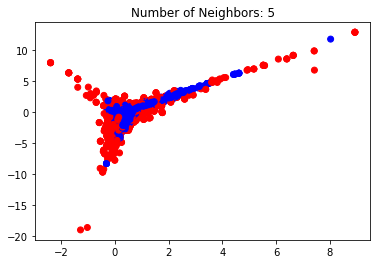

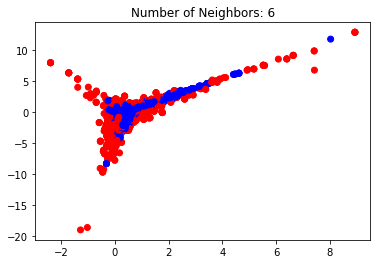

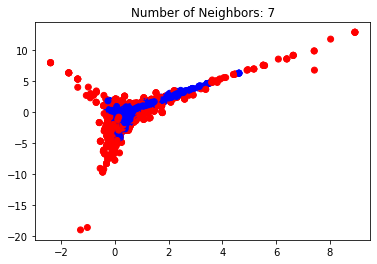

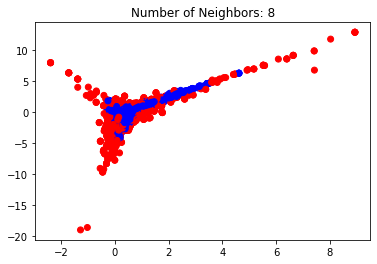

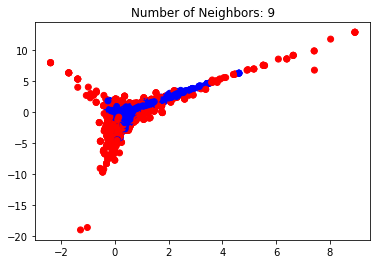

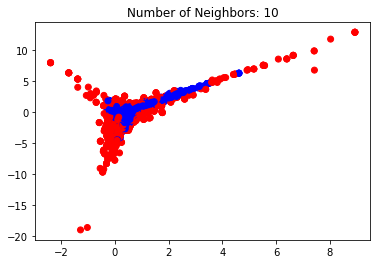

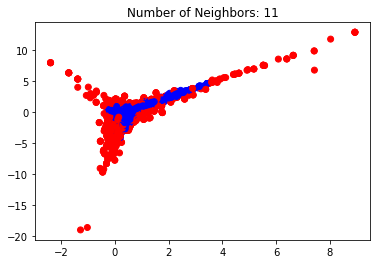

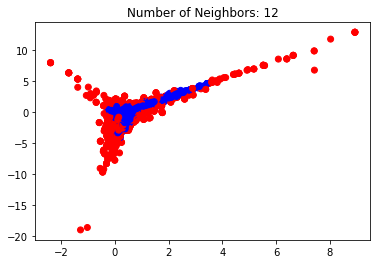

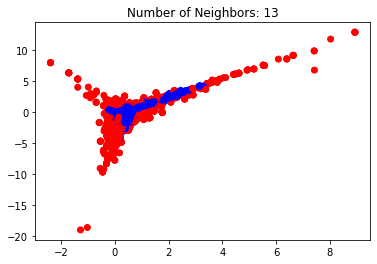

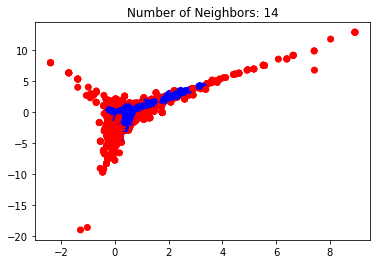

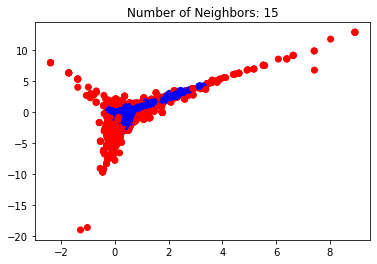

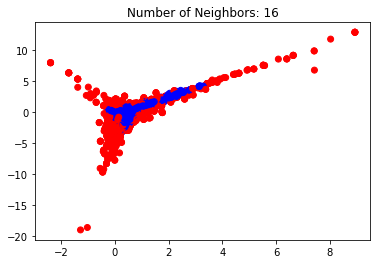

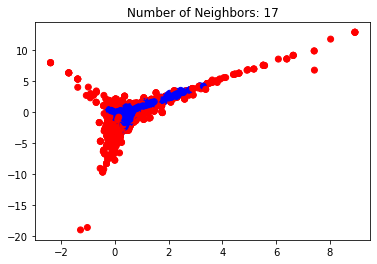

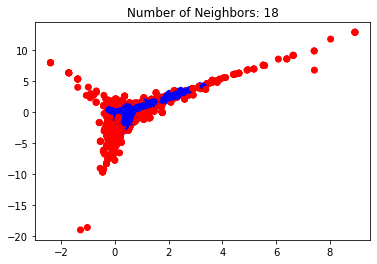

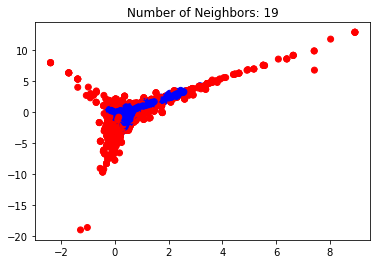

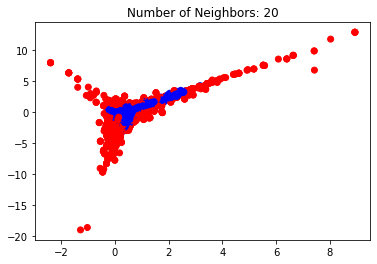

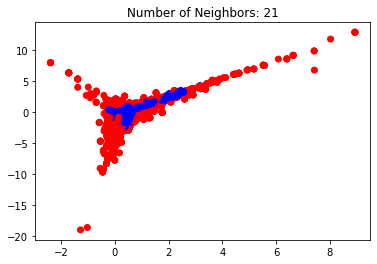

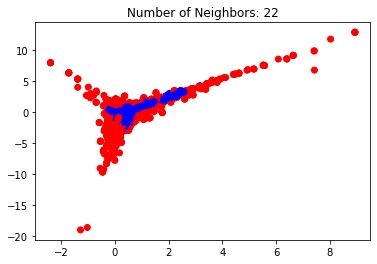

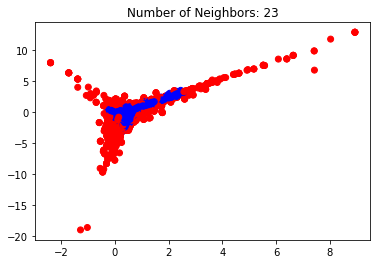

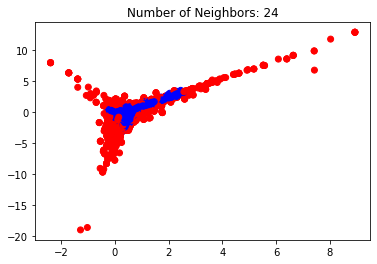

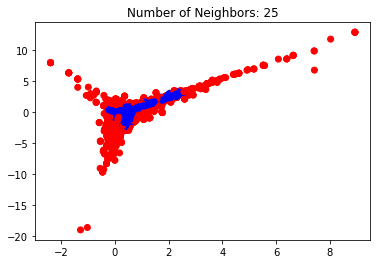

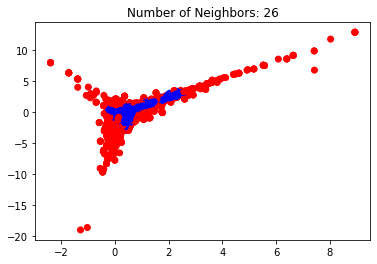

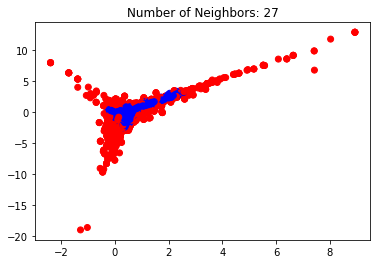

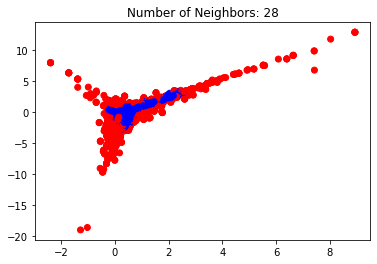

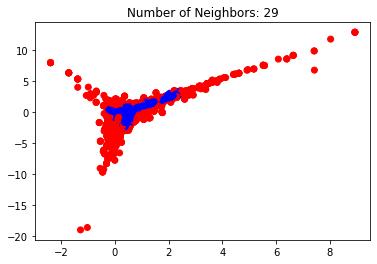

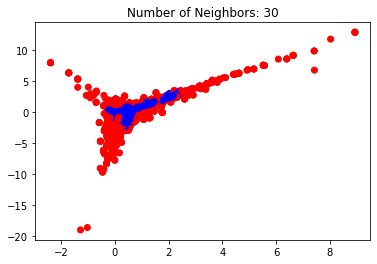

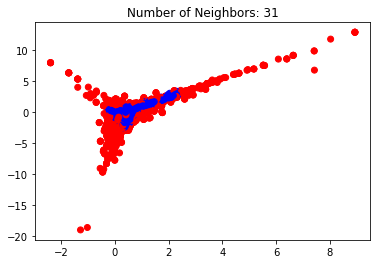

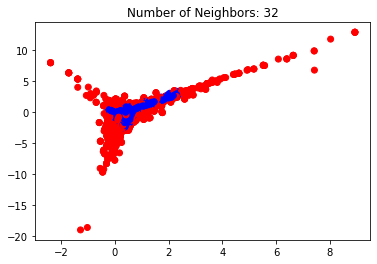

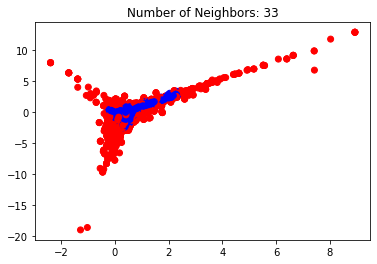

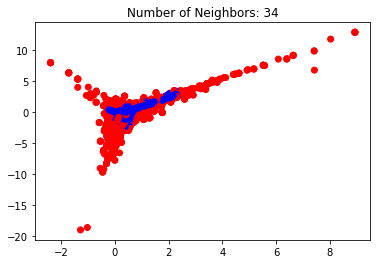

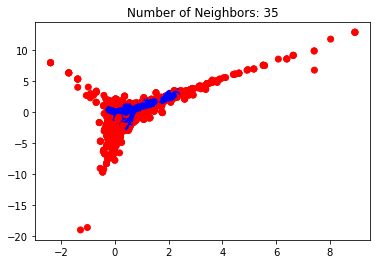

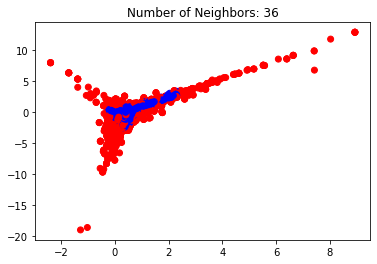

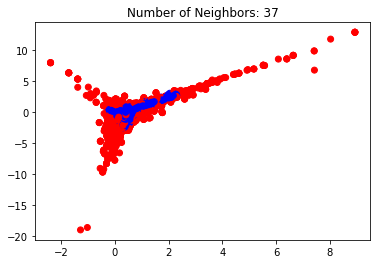

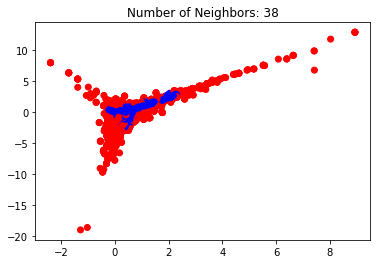

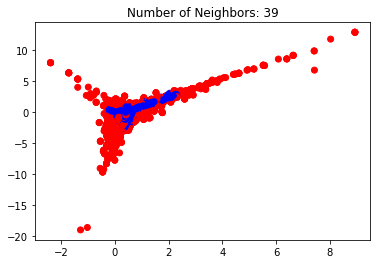

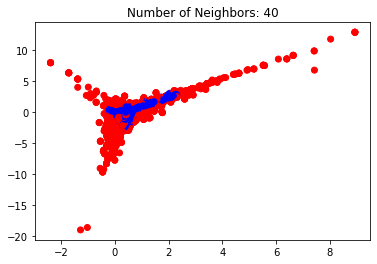

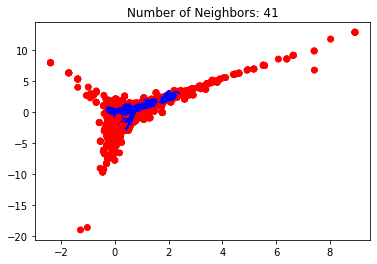

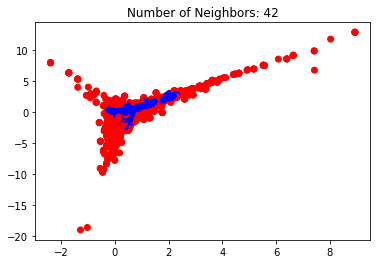

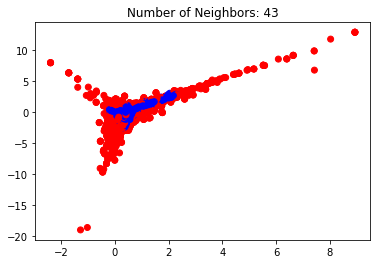

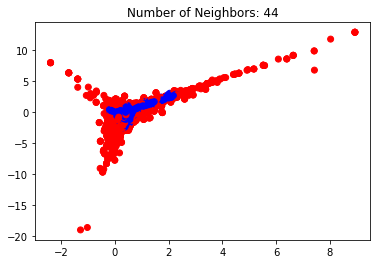

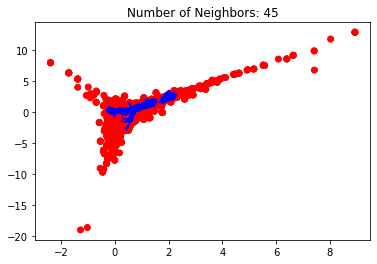

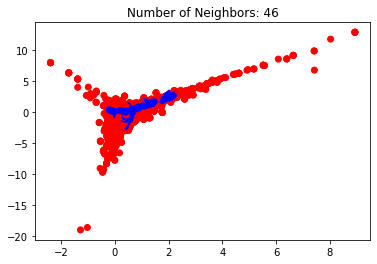

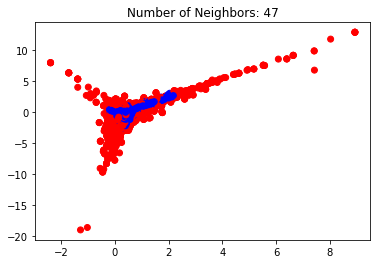

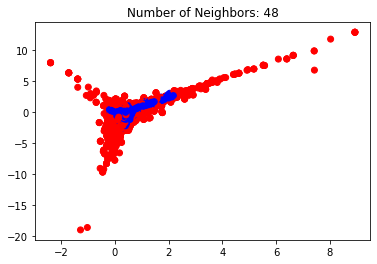

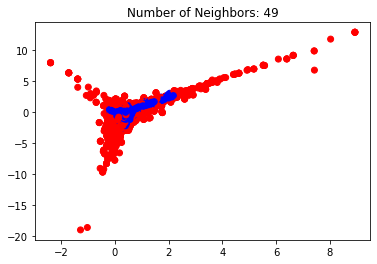

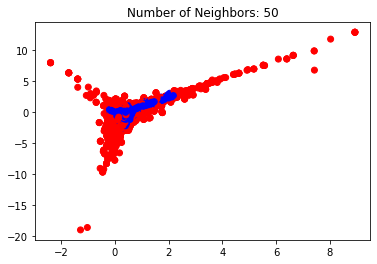

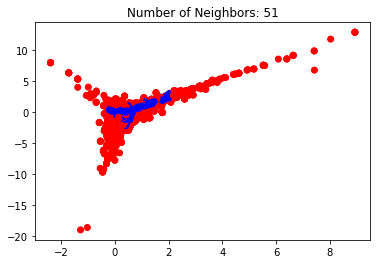

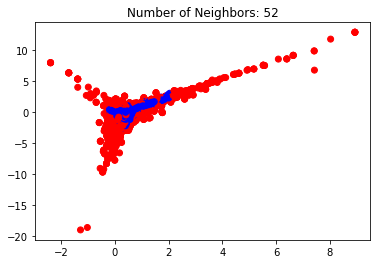

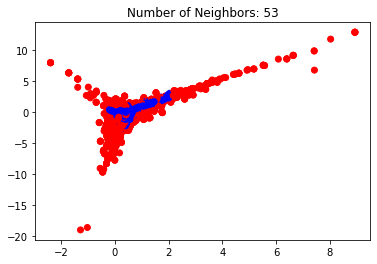

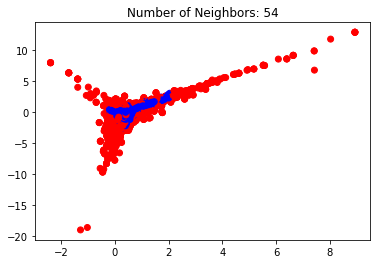

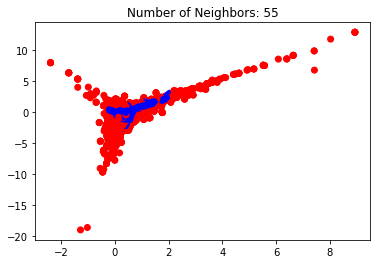

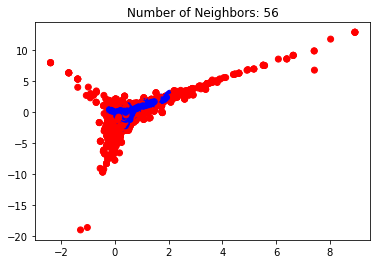

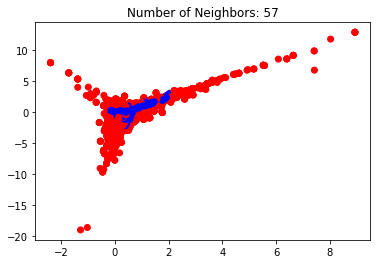

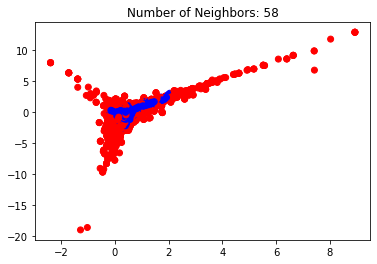

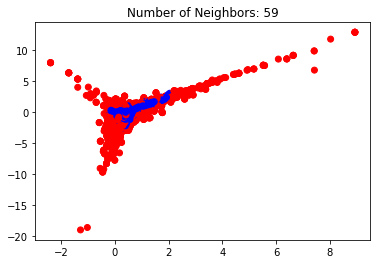

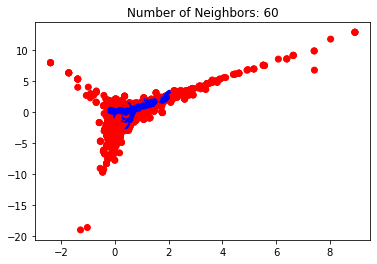

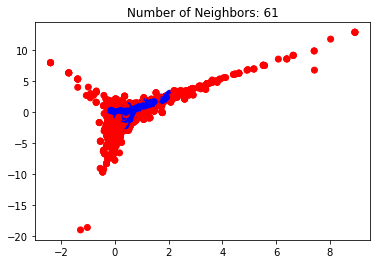

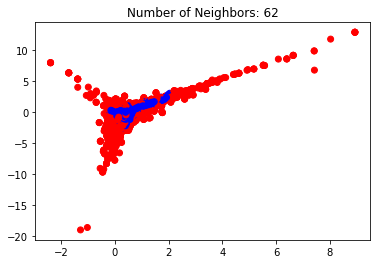

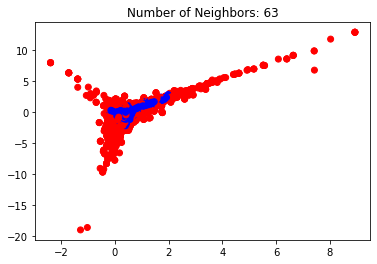

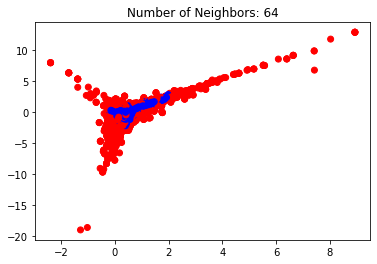

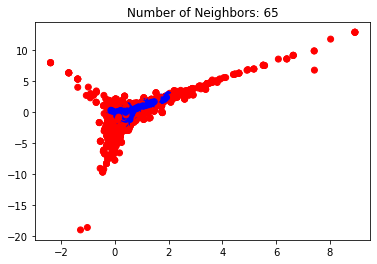

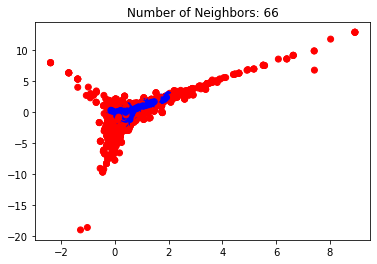

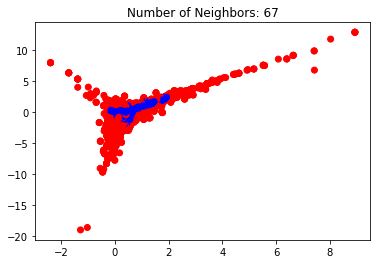

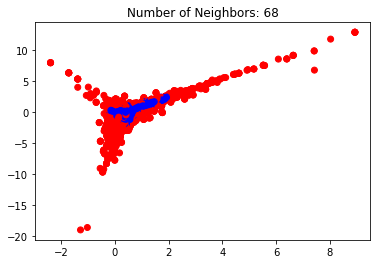

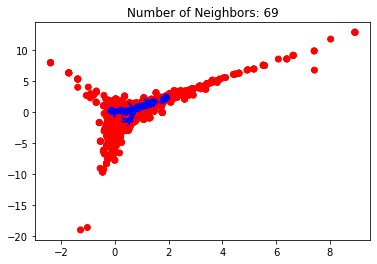

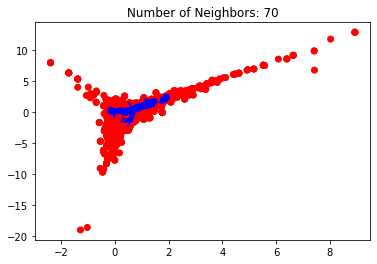

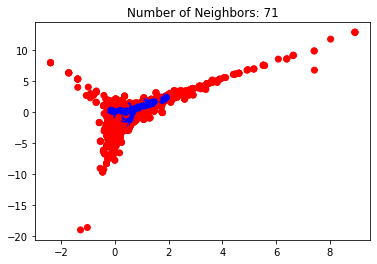

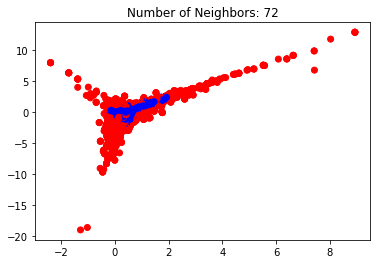

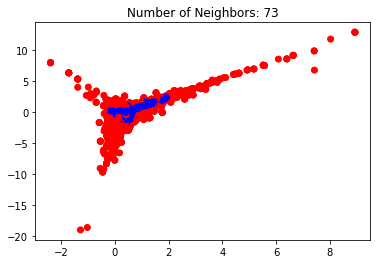

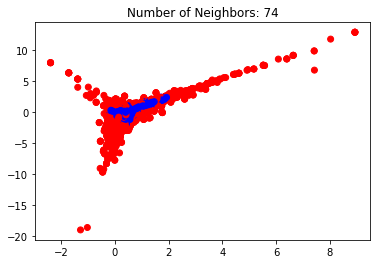

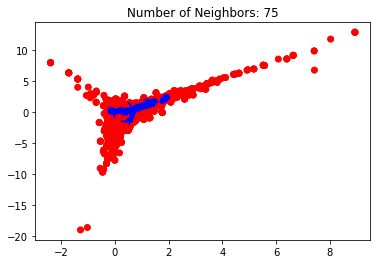

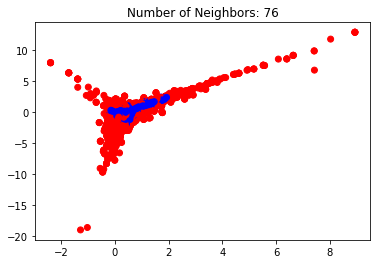

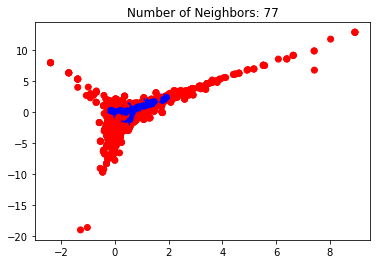

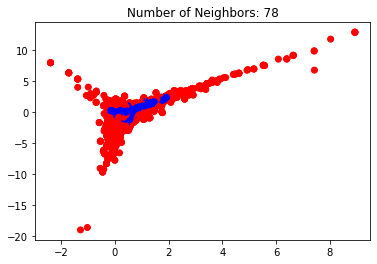

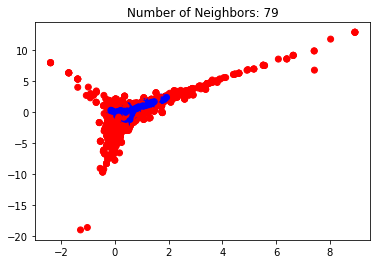

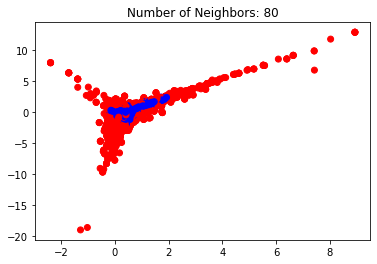

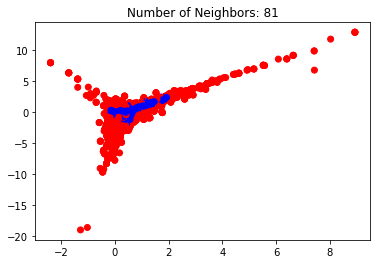

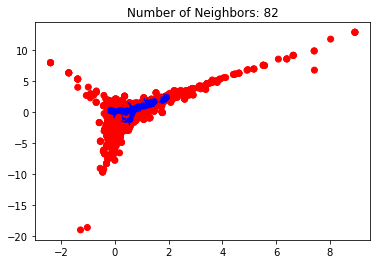

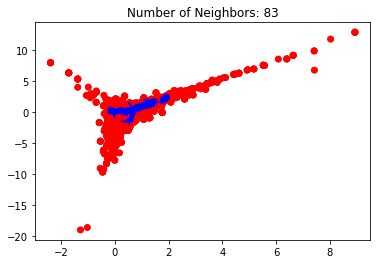

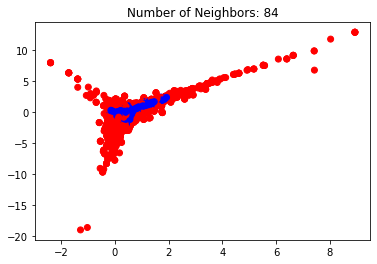

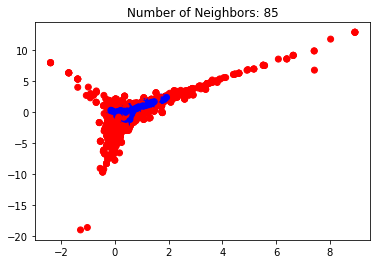

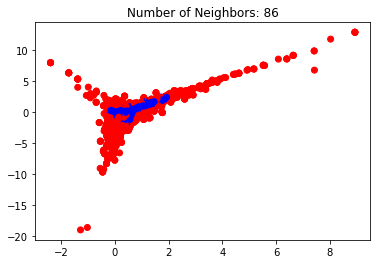

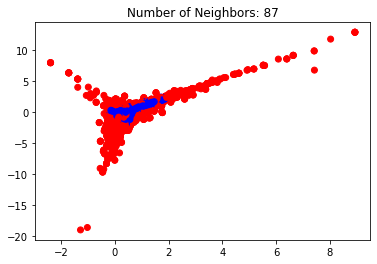

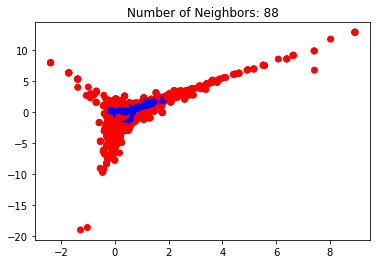

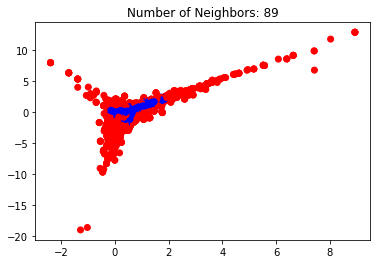

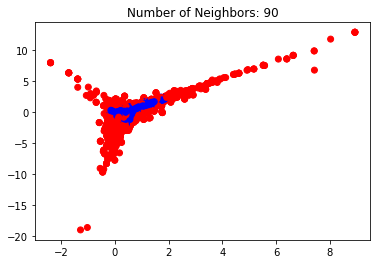

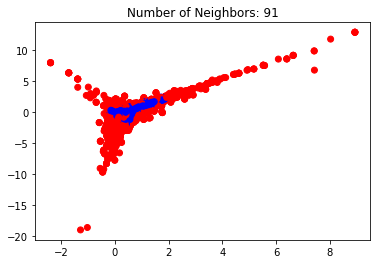

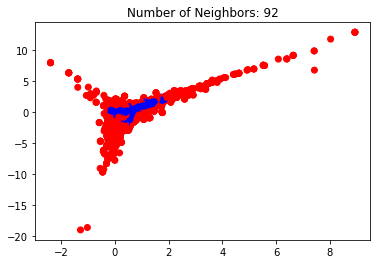

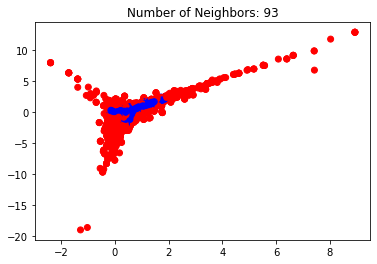

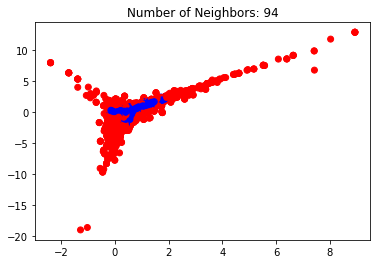

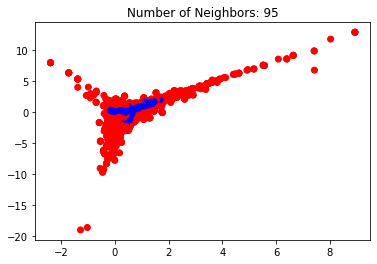

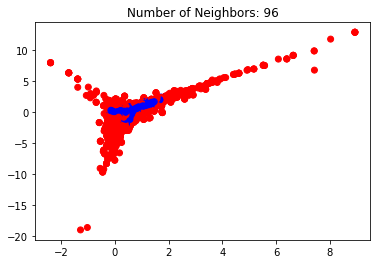

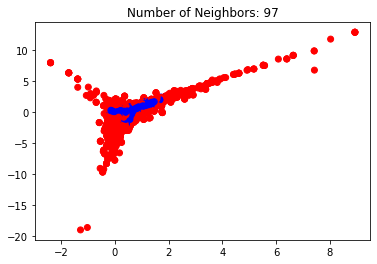

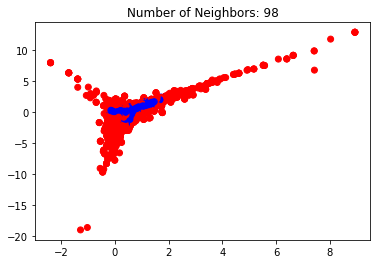

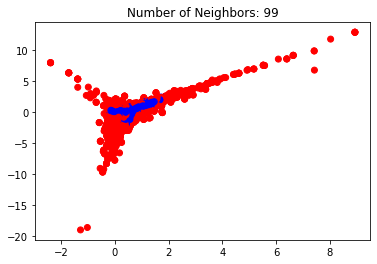

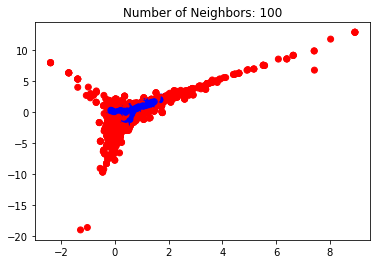

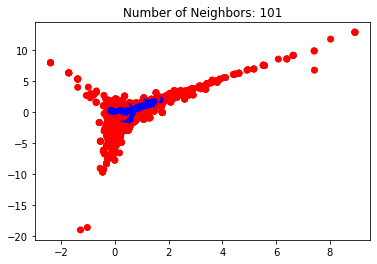

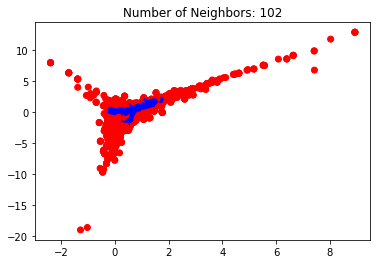

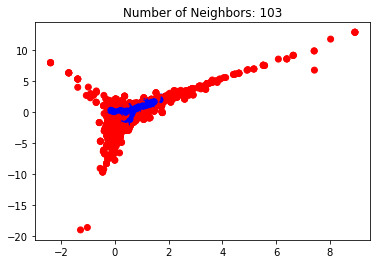

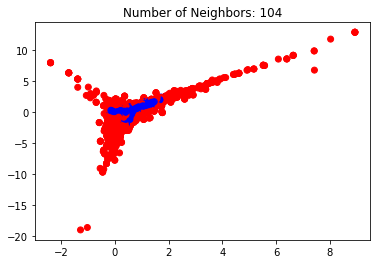

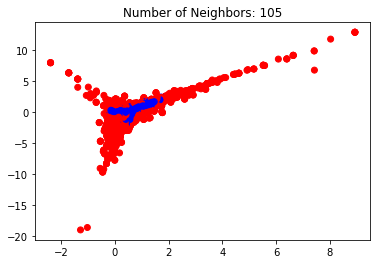

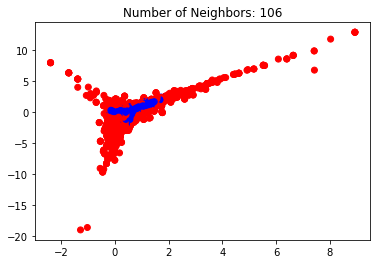

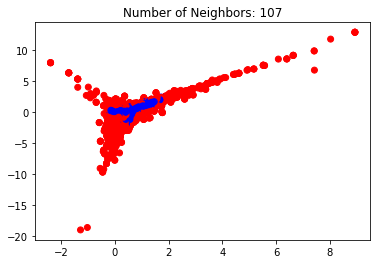

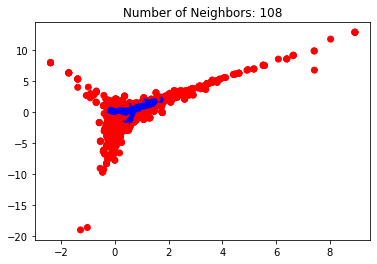

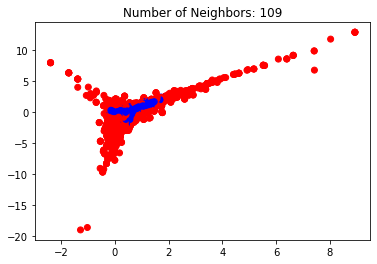

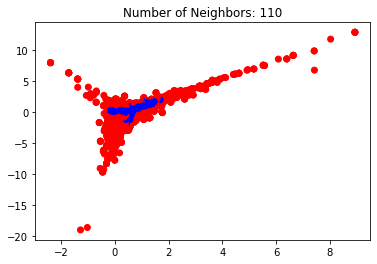

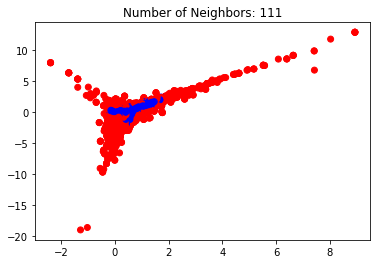

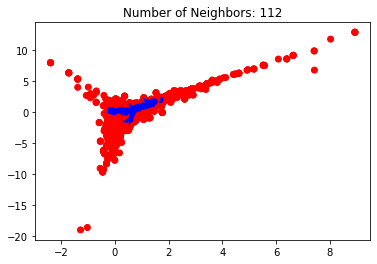

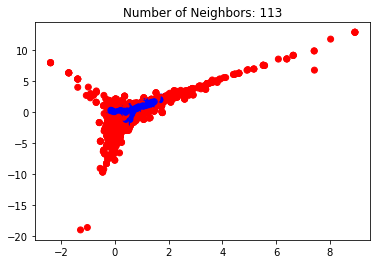

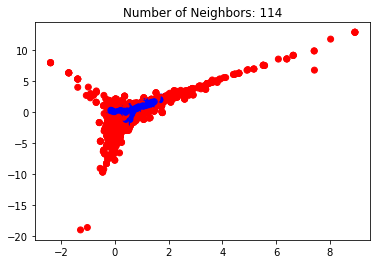

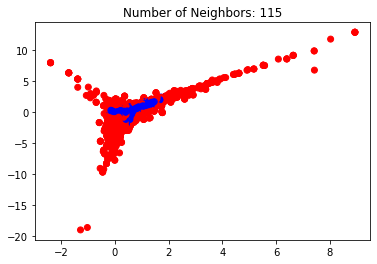

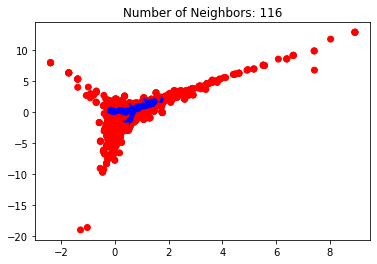

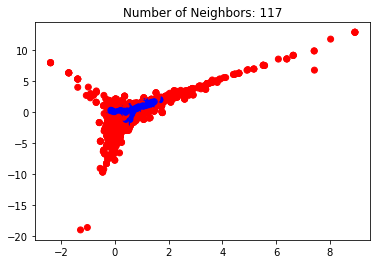

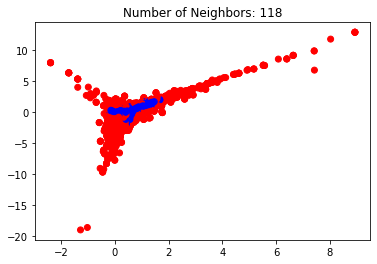

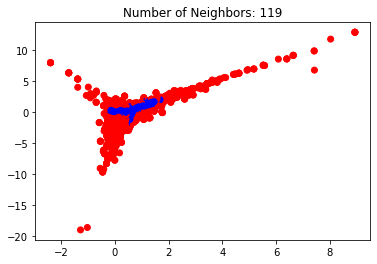

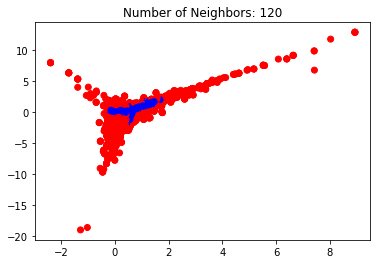

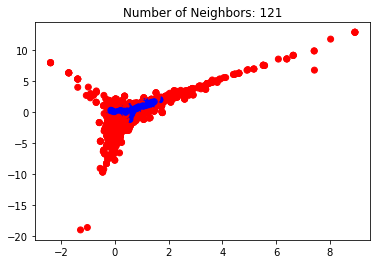

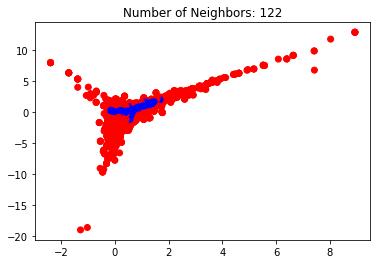

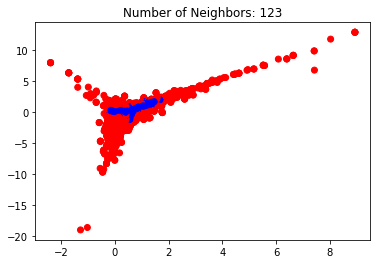

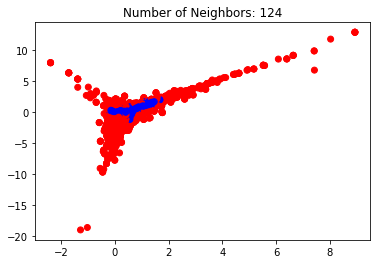

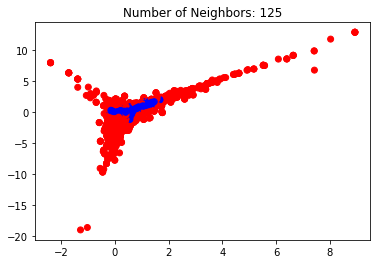

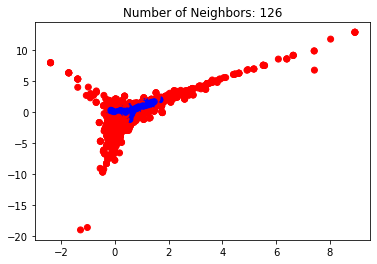

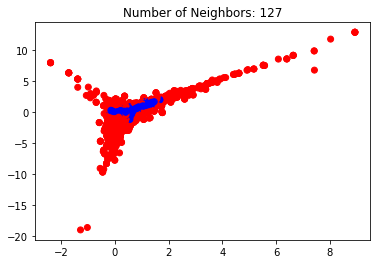

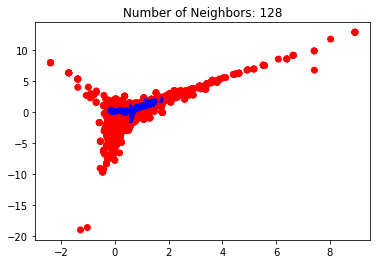

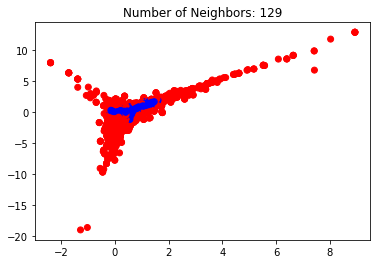

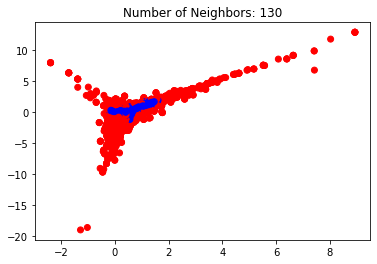

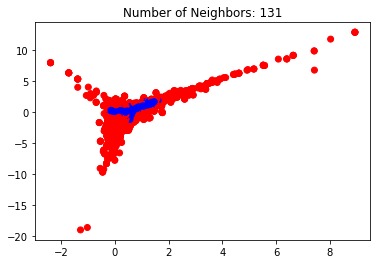

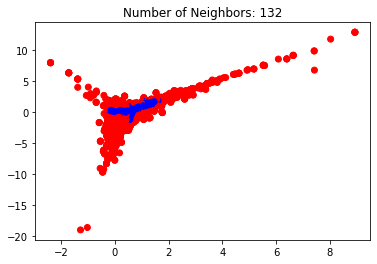

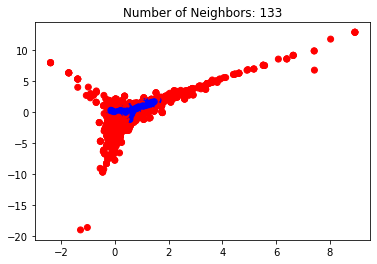

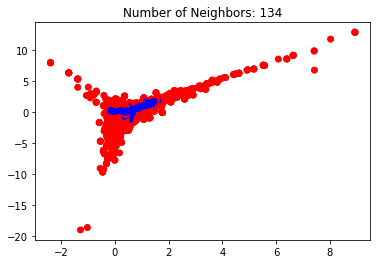

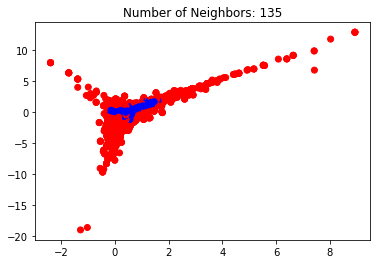

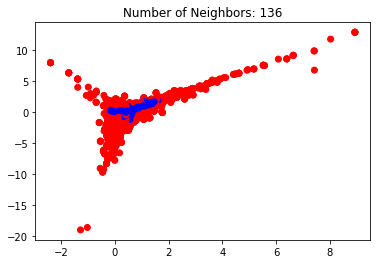

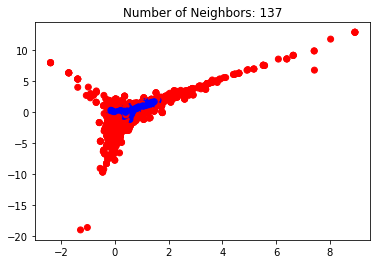

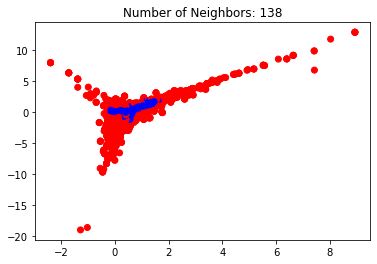

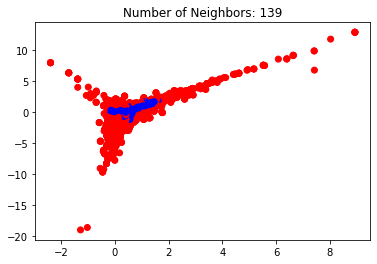

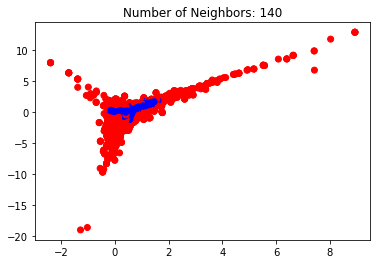

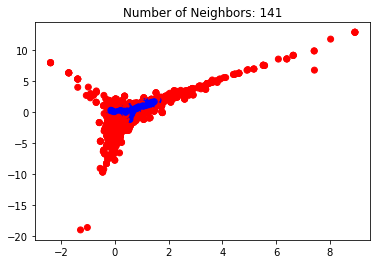

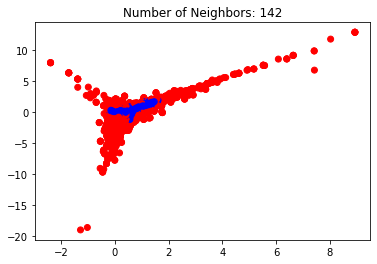

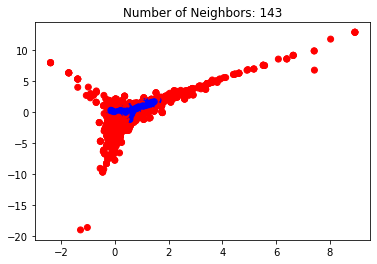

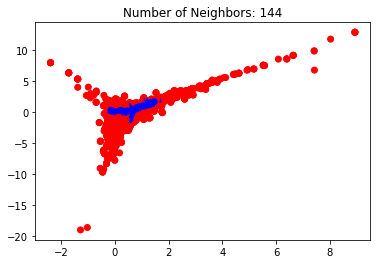

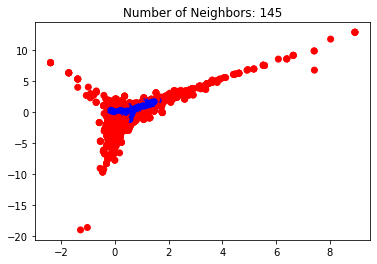

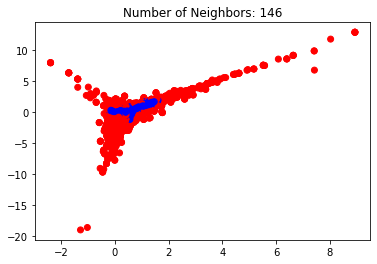

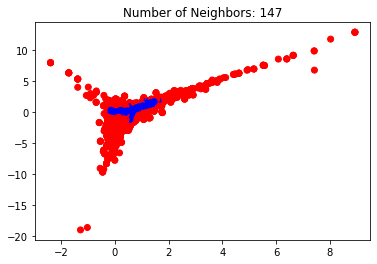

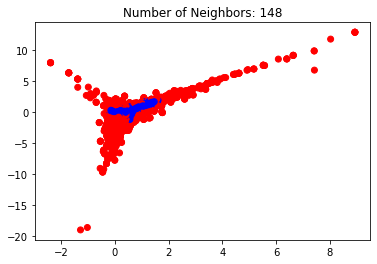

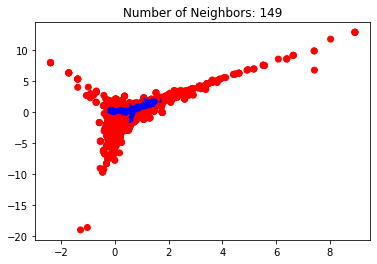

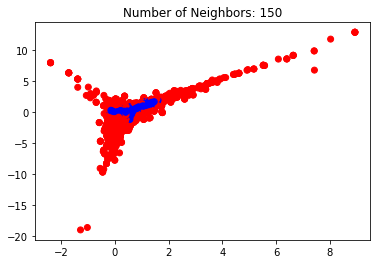

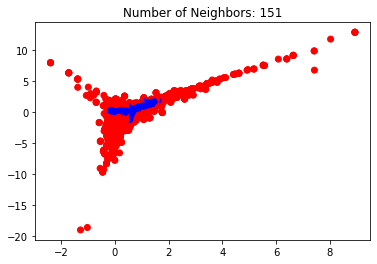

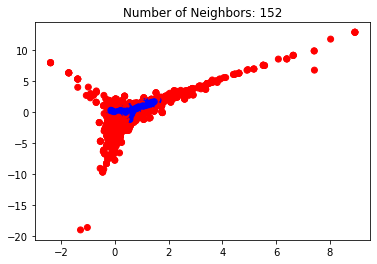

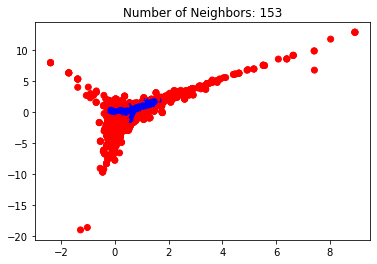

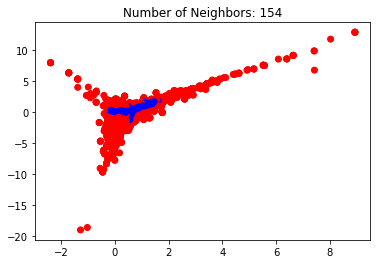

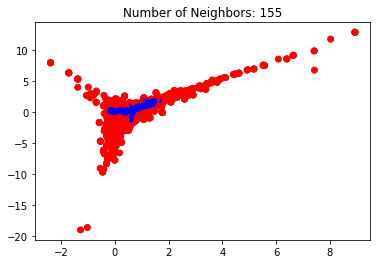

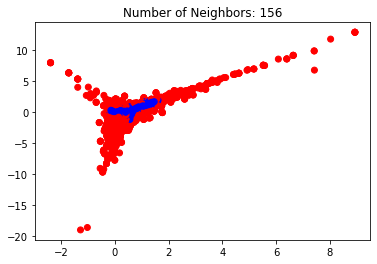

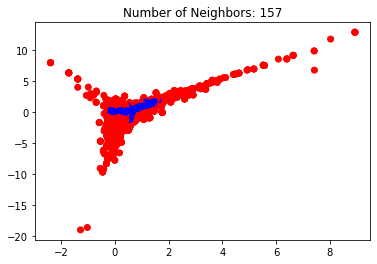

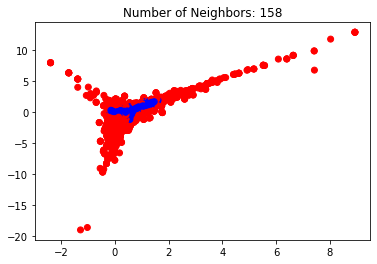

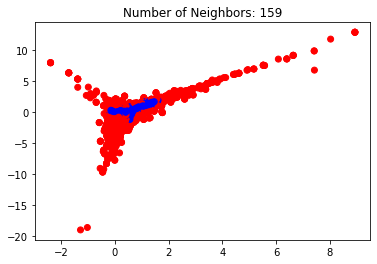

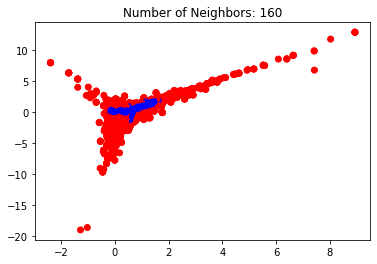

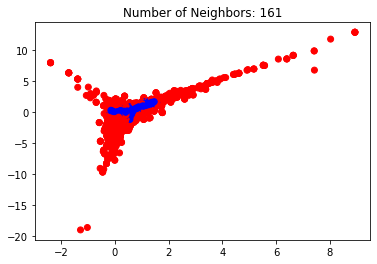

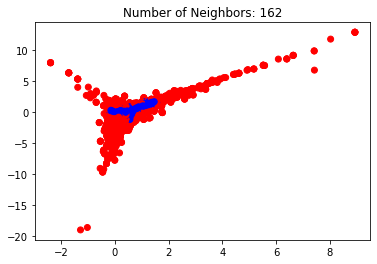

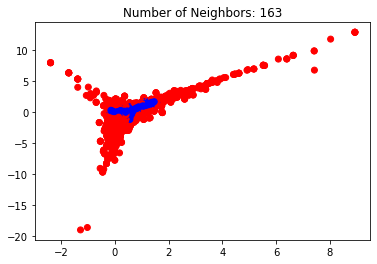

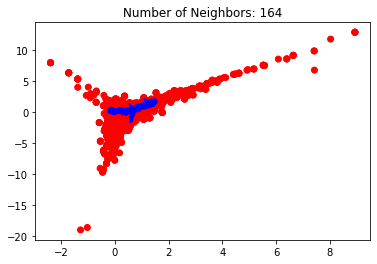

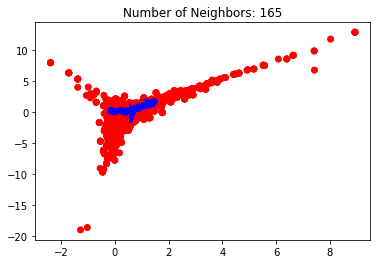

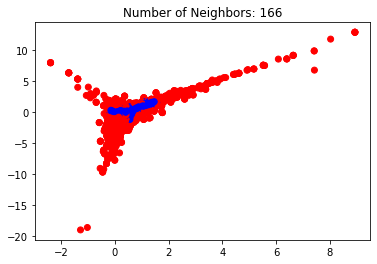

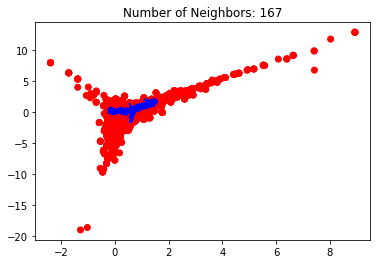

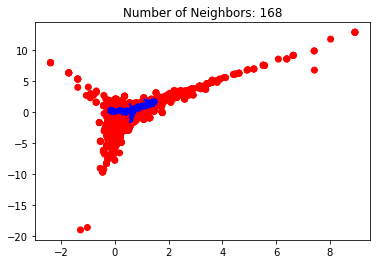

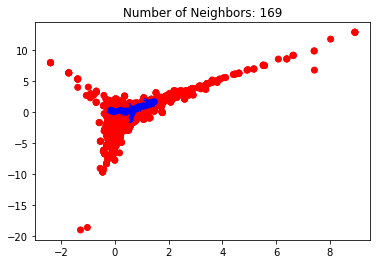

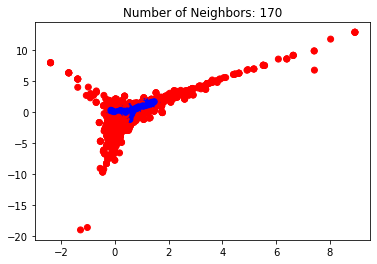

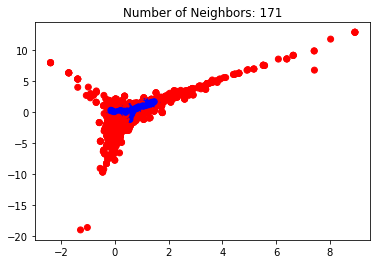

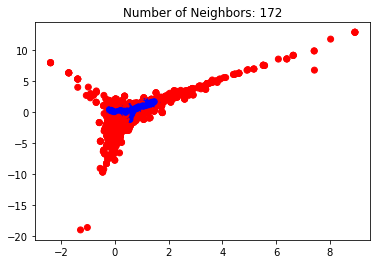

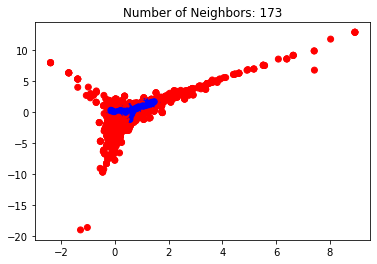

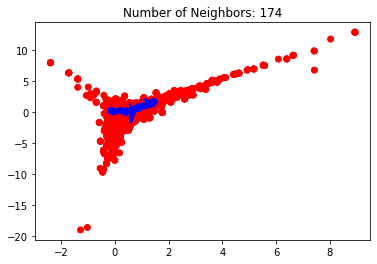

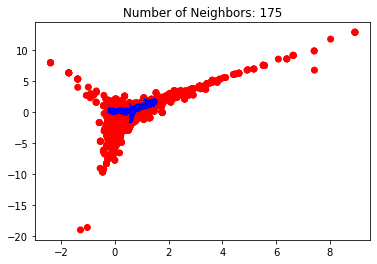

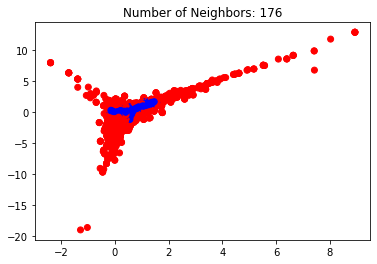

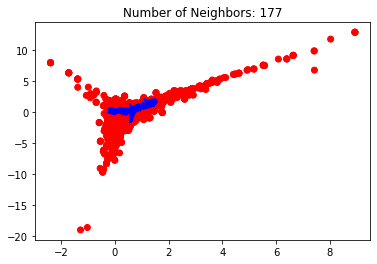

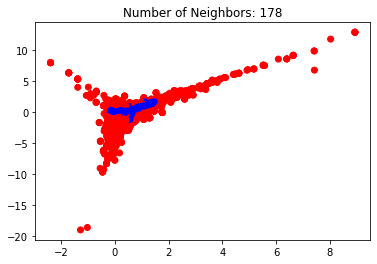

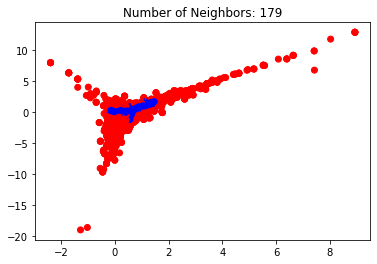

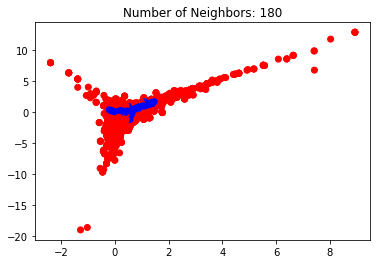

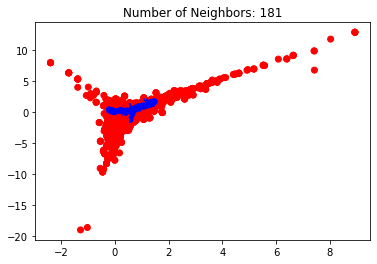

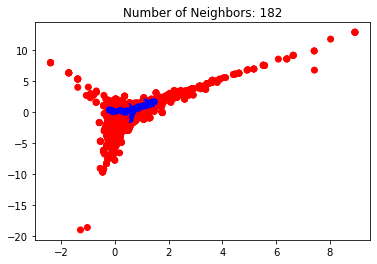

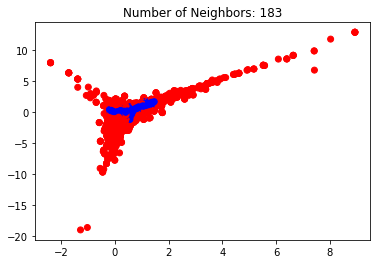

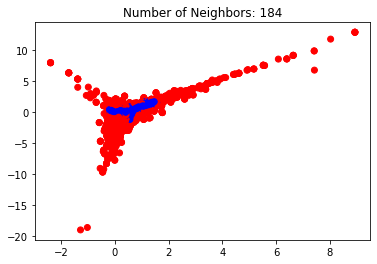

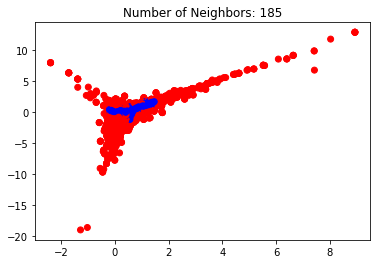

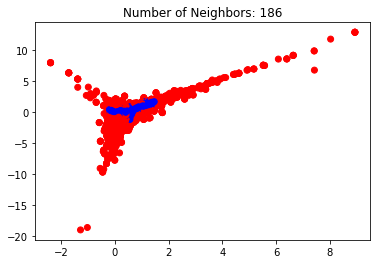

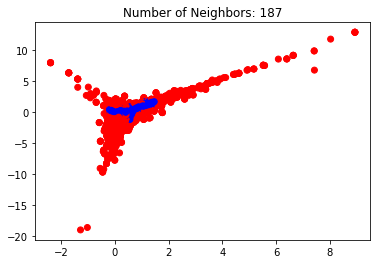

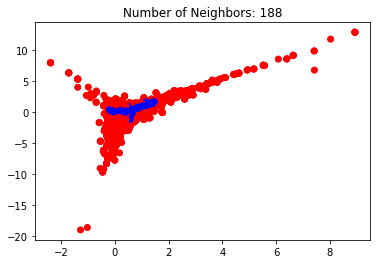

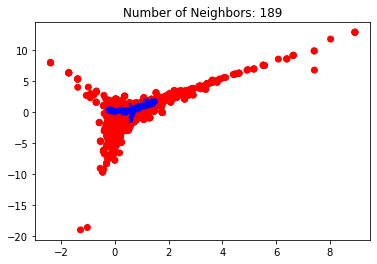

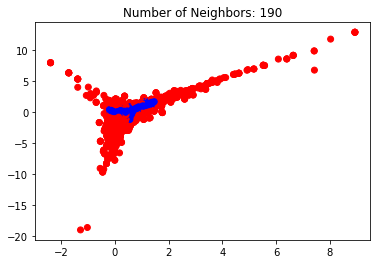

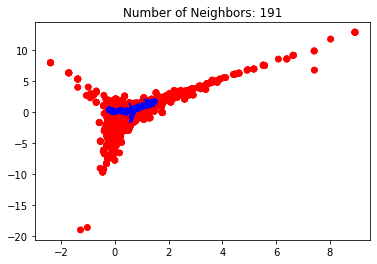

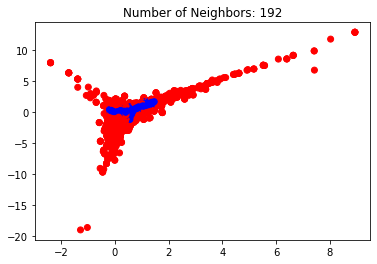

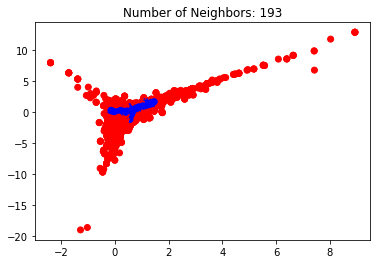

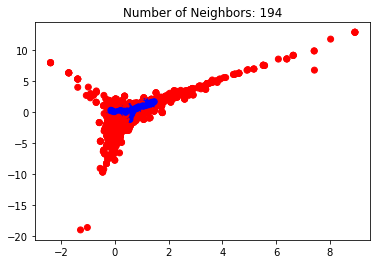

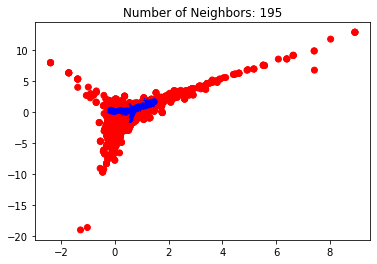

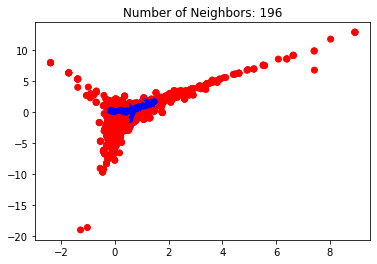

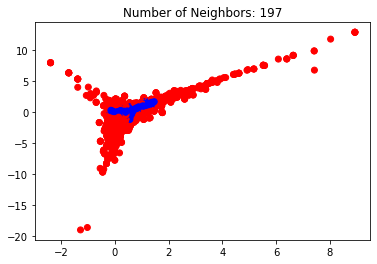

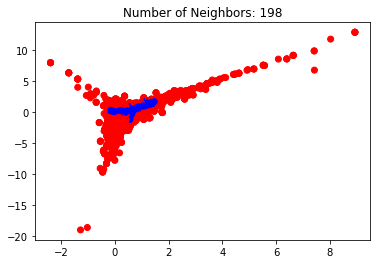

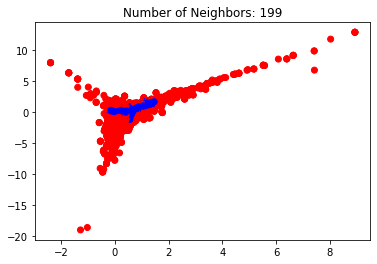

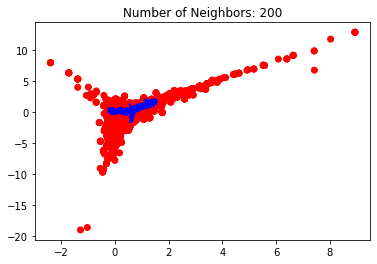

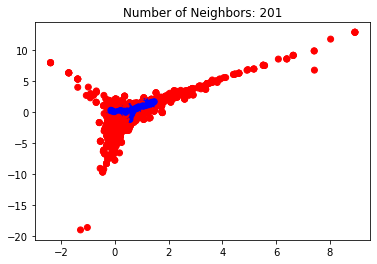

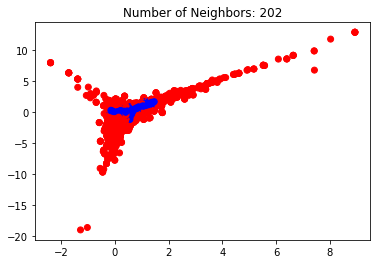

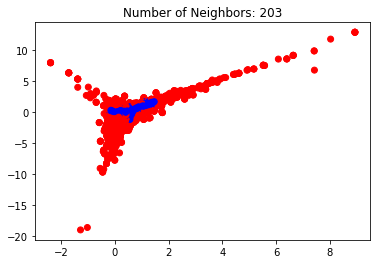

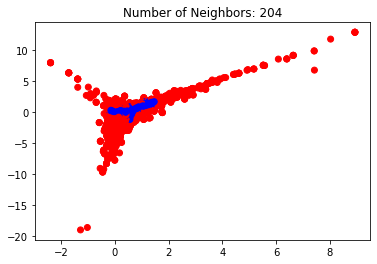

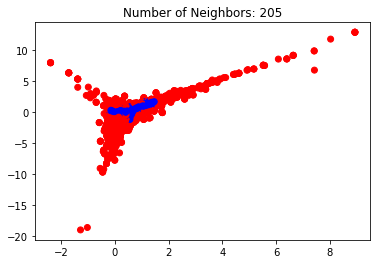

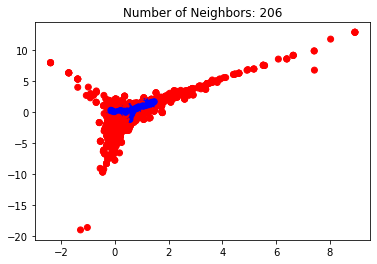

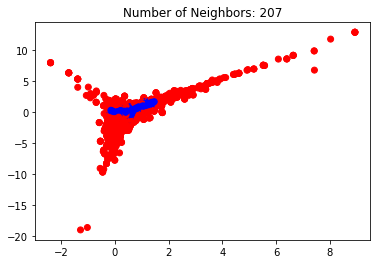

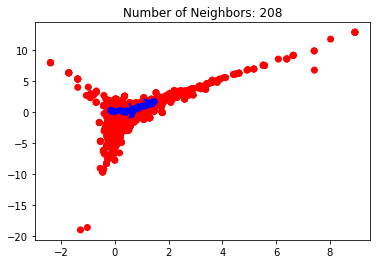

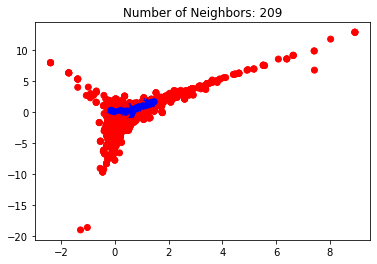

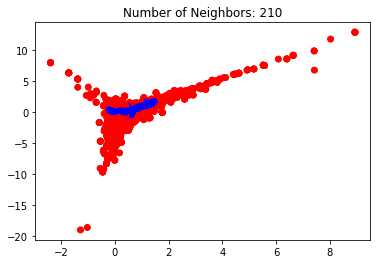

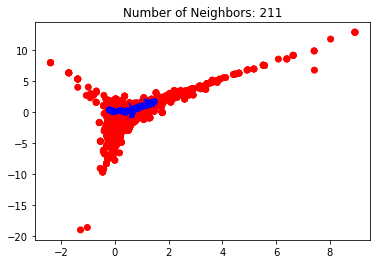

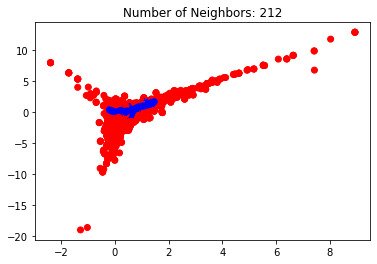

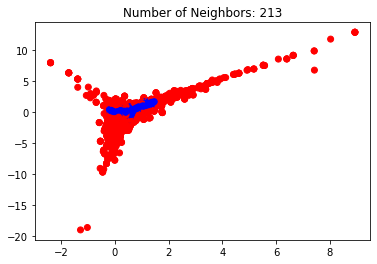

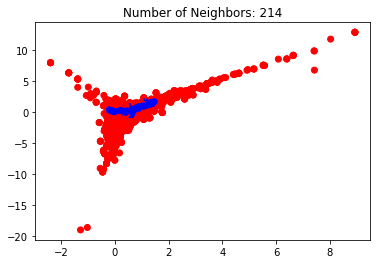

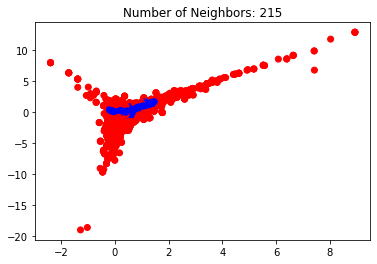

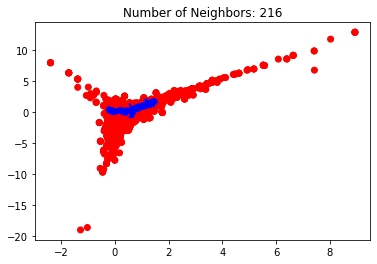

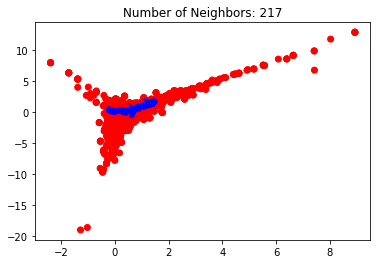

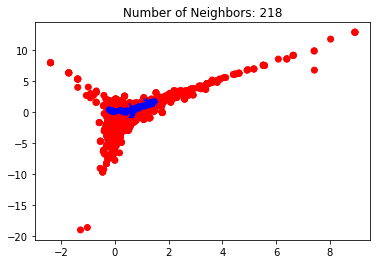

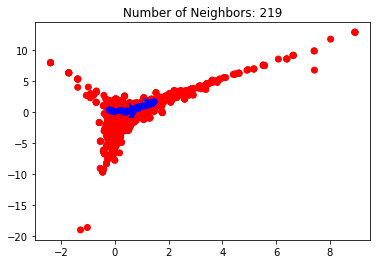

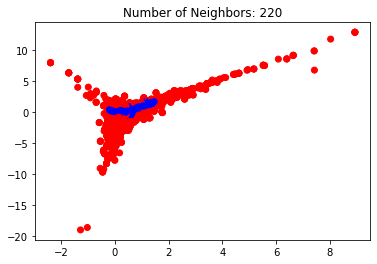

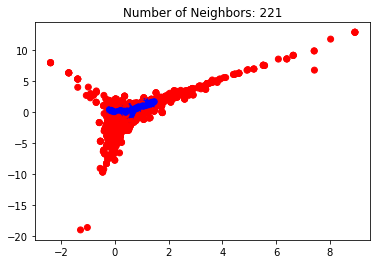

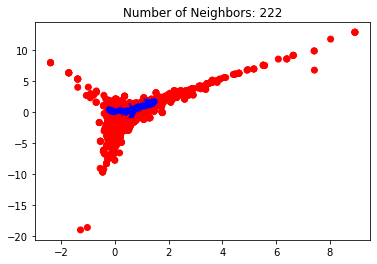

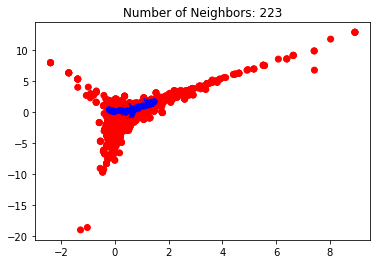

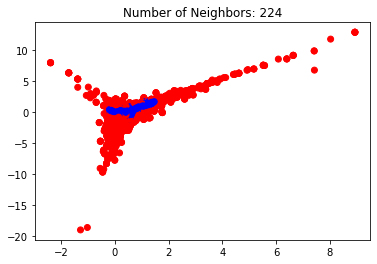

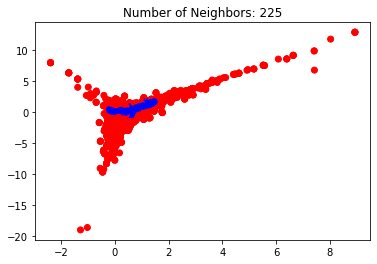

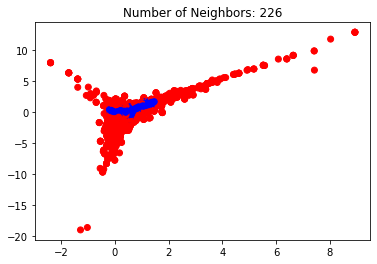

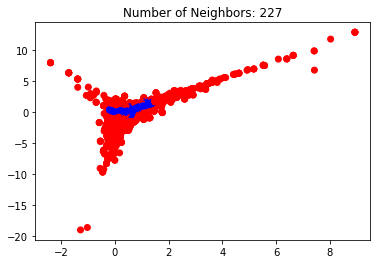

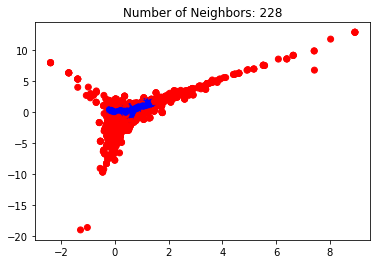

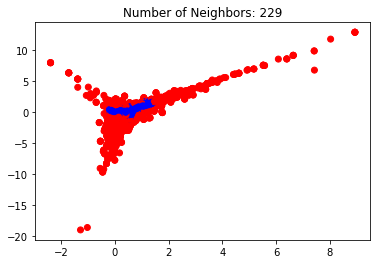

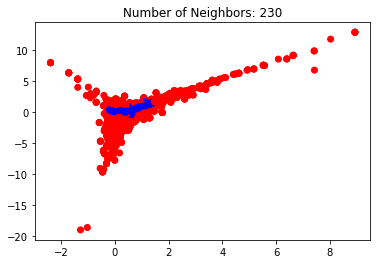

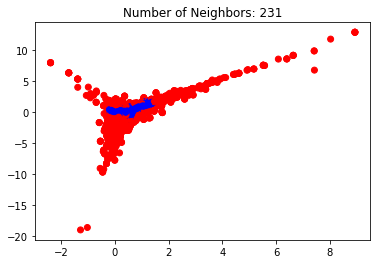

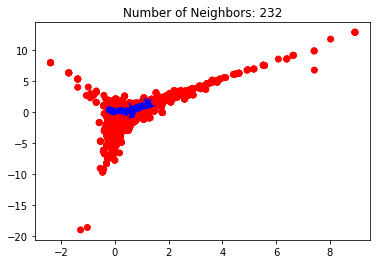

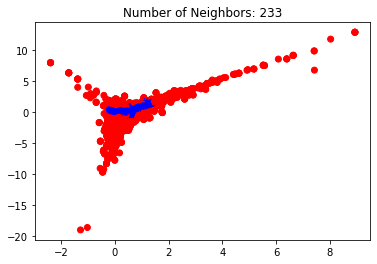

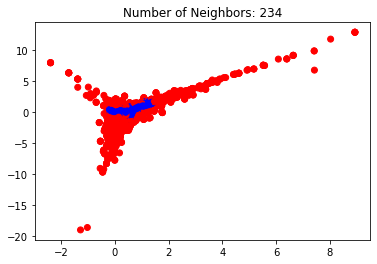

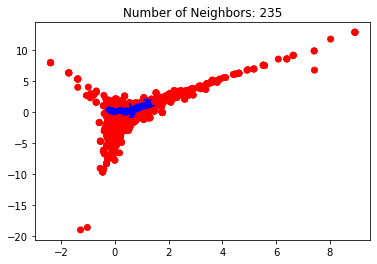

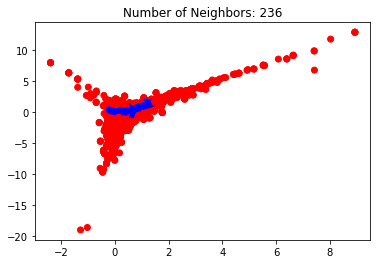

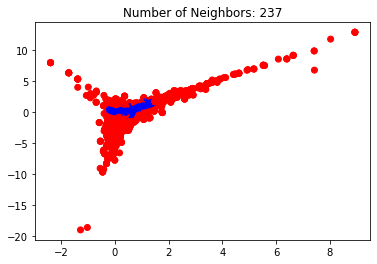

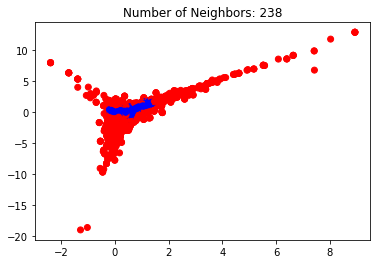

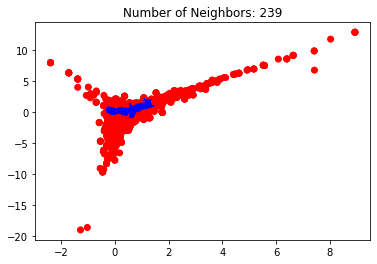

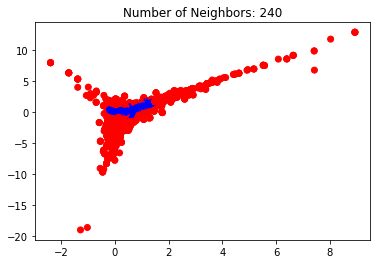

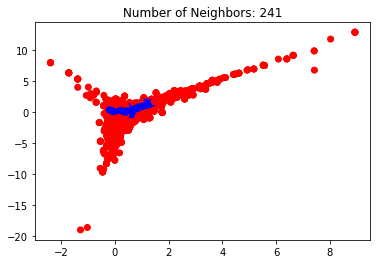

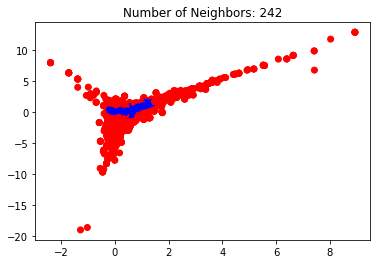

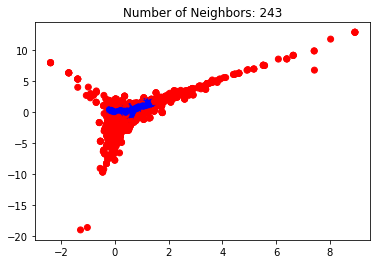

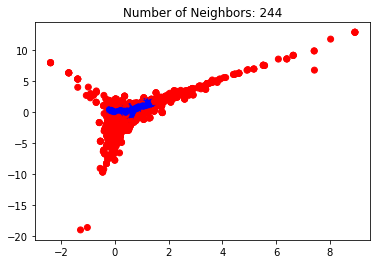

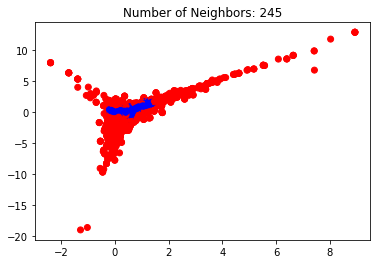

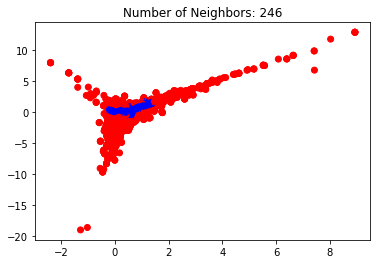

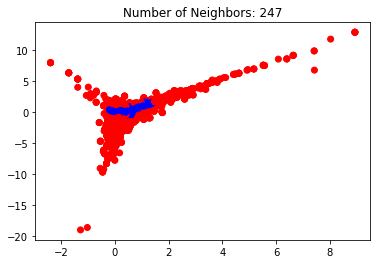

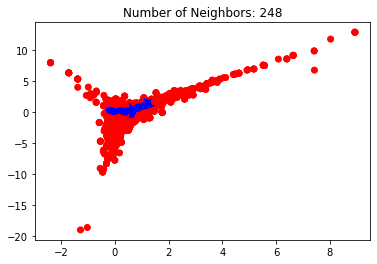

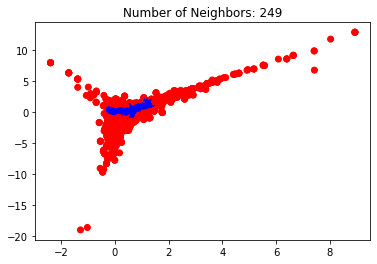

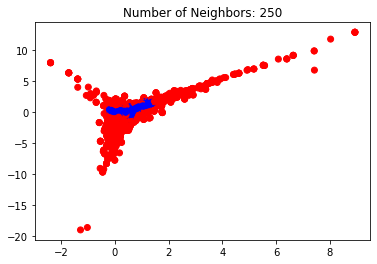

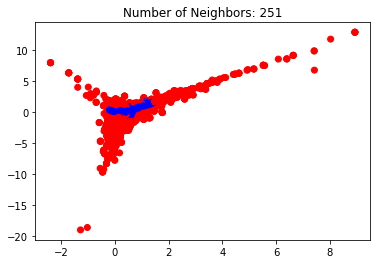

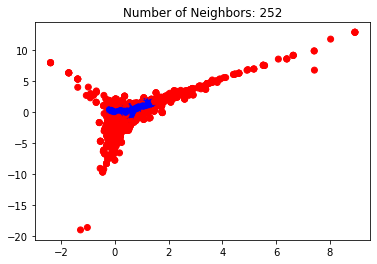

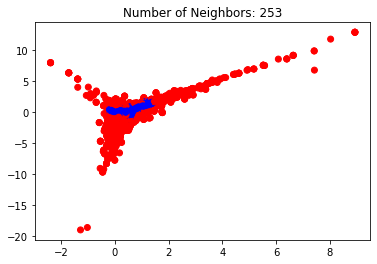

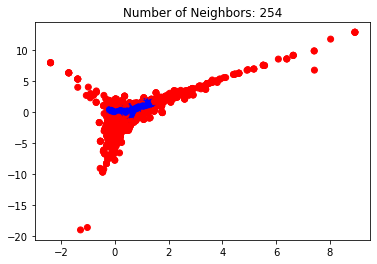

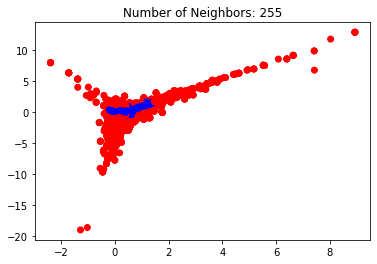

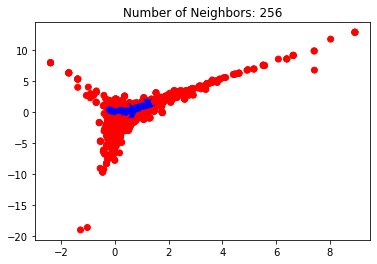

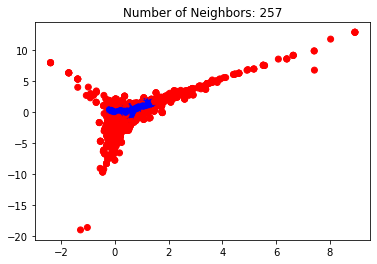

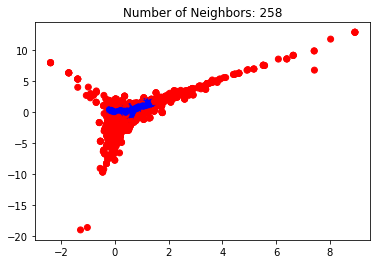

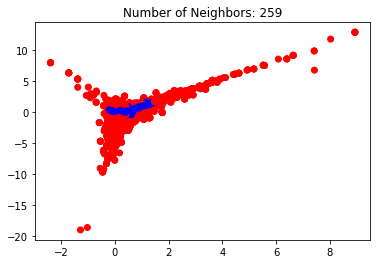

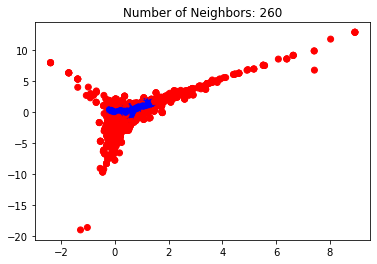

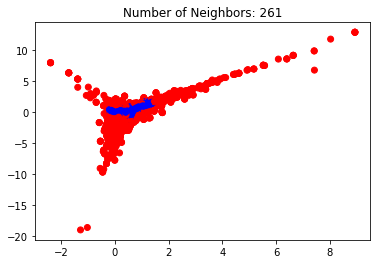

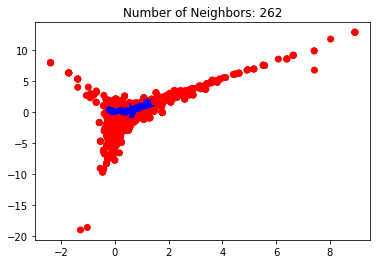

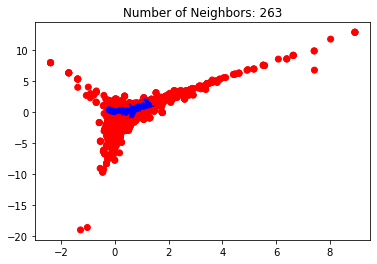

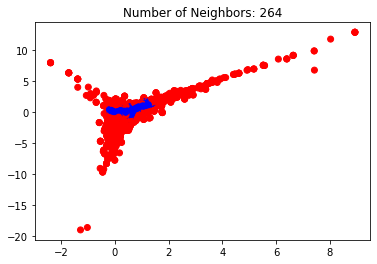

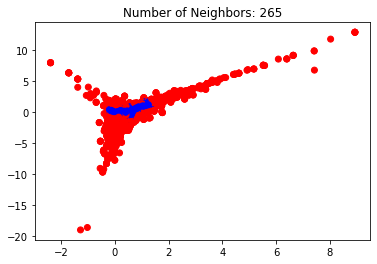

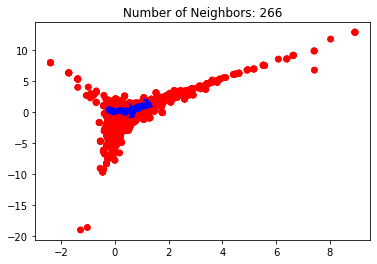

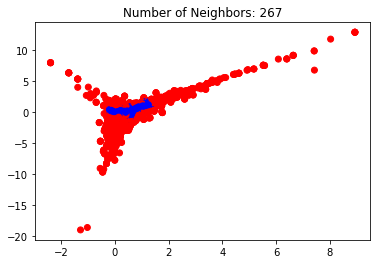

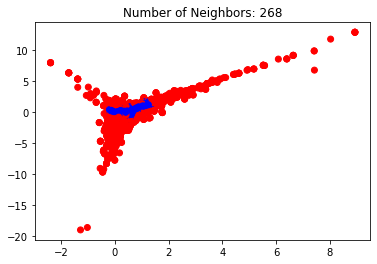

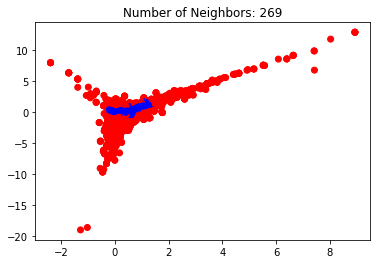

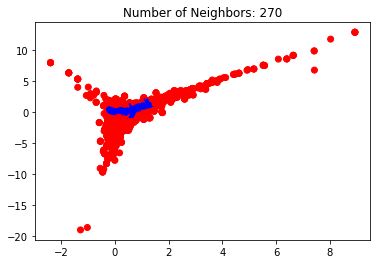

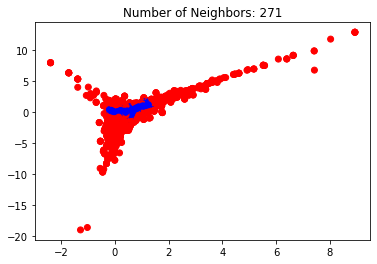

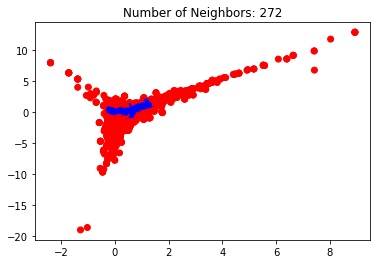

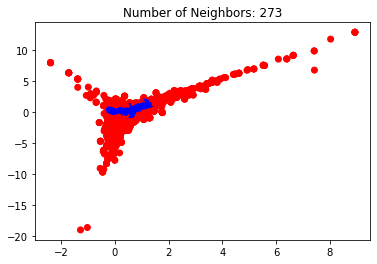

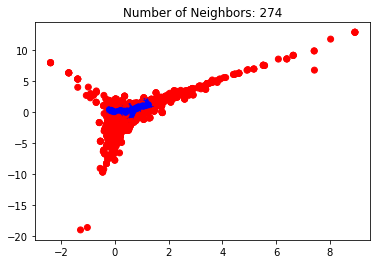

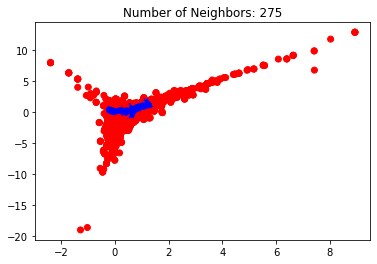

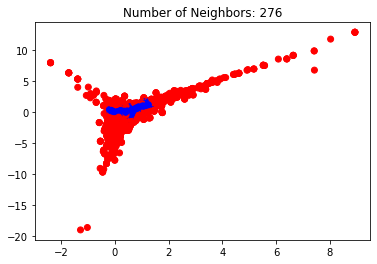

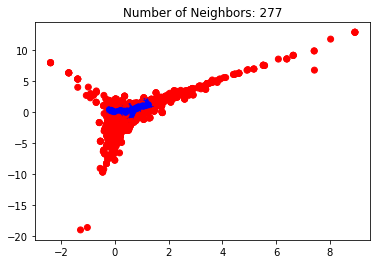

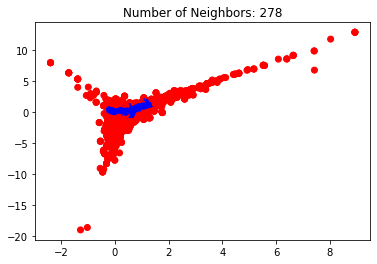

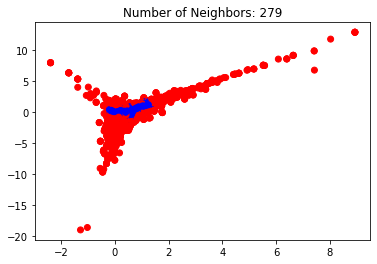

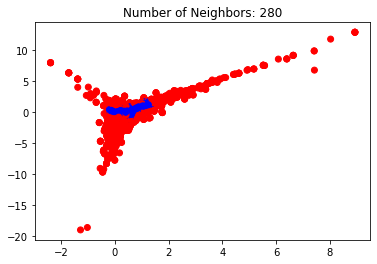

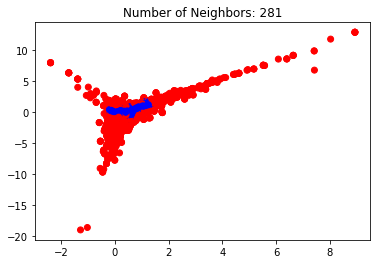

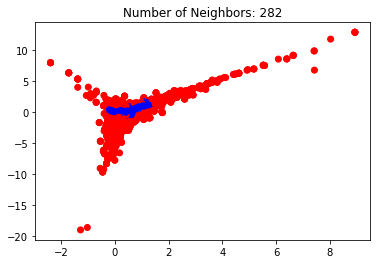

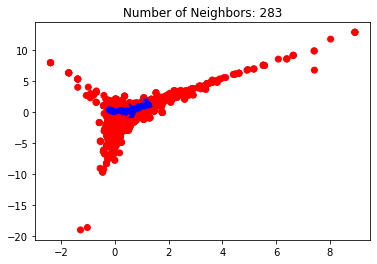

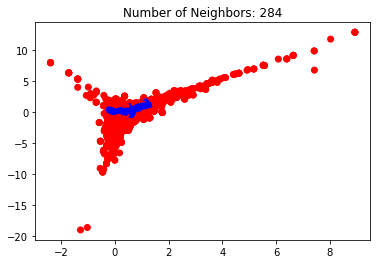

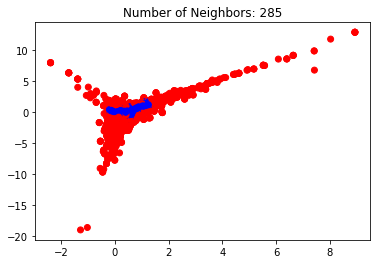

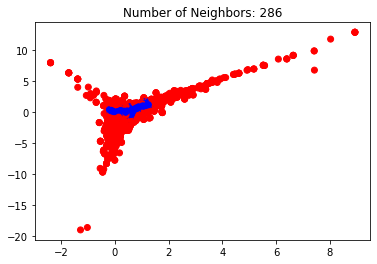

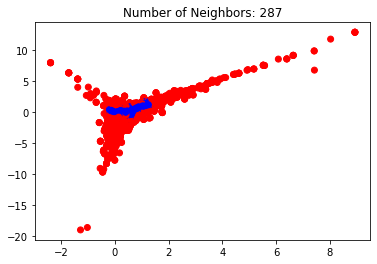

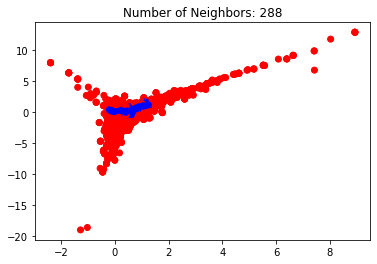

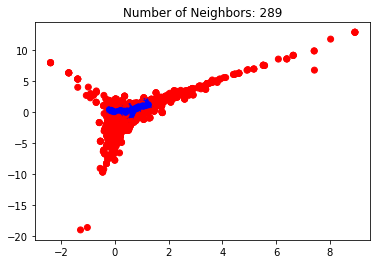

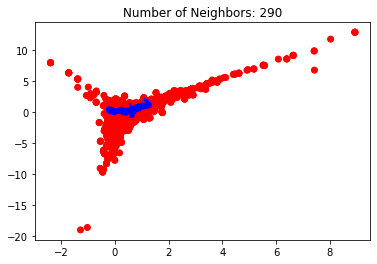

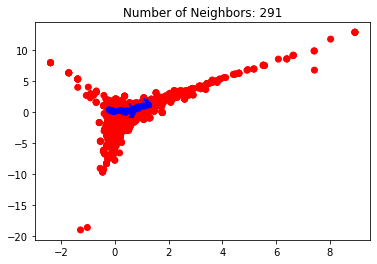

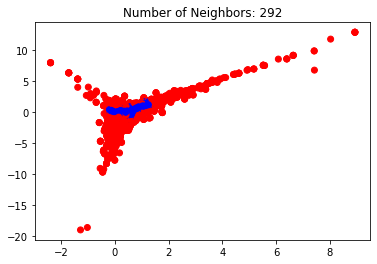

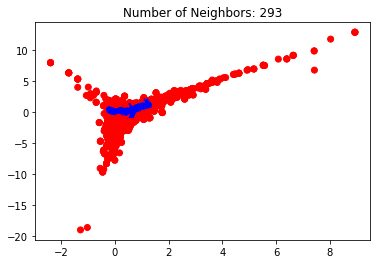

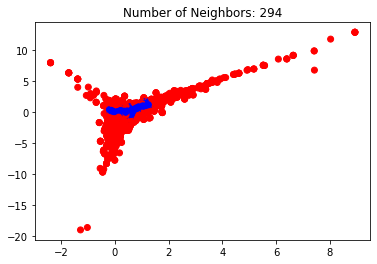

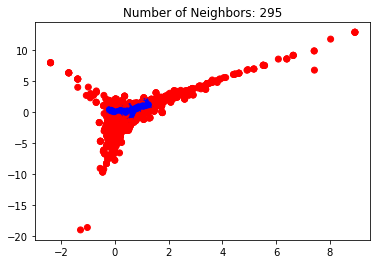

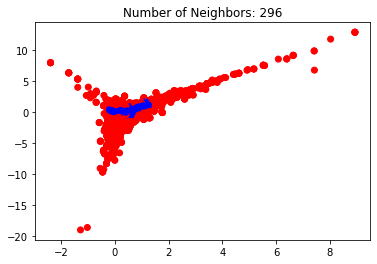

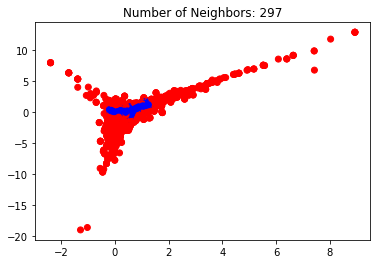

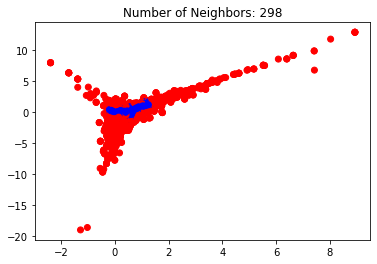

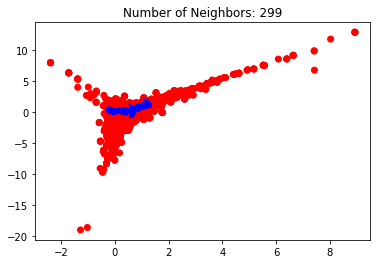

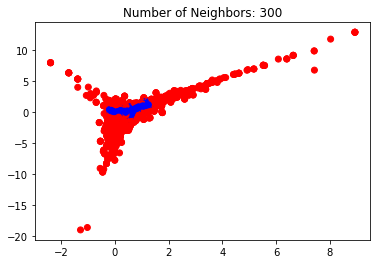

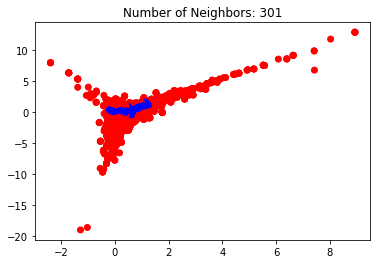

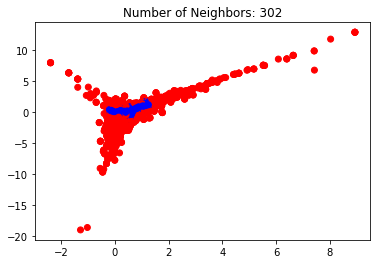

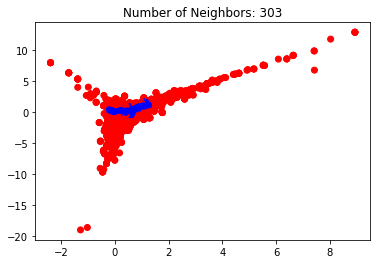

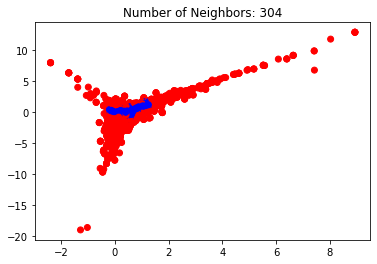

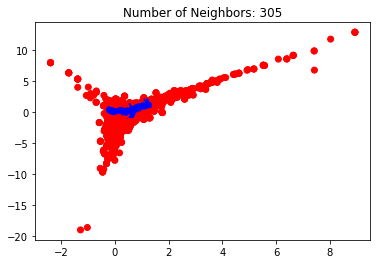

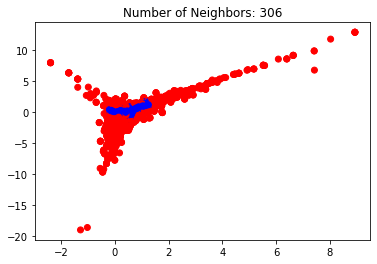

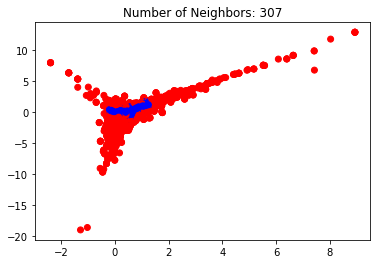

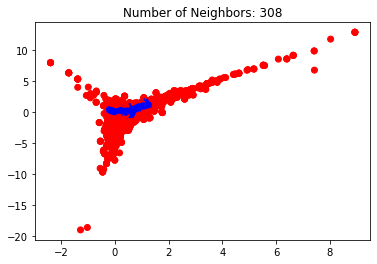

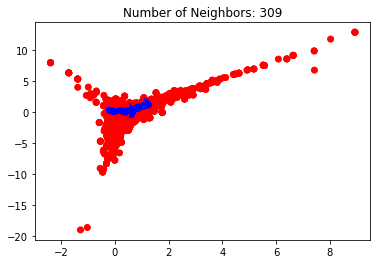

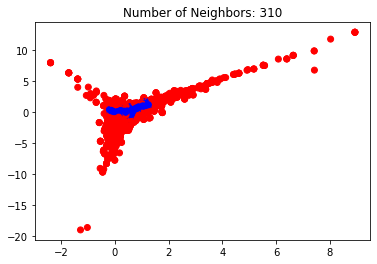

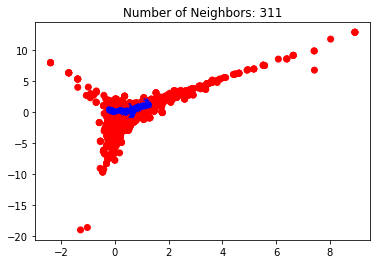

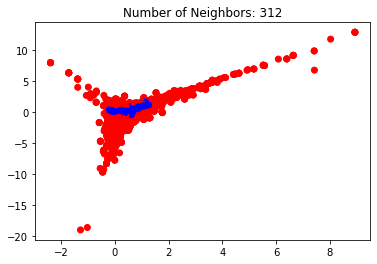

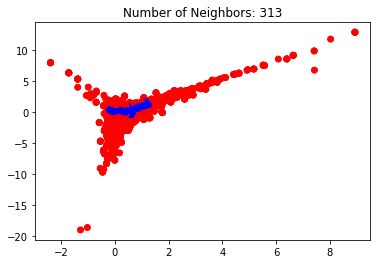

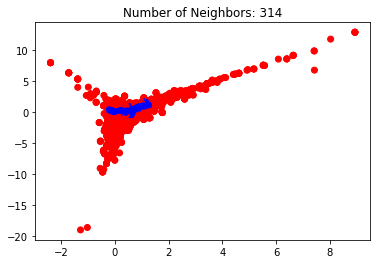

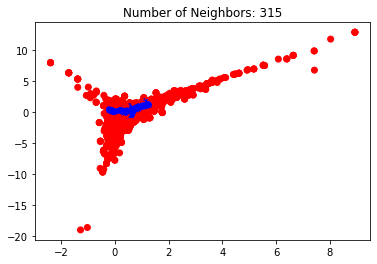

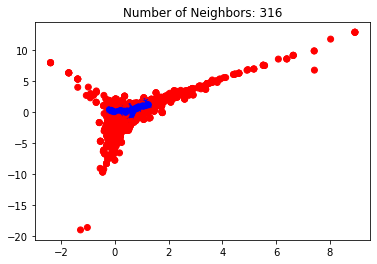

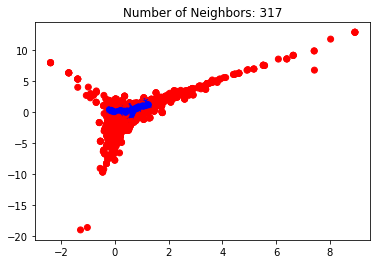

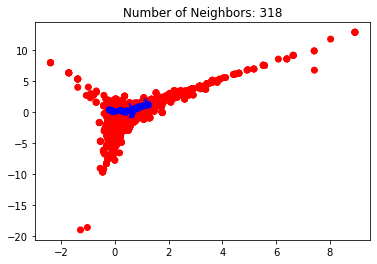

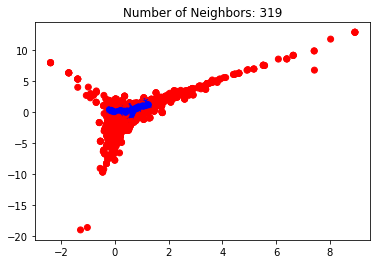

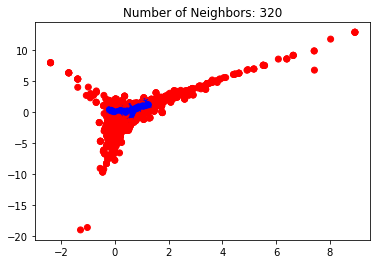

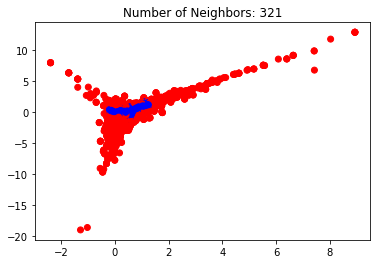

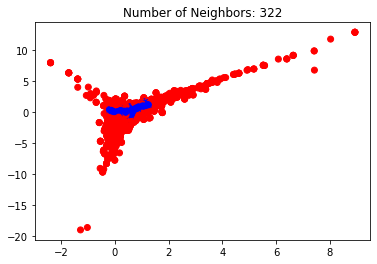

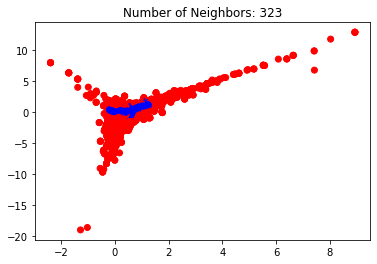

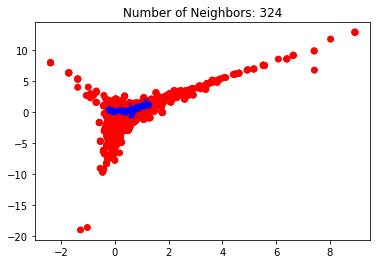

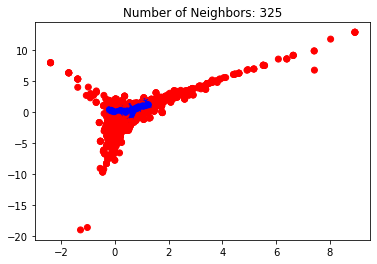

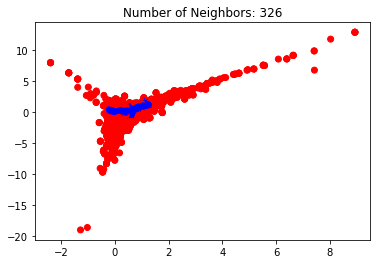

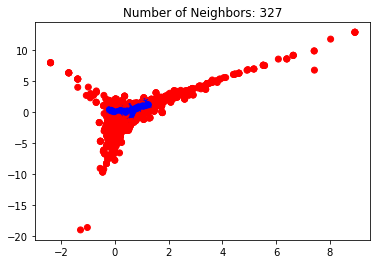

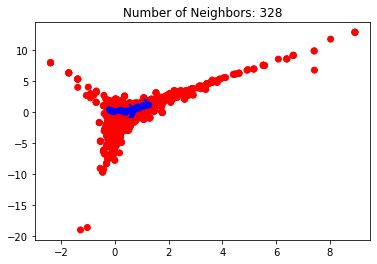

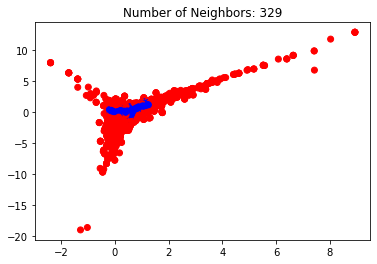

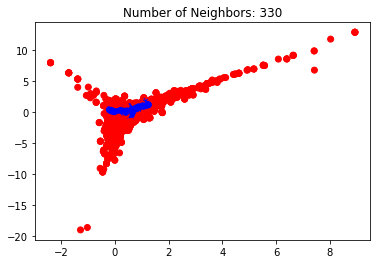

In [95]:
# using Euclidean distances, calculate recall scores of knn models from 1 to n 
lst_recall_scores = []
x = X_test_famd_transformed[0]
y = X_test_famd_transformed[1]

for i in range(1,n+1):
    #calculate/record recall of each KNN model
    knn_cc_trans = KNeighborsClassifier(n_neighbors = i)
    knn_cc_trans.fit(X_train_famd_transformed, y_train)
    y_pred_cc_trans = knn_cc_trans.predict(X_test_famd_transformed)
    y_true_cc_trans = y_test
    recall_cc_trans = recall_score(y_true_cc_trans, y_pred_cc_trans)
    lst_recall_scores.append((i, recall_cc_trans))
    
    # plot KNN model to assess over-fitting/under-fitting (1st 2 FAMD components)
    classes_colors = []
    
    #assign colors to each class
    for pred in y_pred_cc_trans:
        if pred == False:
            classes_colors.append('blue')
        elif pred == True:
            classes_colors.append('red')
    
    plt.scatter(x, y, c = classes_colors)
    plt.title(f'Number of Neighbors: {i}')
    plt.show()
    
# "not fraud": blue
# "fraud": red

Text(0, 0.5, 'Recall Score')

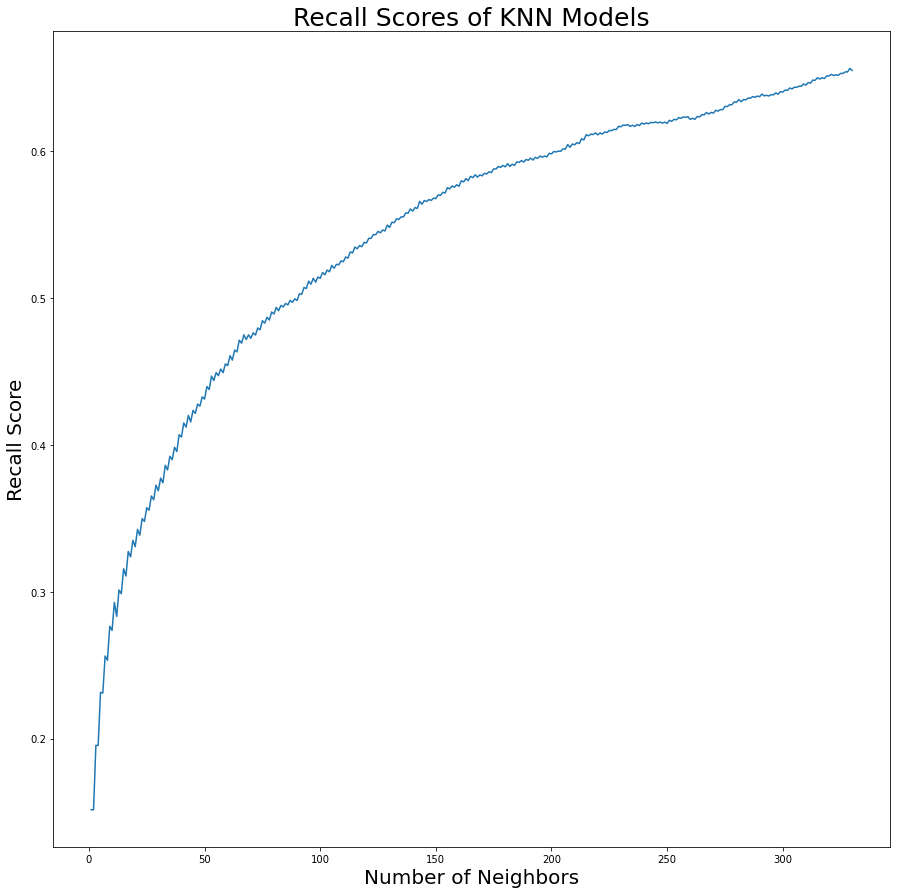

In [96]:
# plot recall for each n_neighbors
num_neighbors = [score[0] for score in lst_recall_scores]
recalls = [score[1] for score in lst_recall_scores]

fig, ax = plt.subplots(figsize = (15, 15))
plt.plot(num_neighbors, recalls)
ax.set_title('Recall Scores of KNN Models', fontsize = 25)
ax.set_xlabel('Number of Neighbors', fontsize = 20)
ax.set_ylabel('Recall Score', fontsize = 20)

In [97]:
max_recall = 0
num_neighbors = 0

for i in range(len(recalls)):
    recall = recalls[i]
    if recall > max_recall:
        max_recall = recall
        num_neighbors = i + 1

In [98]:
print(f'Recall of best KNN model ({num_neighbors} neighbors) on test data is {max_recall * 100:2f}%!')
# 85 neighbors has peak recall of ~65.63% --> semi-viable model (keep it) - NOT overall best model though

Recall of best KNN model (329 neighbors) on test data is 65.630054%!


In [99]:
# assess recall of best KNN model on train data
knn_cc_trans = KNeighborsClassifier(n_neighbors = num_neighbors)
knn_cc_trans.fit(X_train_famd_transformed, y_train)
y_pred_train_cc_trans = knn_cc_trans.predict(X_train_famd_transformed)
y_true_cc_trans = y_train

In [100]:
# this KNN model is over-fit on train data...therefore, 
# DO NOT USE this type of model due to lower recall and over-fitting
print(f'Recall of best KNN model ({num_neighbors} neighbors) on train data is {(recall_score(y_true_cc_trans, y_pred_train_cc_trans) * 100):2f}%!')

Recall of best KNN model (329 neighbors) on train data is 99.917287%!


## Plot Precision-Recall Curve - calculate AUC-PR

/home/jonathon/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


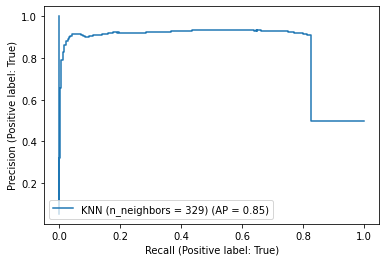

In [101]:
# best KNN model (n_neighbors = 329)
plot_precision_recall_curve(knn_cc_trans, X_test_famd_transformed, y_test, name = 'KNN (n_neighbors = 329)')
plt.show()

In [102]:
# save best KNN model
pickle.dump(knn_cc_trans, open('models/knn_cc_trans.pkl', 'wb'))

## Random Forests

In [ ]:
# CAN DO QUICKER PARAMETER SWEEP WITH SAMPLE OF DATA, THEN TRAIN ALL DATA ON FINAL SET OF 
# HYPERPARAMETERS PINPOINTED, CAN ALSO INCREMENT BY 2/3/etc., NOT NECESSARILY 1

In [112]:
# use explanatory variables as is, no need to perform any type of transformation
X_train_model

distance_from_home  distance_from_last_transaction  \
0                 0.000703                        0.000743   
1                 0.001318                        0.000189   
2                 0.000392                        0.000095   
3                 0.006912                        0.007530   
4                 0.018361                        0.002116   
...                    ...                             ...   
108806            0.000125                        0.000120   
108807            0.009183                        0.000526   
108808            0.030013                        0.112829   
108809            0.014621                        0.000123   
108810            0.001443                        0.000177   

        ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                             0.032181             True       True   
1                             0.006523             True      False   
2                             0.008068            False      False   
3                             0.001325             True      False   
4                             0.070812             True      False   
...                                ...              ...        ...   
108806                        0.033670            False      False   
108807                        0.147533             True      False   
108808                        0.006476             True      False   
108809                        0.038051             True       True   
108810                        0.004272             True      False   

        used_pin_number  online_order  
0                 False          True  
1                 False          True  
2                 False          True  
3                 False          True  
4                 False          True  
...                 ...           ...  
108806            False          True  
108807            False         False  
108808            False         False  
108809            False          True  
108810            False          True  

[108811 rows x 7 columns]

In [113]:
y_train

0          True
1         False
2         False
3         False
4          True
          ...  
108806     True
108807    False
108808     True
108809     True
108810    False
Name: fraud, Length: 108811, dtype: bool

In [114]:
X_test_model

distance_from_home  distance_from_last_transaction  \
0                0.000976                        0.000822   
1                0.001265                        0.000152   
2                0.014157                        0.000292   
3                0.060773                        0.002205   
4                0.009696                        0.000372   
...                   ...                             ...   
27198            0.002331                        0.000356   
27199            0.007404                        0.000487   
27200            0.007932                        0.022107   
27201            0.000647                        0.000157   
27202            0.003825                        0.001881   

       ratio_to_median_purchase_price  repeat_retailer  used_chip  \
0                            0.005311             True      False   
1                            0.010775             True       True   
2                            0.059657             True       True   
3                            0.040521             True      False   
4                            0.055657             True      False   
...                               ...              ...        ...   
27198                        0.014295             True       True   
27199                        0.007157             True      False   
27200                        0.039830             True       True   
27201                        0.048513            False       True   
27202                        0.009124             True      False   

       used_pin_number  online_order  
0                False          True  
1                False         False  
2                False          True  
3                False         False  
4                False          True  
...                ...           ...  
27198            False         False  
27199             True         False  
27200            False          True  
27201            False          True  
27202            False          True  

[27203 rows x 7 columns]

In [115]:
y_test

0        False
1        False
2         True
3         True
4         True
         ...  
27198    False
27199    False
27200     True
27201     True
27202    False
Name: fraud, Length: 27203, dtype: bool

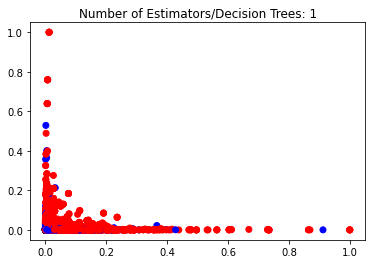

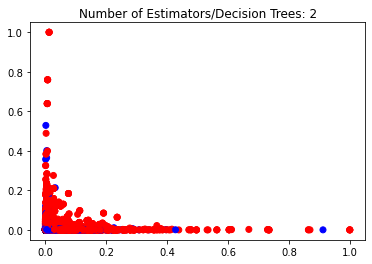

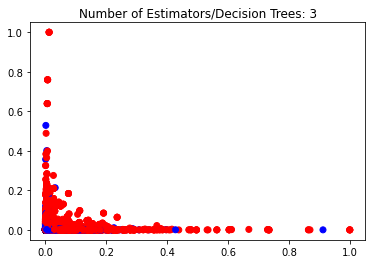

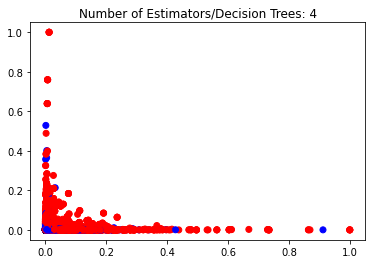

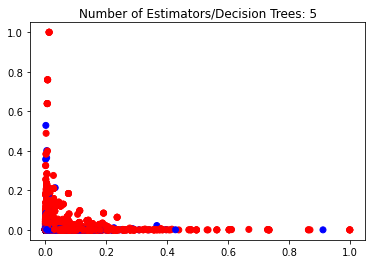

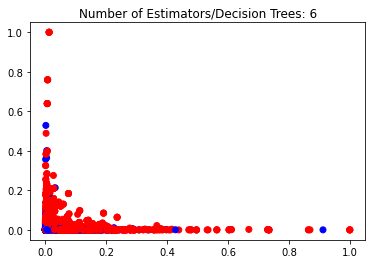

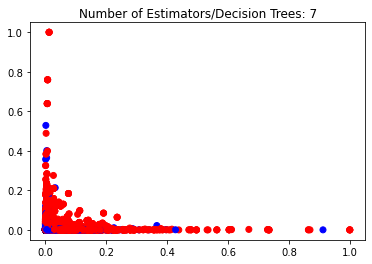

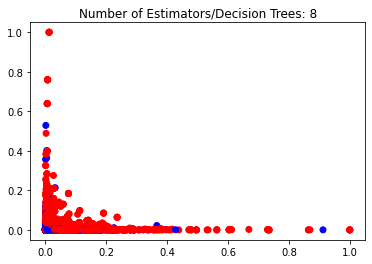

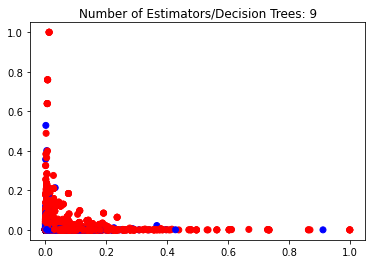

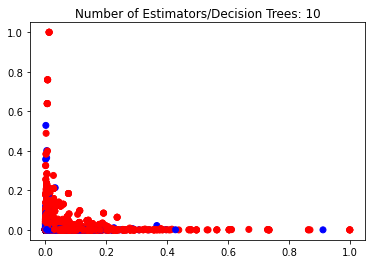

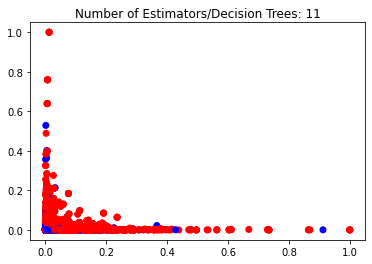

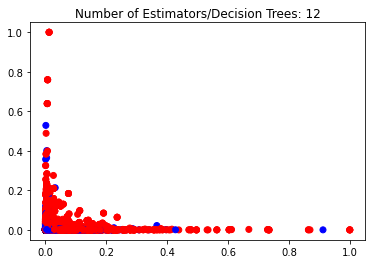

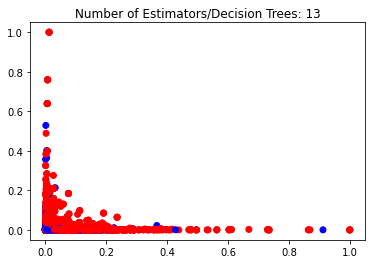

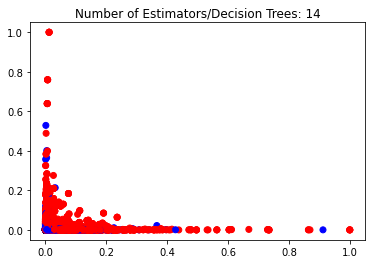

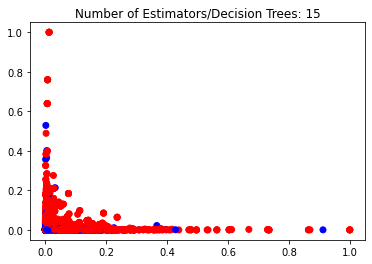

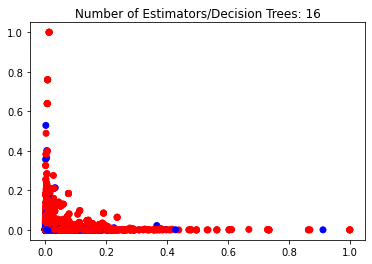

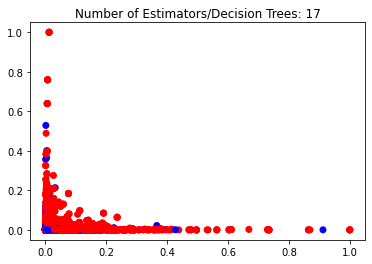

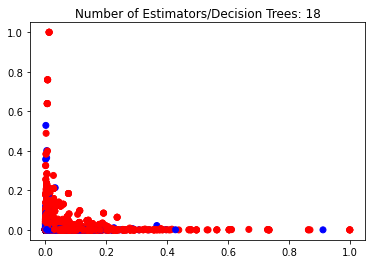

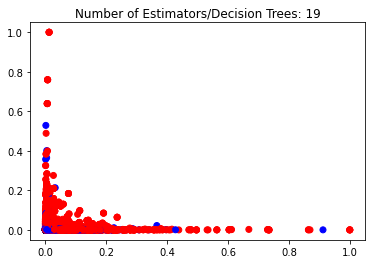

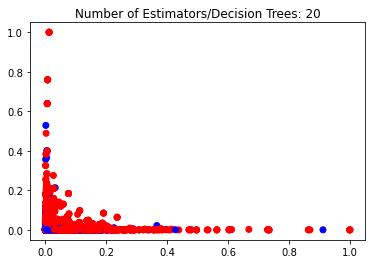

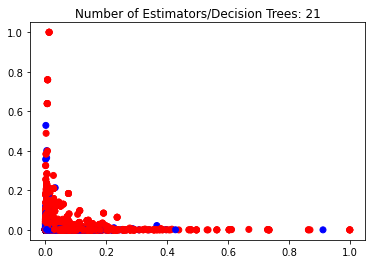

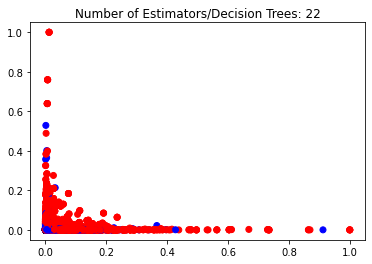

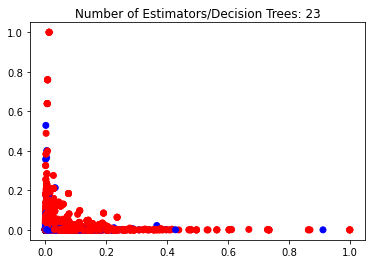

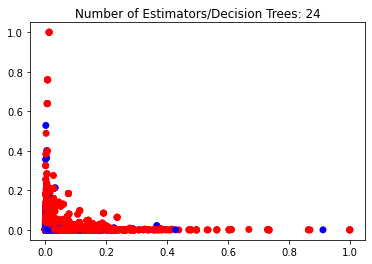

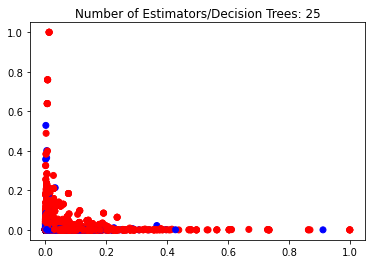

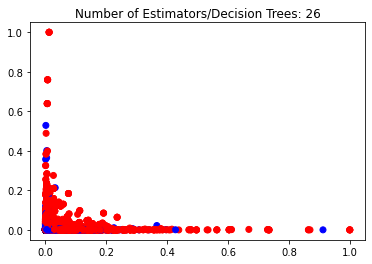

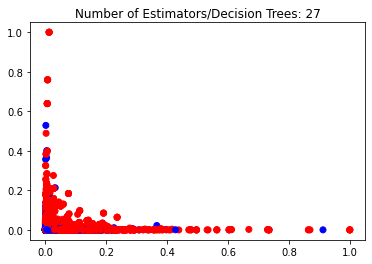

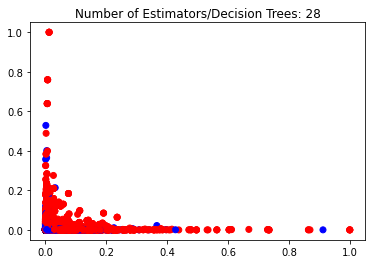

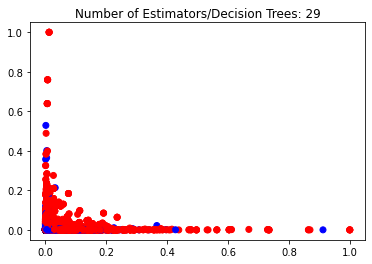

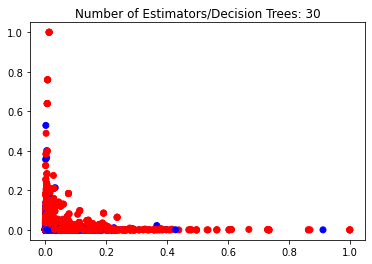

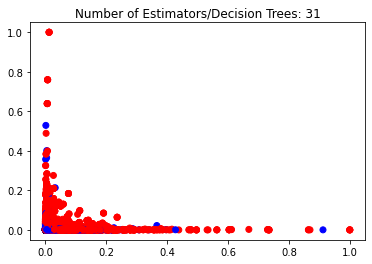

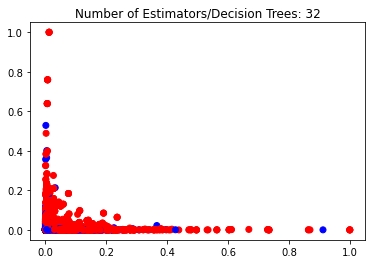

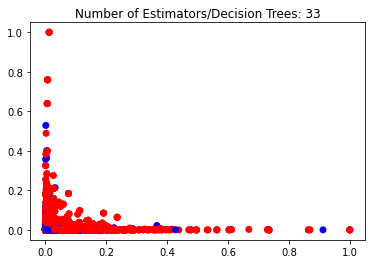

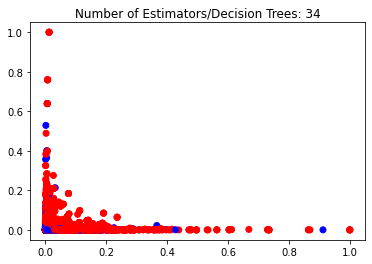

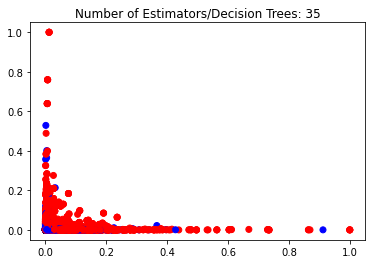

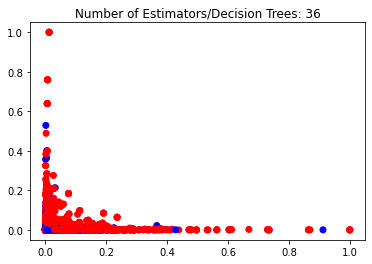

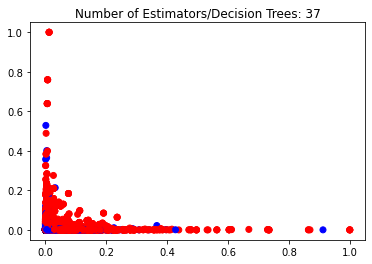

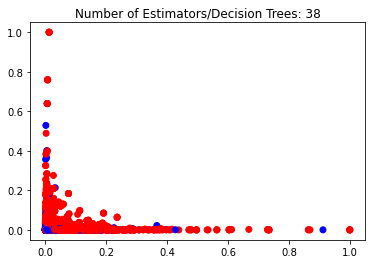

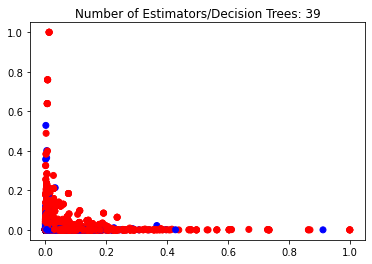

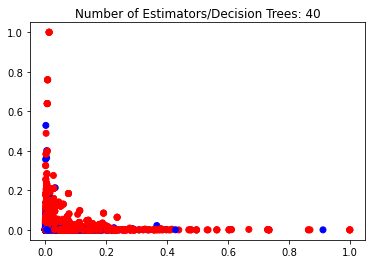

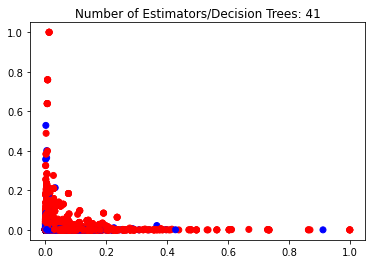

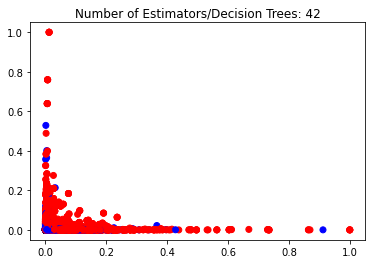

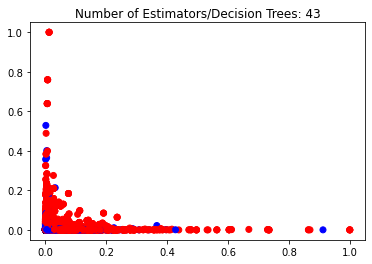

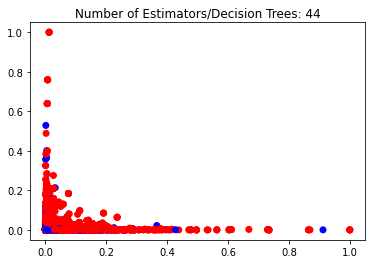

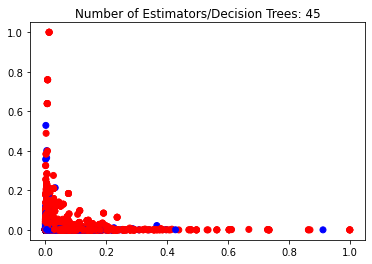

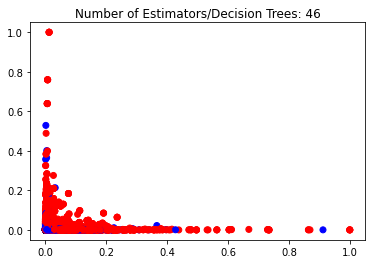

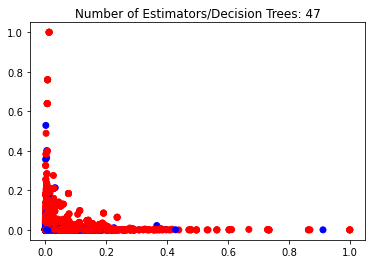

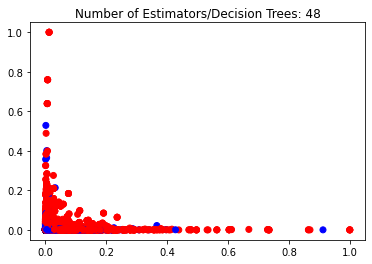

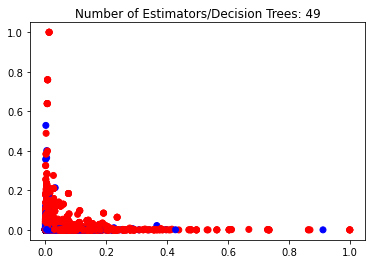

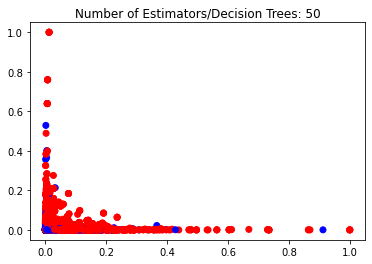

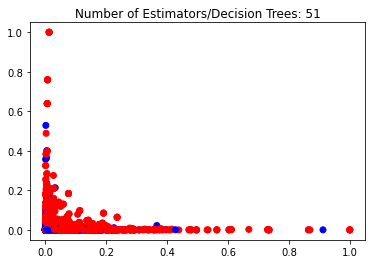

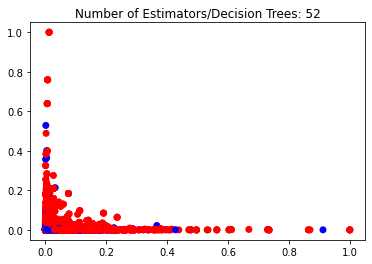

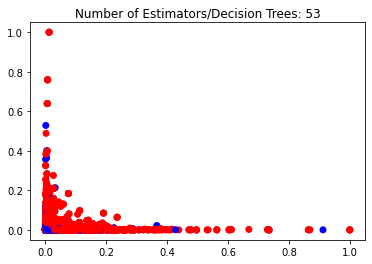

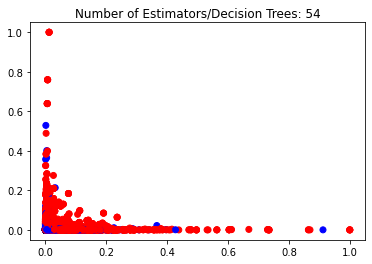

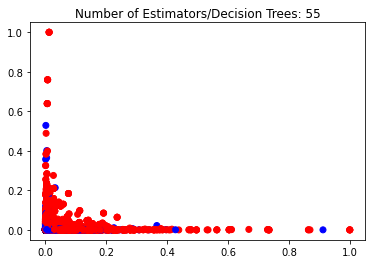

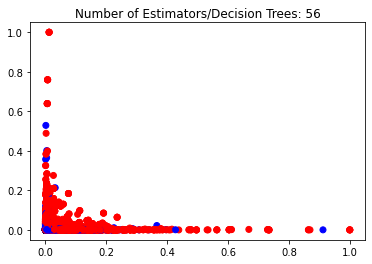

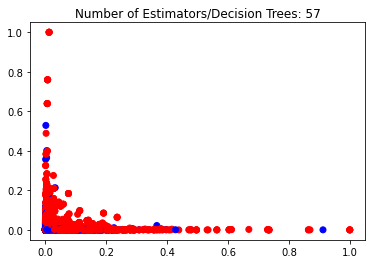

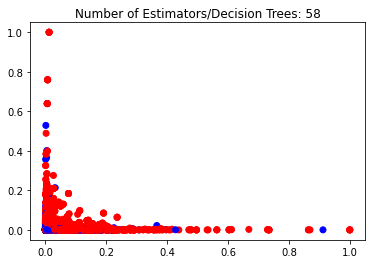

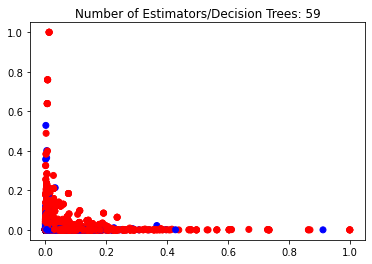

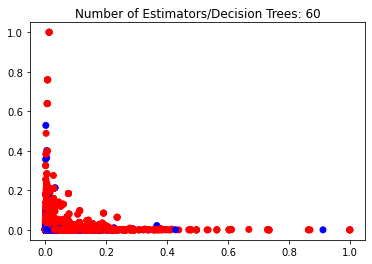

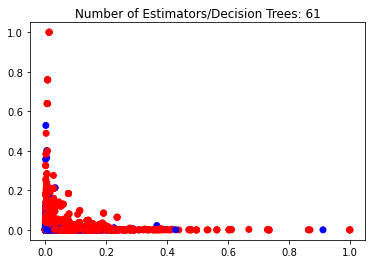

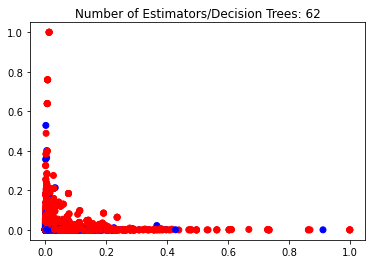

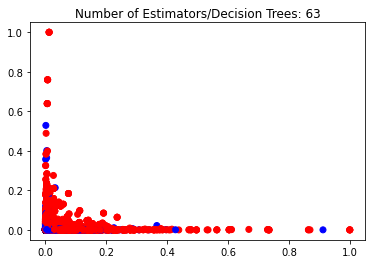

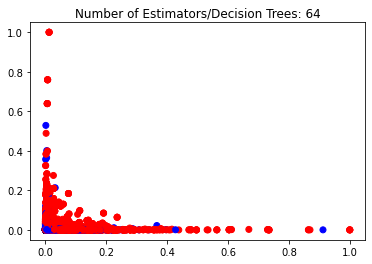

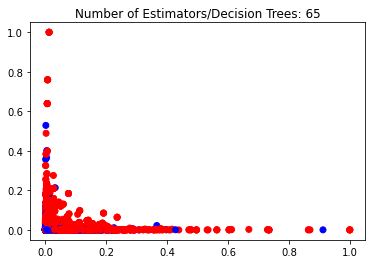

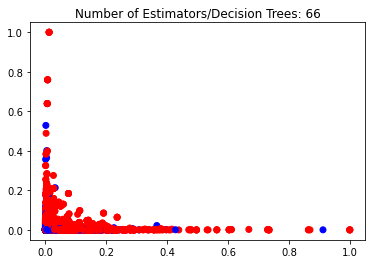

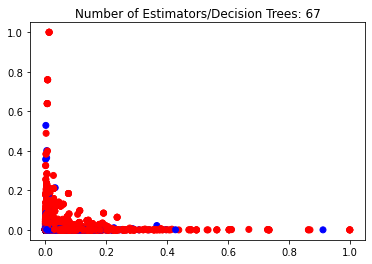

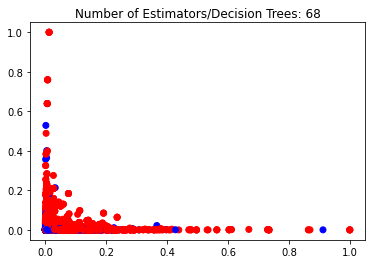

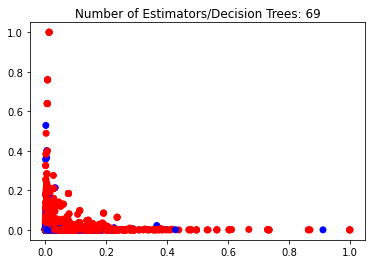

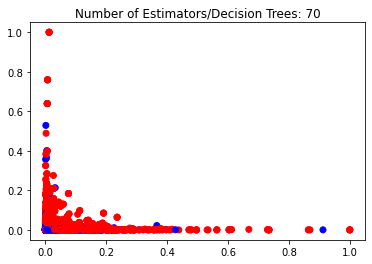

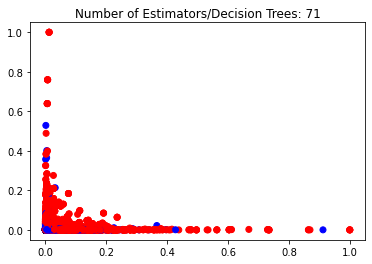

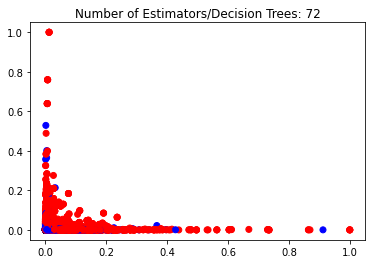

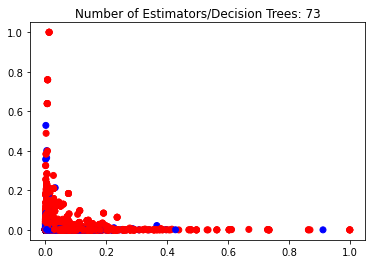

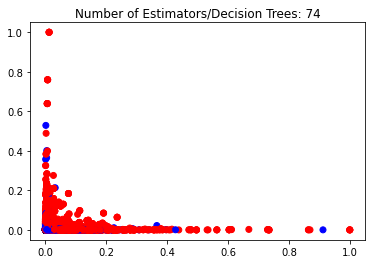

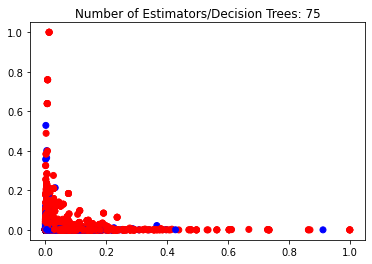

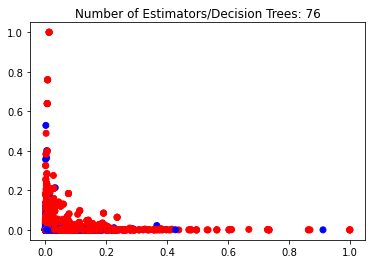

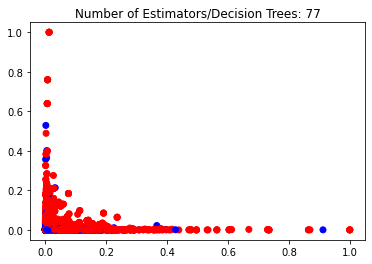

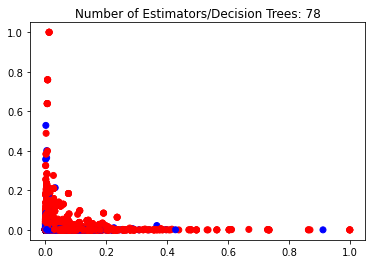

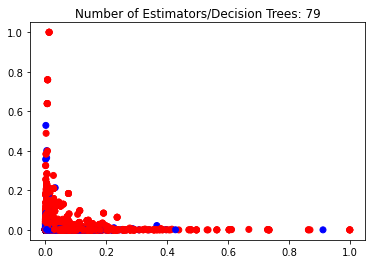

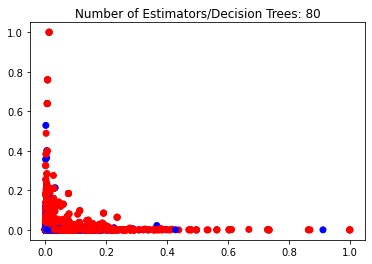

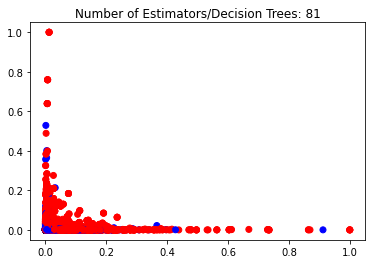

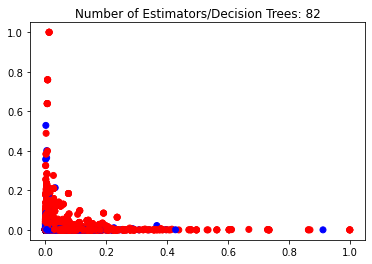

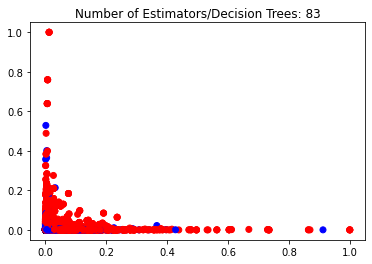

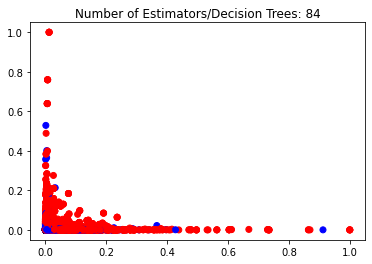

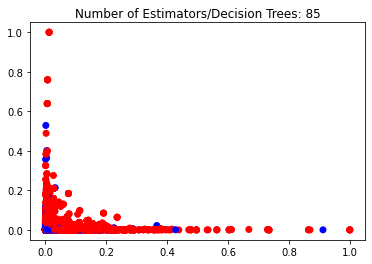

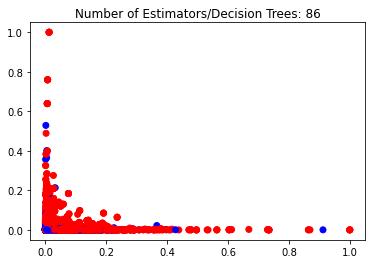

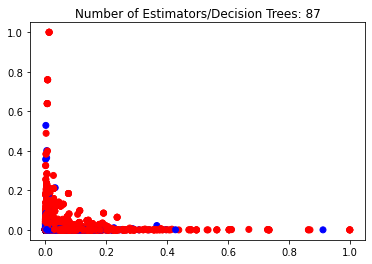

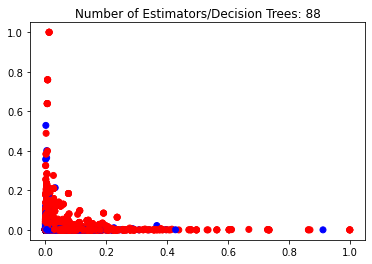

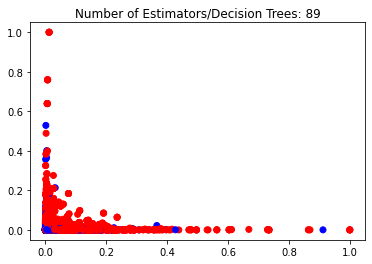

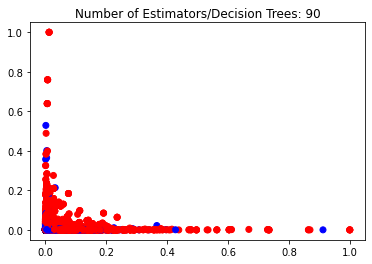

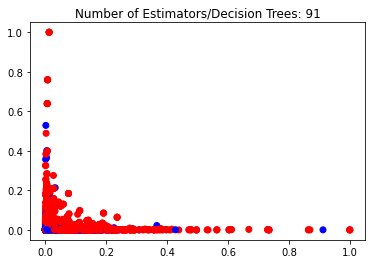

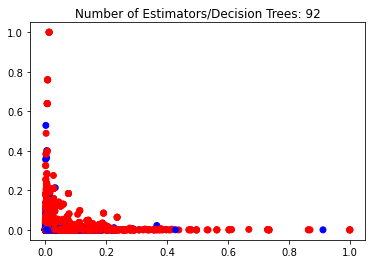

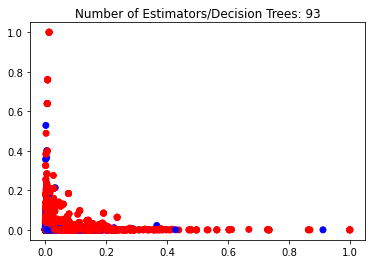

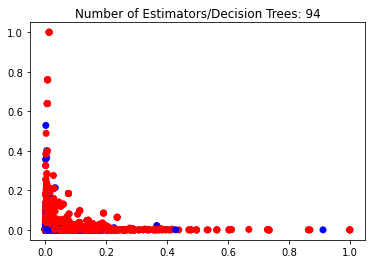

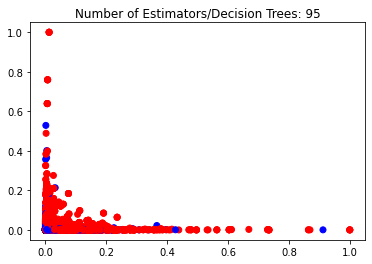

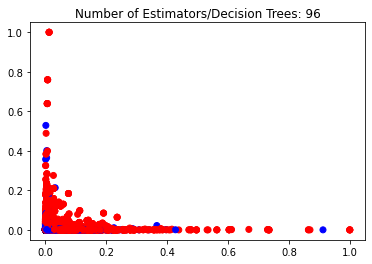

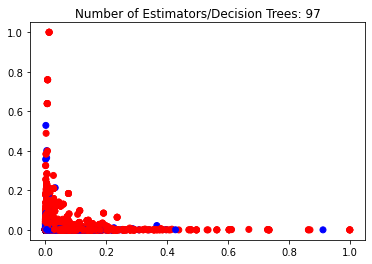

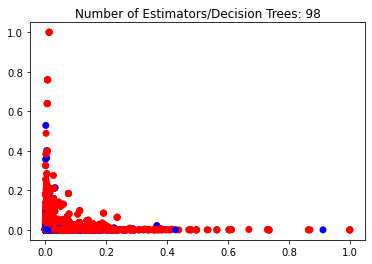

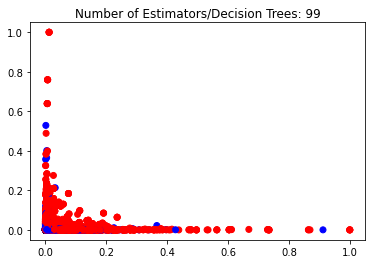

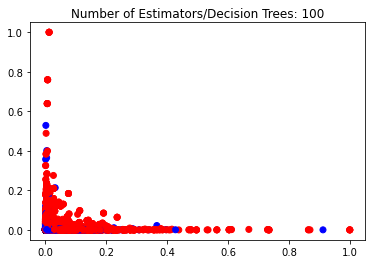

In [123]:
# using random forests, calculate recall scores of RF models from 1 to 100 n_estimators 
lst_recall_scores_rf = []
x = X_test_model[X_test_model.columns.values[0]]
y = X_test_model[X_test_model.columns.values[1]]

for i in range(1,101):
    #calculate/record recall of each RF model
    rf_cc_trans = RandomForestClassifier(n_estimators = i, max_features = None)
    rf_cc_trans.fit(X_train_model, y_train)
    y_pred_rf_cc_trans = rf_cc_trans.predict(X_test_model)
    y_true_rf_cc_trans = y_test
    recall_rf_cc_trans = recall_score(y_true_rf_cc_trans, y_pred_rf_cc_trans)
    lst_recall_scores_rf.append((i, recall_rf_cc_trans))
    
    # plot RF model to assess over-fitting/under-fitting (1st 2 FAMD components)
    classes_colors = []
    
    #assign colors to each class
    for pred in y_pred_rf_cc_trans:
        if pred == False:
            classes_colors.append('blue')
        elif pred == True:
            classes_colors.append('red')
    
    plt.scatter(x, y, c = classes_colors)
    plt.title(f'Number of Estimators/Decision Trees: {i}')
    plt.show()
    
# "not fraud": blue
# "fraud": red

Text(0, 0.5, 'Recall Score')

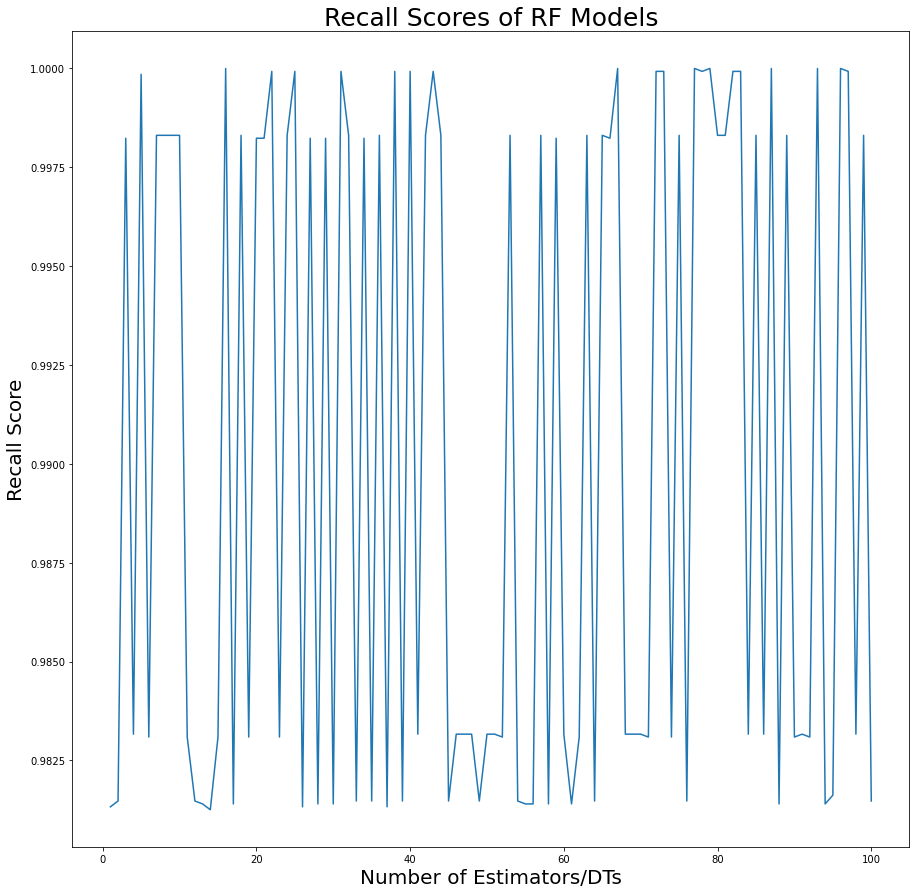

In [124]:
# plot recall for each n_estimators
num_estimators = [score[0] for score in lst_recall_scores_rf]
recalls_rf = [score[1] for score in lst_recall_scores_rf]

fig, ax = plt.subplots(figsize = (15, 15))
plt.plot(num_estimators, recalls_rf)
ax.set_title('Recall Scores of RF Models', fontsize = 25)
ax.set_xlabel('Number of Estimators/DTs', fontsize = 20)
ax.set_ylabel('Recall Score', fontsize = 20)

In [125]:
max_recall_rf = 0
n_estimators = 0

for i in range(len(recalls_rf)):
    recall = recalls_rf[i]
    if recall > max_recall_rf:
        max_recall_rf = recall
        n_estimators = i + 1

In [126]:
print(f'Recall of best RF model ({n_estimators} DTs) on test data is {max_recall_rf * 100:2f}%!')
# 16 estimators/DTs has peak recall of 100% --> most viable model (keep it), AND overall best model

Recall of best RF model (16 DTs) on test data is 100.000000%!


In [130]:
# assess recall of best RF model on train data
rf_cc_trans = RandomForestClassifier(n_estimators = n_estimators, max_features = None)
rf_cc_trans.fit(X_train_model, y_train)
y_pred_rf_train_cc_trans = rf_cc_trans.predict(X_train_model)
#y_true_cc_trans = y_train

In [131]:
print(f'Recall of best RF model ({n_estimators} DTs) on train data is {(recall_score(y_true_cc_trans, y_pred_rf_train_cc_trans) * 100):2f}%!')

Recall of best RF model (16 DTs) on train data is 100.000000%!


## Plot Precision-Recall Curve - calculate AUC-PR

/home/jonathon/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_precision_recall_curve is deprecated; Function `plot_precision_recall_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: PrecisionRecallDisplay.from_predictions or PrecisionRecallDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


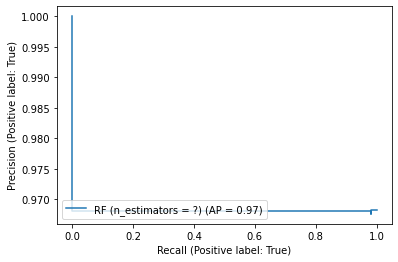

In [132]:
# best RF model (n_estimators = ?)
plot_precision_recall_curve(rf_cc_trans, X_test_model, y_test, name = 'RF (n_estimators = ?)')
plt.show()

In [133]:
# save best RF model (AND best model overall)
pickle.dump(rf_cc_trans, open('models/rf_cc_trans.pkl', 'wb'))